In [1]:
 # Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import tensorflow as tf
from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from keras.regularizers import l2
import os
import sqlite3

In [2]:
# @title data_fetch
# Enhanced TSMOM Data Fetcher with Easy Configuration
# Modular design for easy period setting and data customization

import yfinance as yf
import pandas as pd
import numpy as np
import warnings
from datetime import datetime, timedelta
import time
import json
from typing import Dict, List, Optional, Tuple, Union
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

class TSMOMConfig:
    """Configuration class for TSMOM data fetching"""

    def __init__(self):
        self.reset_to_default()

    def reset_to_default(self):
        """Reset to default configuration"""
        # Asset universe configuration
        self.asset_universe = {
            # COMMODITIES (Energy)
            'CL=F': {'name': 'Crude_Oil', 'class': 'Commodities', 'active': True},
            'NG=F': {'name': 'Natural_Gas', 'class': 'Commodities', 'active': True},
            'RB=F': {'name': 'Gasoline', 'class': 'Commodities', 'active': True},
            'HO=F': {'name': 'Heating_Oil', 'class': 'Commodities', 'active': True},

            # COMMODITIES (Metals)
            'GC=F': {'name': 'Gold', 'class': 'Commodities', 'active': True},
            'SI=F': {'name': 'Silver', 'class': 'Commodities', 'active': True},
            'HG=F': {'name': 'Copper', 'class': 'Commodities', 'active': True},
            'PL=F': {'name': 'Platinum', 'class': 'Commodities', 'active': True},
            'PA=F': {'name': 'Palladium', 'class': 'Commodities', 'active': True},

            # COMMODITIES (Agriculture)
            'ZC=F': {'name': 'Corn', 'class': 'Commodities', 'active': True},
            'ZW=F': {'name': 'Wheat', 'class': 'Commodities', 'active': True},
            'ZS=F': {'name': 'Soybeans', 'class': 'Commodities', 'active': True},
            'ZM=F': {'name': 'Soy_Meal', 'class': 'Commodities', 'active': True},
            'ZL=F': {'name': 'Soy_Oil', 'class': 'Commodities', 'active': True},
            'SB=F': {'name': 'Sugar', 'class': 'Commodities', 'active': True},
            'CC=F': {'name': 'Cocoa', 'class': 'Commodities', 'active': True},
            'KC=F': {'name': 'Coffee', 'class': 'Commodities', 'active': True},
            'CT=F': {'name': 'Cotton', 'class': 'Commodities', 'active': True},
            'HE=F': {'name': 'Lean_Hogs', 'class': 'Commodities', 'active': True},
            'LE=F': {'name': 'Live_Cattle', 'class': 'Commodities', 'active': True},

            # EQUITY INDICES
            '^GSPC': {'name': 'SP500', 'class': 'Equities', 'active': True},
            '^FTSE': {'name': 'FTSE100', 'class': 'Equities', 'active': True},
            '^GDAXI': {'name': 'DAX', 'class': 'Equities', 'active': True},
            '^FCHI': {'name': 'CAC40', 'class': 'Equities', 'active': True},
            '^N225': {'name': 'Nikkei225', 'class': 'Equities', 'active': True},
            '^AEX': {'name': 'AEX', 'class': 'Equities', 'active': True},
            '^IBEX': {'name': 'IBEX35', 'class': 'Equities', 'active': True},

            # CURRENCIES
            'EURUSD=X': {'name': 'EUR_USD', 'class': 'Currencies', 'active': True},
            'GBPUSD=X': {'name': 'GBP_USD', 'class': 'Currencies', 'active': True},
            'USDJPY=X': {'name': 'USD_JPY', 'class': 'Currencies', 'active': True},
            'USDCAD=X': {'name': 'USD_CAD', 'class': 'Currencies', 'active': True},
            'AUDUSD=X': {'name': 'AUD_USD', 'class': 'Currencies', 'active': True},
            'NZDUSD=X': {'name': 'NZD_USD', 'class': 'Currencies', 'active': True},
            'USDCHF=X': {'name': 'USD_CHF', 'class': 'Currencies', 'active': True},
            'EURGBP=X': {'name': 'EUR_GBP', 'class': 'Currencies', 'active': True},
            'EURJPY=X': {'name': 'EUR_JPY', 'class': 'Currencies', 'active': True},
            'AUDJPY=X': {'name': 'AUD_JPY', 'class': 'Currencies', 'active': True},

            # GOVERNMENT BONDS (Yields)
            '^TNX': {'name': 'US_10Y_Yield', 'class': 'Fixed_Income', 'active': True},
            '^TYX': {'name': 'US_30Y_Yield', 'class': 'Fixed_Income', 'active': True},
            '^FVX': {'name': 'US_5Y_Yield', 'class': 'Fixed_Income', 'active': True},
            '^IRX': {'name': 'US_3M_Yield', 'class': 'Fixed_Income', 'active': True},

            # BOND FUTURES
            'ZB=F': {'name': 'US_30Y_Bond', 'class': 'Fixed_Income', 'active': True},
            'ZN=F': {'name': 'US_10Y_Note', 'class': 'Fixed_Income', 'active': True},
            'ZF=F': {'name': 'US_5Y_Note', 'class': 'Fixed_Income', 'active': True},
            'ZT=F': {'name': 'US_2Y_Note', 'class': 'Fixed_Income', 'active': True},
        }

        # Time period settings
        self.time_periods = {
            'default': {'start': '2015-01-01', 'end': None},
            'short_term': {'start': '2020-01-01', 'end': None},
            'medium_term': {'start': '2018-01-01', 'end': None},
            'long_term': {'start': '2010-01-01', 'end': None},
            'post_covid': {'start': '2020-03-01', 'end': None},
            'custom': {'start': '2015-01-01', 'end': None}
        }

        # Data quality settings
        self.data_quality = {
            'min_data_points': 300,
            'min_completeness': 0.8,
            'max_missing_threshold': 0.5,
            'forward_fill': True,
            'drop_insufficient': True
        }

        # Fetching settings
        self.fetch_settings = {
            'rate_limit_delay': 0.05,
            'retry_attempts': 3,
            'timeout': 30,
            'benchmark_ticker': '^GSPC',
            'risk_free_ticker': '^IRX'
        }

    def set_time_period(self, period_name: str = None, start_date: str = None, end_date: str = None):
        """Set time period for data fetching"""
        if period_name and period_name in self.time_periods:
            if start_date:
                self.time_periods[period_name]['start'] = start_date
            if end_date:
                self.time_periods[period_name]['end'] = end_date
        elif start_date:
            # Set custom period
            self.time_periods['custom']['start'] = start_date
            self.time_periods['custom']['end'] = end_date

    def get_time_period(self, period_name: str = 'default') -> Dict[str, str]:
        """Get time period settings"""
        if period_name not in self.time_periods:
            period_name = 'default'

        period = self.time_periods[period_name].copy()
        if period['end'] is None:
            period['end'] = datetime.now().strftime('%Y-%m-%d')

        return period

    def activate_assets(self, asset_names: List[str] = None, asset_classes: List[str] = None,
                       tickers: List[str] = None):
        """Activate specific assets"""
        if asset_names:
            for ticker, info in self.asset_universe.items():
                info['active'] = info['name'] in asset_names
        elif asset_classes:
            for ticker, info in self.asset_universe.items():
                info['active'] = info['class'] in asset_classes
        elif tickers:
            for ticker, info in self.asset_universe.items():
                info['active'] = ticker in tickers

    def deactivate_assets(self, asset_names: List[str] = None, asset_classes: List[str] = None,
                         tickers: List[str] = None):
        """Deactivate specific assets"""
        if asset_names:
            for ticker, info in self.asset_universe.items():
                if info['name'] in asset_names:
                    info['active'] = False
        elif asset_classes:
            for ticker, info in self.asset_universe.items():
                if info['class'] in asset_classes:
                    info['active'] = False
        elif tickers:
            for ticker, info in self.asset_universe.items():
                if ticker in tickers:
                    info['active'] = False

    def get_active_assets(self) -> Dict[str, Dict]:
        """Get currently active assets"""
        return {ticker: info for ticker, info in self.asset_universe.items()
                if info['active']}

    def get_asset_classes(self) -> List[str]:
        """Get available asset classes"""
        return list(set(info['class'] for info in self.asset_universe.values()))

    def save_config(self, filename: str = 'tsmom_config.json'):
        """Save configuration to file"""
        config_data = {
            'asset_universe': self.asset_universe,
            'time_periods': self.time_periods,
            'data_quality': self.data_quality,
            'fetch_settings': self.fetch_settings
        }
        with open(filename, 'w') as f:
            json.dump(config_data, f, indent=2)
        print(f"💾 Configuration saved to {filename}")

    def load_config(self, filename: str = 'tsmom_config.json'):
        """Load configuration from file"""
        try:
            with open(filename, 'r') as f:
                config_data = json.load(f)

            self.asset_universe = config_data.get('asset_universe', self.asset_universe)
            self.time_periods = config_data.get('time_periods', self.time_periods)
            self.data_quality = config_data.get('data_quality', self.data_quality)
            self.fetch_settings = config_data.get('fetch_settings', self.fetch_settings)

            print(f"📂 Configuration loaded from {filename}")
        except Exception as e:
            print(f"❌ Failed to load config: {str(e)}")

    def print_summary(self):
        """Print configuration summary"""
        active_assets = self.get_active_assets()
        asset_classes = {}
        for info in active_assets.values():
            asset_class = info['class']
            asset_classes[asset_class] = asset_classes.get(asset_class, 0) + 1

        print("📋 TSMOM Configuration Summary")
        print("=" * 50)
        print(f"🎯 Active Assets: {len(active_assets)}")
        print(f"📊 Asset Classes:")
        for asset_class, count in asset_classes.items():
            print(f"  - {asset_class}: {count} assets")
        print(f"📅 Available Periods: {', '.join(self.time_periods.keys())}")
        print(f"🔍 Min Data Points: {self.data_quality['min_data_points']}")
        print(f"📈 Min Completeness: {self.data_quality['min_completeness']:.1%}")


class EnhancedTSMOMFetcher:
    """Enhanced TSMOM Data Fetcher with easy configuration"""

    def __init__(self, config: TSMOMConfig = None):
        self.config = config if config else TSMOMConfig()
        self.last_fetch_metadata = None

    def _flatten_columns(self, data):
        """Flatten MultiIndex columns if present"""
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = data.columns.get_level_values(0)
        return data

    def _find_price_column(self, data):
        """Find the best price column to use"""
        data = self._flatten_columns(data)
        priority_columns = ['Adj Close', 'Close', 'Price', 'Last']

        for col in priority_columns:
            if col in data.columns:
                return col, data[col]

        numeric_cols = data.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            return numeric_cols[0], data[numeric_cols[0]]

        return None, None

    def _fetch_single_asset(self, ticker: str, asset_info: Dict, start_date: str,
                           end_date: str) -> Tuple[Optional[pd.Series], str]:
        """Fetch data for a single asset with robust error handling"""
        try:
            data = yf.download(ticker, start=start_date, end=end_date, progress=False)

            if data.empty:
                return None, f"Empty dataset for {ticker}"

            price_col_name, price_series = self._find_price_column(data)

            if price_series is None:
                return None, f"No price column found for {ticker}"

            price_series = price_series.dropna()
            min_points = self.config.data_quality['min_data_points']

            if len(price_series) < min_points:
                return None, f"Insufficient data: {len(price_series)} < {min_points}"

            return price_series, f"Success using '{price_col_name}'"

        except Exception as e:
            return None, f"Error: {str(e)}"

    def fetch_data(self, period_name: str = 'default',
                   start_date: str = None, end_date: str = None) -> Tuple[pd.DataFrame, Dict]:
        """
        Fetch data with enhanced configuration support

        Parameters:
        -----------
        period_name : str
            Name of predefined period or 'custom'
        start_date : str, optional
            Custom start date (overrides period_name)
        end_date : str, optional
            Custom end date (overrides period_name)

        Returns:
        --------
        tuple : (prices_df, metadata)
        """
        # Determine time period
        if start_date or end_date:
            self.config.set_time_period('custom', start_date, end_date)
            period = self.config.get_time_period('custom')
        else:
            period = self.config.get_time_period(period_name)

        start_date = period['start']
        end_date = period['end']

        print(f"🔄 Fetching TSMOM data from {start_date} to {end_date}")
        print(f"📊 Period: {period_name}")

        active_assets = self.config.get_active_assets()
        print(f"🎯 Assets to fetch: {len(active_assets)}")
        print("=" * 60)

        successful_data = {}
        failed_assets = {}

        for i, (ticker, asset_info) in enumerate(active_assets.items(), 1):
            asset_name = asset_info['name']
            asset_class = asset_info['class']

            print(f"[{i:2d}/{len(active_assets)}] {asset_name:15s} ({ticker:10s}) [{asset_class:12s}]", end=" ")

            price_series, status = self._fetch_single_asset(ticker, asset_info, start_date, end_date)

            if price_series is not None:
                successful_data[asset_name] = price_series
                print(f"✅ {status}")
            else:
                failed_assets[asset_name] = status
                print(f"❌ {status}")

            time.sleep(self.config.fetch_settings['rate_limit_delay'])

        if not successful_data:
            raise ValueError("No data was successfully fetched!")

        # Create consolidated dataset
        print(f"\n📊 Creating consolidated dataset...")
        prices_df = pd.DataFrame(successful_data).sort_index()

        # Data cleaning based on config
        if self.config.data_quality['forward_fill']:
            prices_df = prices_df.ffill()

        # Remove rows with too many missing values
        threshold = len(prices_df.columns) * self.config.data_quality['max_missing_threshold']
        prices_df = prices_df.dropna(thresh=threshold)

        # Remove assets with insufficient completeness
        min_completeness = self.config.data_quality['min_completeness']
        asset_completeness = prices_df.count() / len(prices_df)
        valid_assets = asset_completeness[asset_completeness >= min_completeness].index
        prices_df = prices_df[valid_assets]

        # Generate metadata
        asset_class_counts = {}
        for asset in prices_df.columns:
            for ticker, info in active_assets.items():
                if info['name'] == asset:
                    asset_class = info['class']
                    asset_class_counts[asset_class] = asset_class_counts.get(asset_class, 0) + 1
                    break

        metadata = {
            'period_name': period_name,
            'date_range': (start_date, end_date),
            'actual_date_range': (prices_df.index[0], prices_df.index[-1]),
            'successful_assets': list(successful_data.keys()),
            'failed_assets': failed_assets,
            'asset_class_counts': asset_class_counts,
            'total_observations': len(prices_df),
            'success_rate': len(successful_data) / len(active_assets),
            'data_completeness': asset_completeness.to_dict()
        }

        self.last_fetch_metadata = metadata

        # Print summary
        print(f"✅ Dataset created successfully!")
        print(f"📅 Date range: {prices_df.index[0].strftime('%Y-%m-%d')} to {prices_df.index[-1].strftime('%Y-%m-%d')}")
        print(f"📊 Final shape: {prices_df.shape}")
        print(f"🎯 Success rate: {len(successful_data)}/{len(active_assets)} ({metadata['success_rate']:.1%})")
        print(f"\n📋 Asset class breakdown:")
        for asset_class, count in asset_class_counts.items():
            print(f"  {asset_class}: {count} assets")

        return prices_df, metadata

    def fetch_benchmark(self, period_name: str = 'default',
                       start_date: str = None, end_date: str = None) -> Optional[pd.Series]:
        """Fetch benchmark data (S&P 500)"""
        if start_date or end_date:
            period = {'start': start_date or '2015-01-01',
                     'end': end_date or datetime.now().strftime('%Y-%m-%d')}
        else:
            period = self.config.get_time_period(period_name)

        print("📈 Fetching S&P 500 benchmark...")
        ticker = self.config.fetch_settings['benchmark_ticker']

        price_series, status = self._fetch_single_asset(
            ticker, {'name': 'SP500', 'class': 'Benchmark'},
            period['start'], period['end']
        )

        if price_series is not None:
            print(f"✅ Benchmark: {status}")
            return price_series
        else:
            print(f"❌ Benchmark failed: {status}")
            return None

    def fetch_risk_free_rate(self, period_name: str = 'default',
                            start_date: str = None, end_date: str = None) -> Optional[pd.Series]:
        """Fetch risk-free rate data"""
        if start_date or end_date:
            period = {'start': start_date or '2015-01-01',
                     'end': end_date or datetime.now().strftime('%Y-%m-%d')}
        else:
            period = self.config.get_time_period(period_name)

        print("🏛️ Fetching risk-free rate (3M Treasury)...")
        ticker = self.config.fetch_settings['risk_free_ticker']

        rate_series, status = self._fetch_single_asset(
            ticker, {'name': '3M_Treasury', 'class': 'RiskFree'},
            period['start'], period['end']
        )

        if rate_series is not None:
            rate_series = rate_series / 100  # Convert percentage to decimal
            print(f"✅ Risk-free rate: {status}")
            print(f"📊 Average rate: {rate_series.mean():.2%}")
            return rate_series
        else:
            print(f"❌ Risk-free rate failed: {status}")
            return None

    def plot_data_overview(self, prices_df: pd.DataFrame, save_path: str = None):
        """Plot data overview with English labels"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('TSMOM Data Overview', fontsize=16, fontweight='bold')

        # Asset class distribution
        if self.last_fetch_metadata:
            asset_classes = self.last_fetch_metadata['asset_class_counts']
            axes[0, 0].pie(asset_classes.values(), labels=asset_classes.keys(), autopct='%1.1f%%')
            axes[0, 0].set_title('Asset Class Distribution')

        # Data completeness
        completeness = prices_df.count() / len(prices_df)
        completeness.plot(kind='bar', ax=axes[0, 1])
        axes[0, 1].set_title('Data Completeness by Asset')
        axes[0, 1].set_ylabel('Completeness Ratio')
        axes[0, 1].tick_params(axis='x', rotation=45)

        # Price evolution (normalized)
        normalized_prices = prices_df / prices_df.iloc[0]
        sample_assets = normalized_prices.columns[:5]  # Plot first 5 assets
        normalized_prices[sample_assets].plot(ax=axes[1, 0])
        axes[1, 0].set_title('Normalized Price Evolution (Sample Assets)')
        axes[1, 0].set_ylabel('Normalized Price')
        axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # Returns distribution
        returns = prices_df.pct_change().dropna()
        returns.mean().plot(kind='bar', ax=axes[1, 1])
        axes[1, 1].set_title('Average Daily Returns by Asset')
        axes[1, 1].set_ylabel('Daily Return')
        axes[1, 1].tick_params(axis='x', rotation=45)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"📊 Plot saved to {save_path}")

        plt.show()

    def save_data(self, prices_df: pd.DataFrame, filename: str = None):
        """Save data with auto-generated filename"""
        if filename is None:
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            filename = f'tsmom_data_{timestamp}.csv'

        try:
            prices_df.to_csv(filename)
            print(f"💾 Data saved to {filename}")

            # Save metadata
            if self.last_fetch_metadata:
                metadata_file = filename.replace('.csv', '_metadata.json')
                with open(metadata_file, 'w') as f:
                    # Convert datetime objects to strings for JSON serialization
                    metadata = self.last_fetch_metadata.copy()
                    if 'actual_date_range' in metadata:
                        metadata['actual_date_range'] = [
                            metadata['actual_date_range'][0].strftime('%Y-%m-%d'),
                            metadata['actual_date_range'][1].strftime('%Y-%m-%d')
                        ]
                    json.dump(metadata, f, indent=2)
                print(f"📋 Metadata saved to {metadata_file}")

        except Exception as e:
            print(f"❌ Save failed: {str(e)}")

    def load_data(self, filename: str) -> pd.DataFrame:
        """Load data from CSV"""
        try:
            prices_df = pd.read_csv(filename, index_col=0, parse_dates=True)
            print(f"📂 Data loaded from {filename}")
            print(f"📊 Shape: {prices_df.shape}")

            # Try to load metadata
            metadata_file = filename.replace('.csv', '_metadata.json')
            try:
                with open(metadata_file, 'r') as f:
                    self.last_fetch_metadata = json.load(f)
                print(f"📋 Metadata loaded from {metadata_file}")
            except:
                print("⚠️ Metadata file not found")

            return prices_df
        except Exception as e:
            print(f"❌ Load failed: {str(e)}")
            return None


# Convenience functions for easy usage
def create_quick_config(asset_classes: List[str] = None,
                       period: str = 'default',
                       start_date: str = None,
                       end_date: str = None) -> TSMOMConfig:
    """Create a quick configuration"""
    config = TSMOMConfig()

    if asset_classes:
        config.activate_assets(asset_classes=asset_classes)

    if start_date or end_date:
        config.set_time_period('custom', start_date, end_date)

    return config

def quick_fetch(asset_classes: List[str] = None,
               period: str = 'default',
               start_date: str = None,
               end_date: str = None,
               plot_overview: bool = True) -> Tuple[pd.DataFrame, Dict]:
    """Quick data fetch with minimal configuration"""

    config = create_quick_config(asset_classes, period, start_date, end_date)
    fetcher = EnhancedTSMOMFetcher(config)

    prices_df, metadata = fetcher.fetch_data(period, start_date, end_date)

    if plot_overview:
        fetcher.plot_data_overview(prices_df)

    return prices_df, metadata

# Interactive Configuration Interface
class InteractiveTSMOMSetup:
    """Interactive setup for TSMOM data fetching"""

    def __init__(self):
        self.config = TSMOMConfig()

    def run_interactive_setup(self) -> Tuple[pd.DataFrame, Dict]:
        """Run complete interactive setup"""
        print("🎯 Interactive TSMOM Data Setup")
        print("=" * 50)

        # Step 1: Choose setup mode
        self._choose_setup_mode()

        # Step 2: Configure time period
        self._configure_time_period()

        # Step 3: Configure assets
        self._configure_assets()

        # Step 4: Configure data quality
        self._configure_data_quality()

        # Step 5: Review and confirm
        self._review_configuration()

        # Step 6: Fetch data
        return self._fetch_data()

    def _choose_setup_mode(self):
        """Choose between quick setup or detailed setup"""
        print("\n📋 Choose setup mode:")
        print("1. Quick Setup (recommended)")
        print("2. Detailed Setup")
        print("3. Load existing configuration")

        while True:
            choice = input("\nEnter your choice (1-3): ").strip()
            if choice == '1':
                self.setup_mode = 'quick'
                break
            elif choice == '2':
                self.setup_mode = 'detailed'
                break
            elif choice == '3':
                self._load_existing_config()
                self.setup_mode = 'loaded'
                break
            else:
                print("❌ Invalid choice. Please enter 1, 2, or 3.")

    def _load_existing_config(self):
        """Load existing configuration"""
        filename = input("Enter configuration filename (or press Enter for default): ").strip()
        if not filename:
            filename = 'tsmom_config.json'

        try:
            self.config.load_config(filename)
            print(f"✅ Configuration loaded from {filename}")
        except:
            print(f"❌ Could not load {filename}. Using default configuration.")

    def _configure_time_period(self):
        """Configure time period interactively"""
        if self.setup_mode == 'loaded':
            return

        print("\n📅 Configure Time Period:")
        print("Available periods:")
        periods = list(self.config.time_periods.keys())
        for i, period in enumerate(periods, 1):
            period_info = self.config.time_periods[period]
            print(f"{i}. {period}: {period_info['start']} to {period_info['end'] or 'present'}")

        print(f"{len(periods) + 1}. Custom period")

        while True:
            try:
                choice = int(input(f"\nSelect period (1-{len(periods) + 1}): "))
                if 1 <= choice <= len(periods):
                    self.selected_period = periods[choice - 1]
                    break
                elif choice == len(periods) + 1:
                    self._configure_custom_period()
                    break
                else:
                    print(f"❌ Please enter a number between 1 and {len(periods) + 1}")
            except ValueError:
                print("❌ Please enter a valid number")

    def _configure_custom_period(self):
        """Configure custom time period"""
        print("\n🗓️ Custom Period Setup:")

        while True:
            start_date = input("Enter start date (YYYY-MM-DD): ").strip()
            try:
                datetime.strptime(start_date, '%Y-%m-%d')
                break
            except ValueError:
                print("❌ Invalid date format. Please use YYYY-MM-DD")

        while True:
            end_date = input("Enter end date (YYYY-MM-DD, or press Enter for today): ").strip()
            if not end_date:
                end_date = None
                break
            try:
                datetime.strptime(end_date, '%Y-%m-%d')
                break
            except ValueError:
                print("❌ Invalid date format. Please use YYYY-MM-DD")

        self.config.set_time_period('custom', start_date, end_date)
        self.selected_period = 'custom'
        print(f"✅ Custom period set: {start_date} to {end_date or 'present'}")

    def _configure_assets(self):
        """Configure assets interactively"""
        if self.setup_mode == 'loaded':
            return

        print("\n🎯 Configure Assets:")
        print("1. Select by Asset Class")
        print("2. Select Individual Assets")
        print("3. Use All Available Assets")

        while True:
            choice = input("\nChoose selection method (1-3): ").strip()
            if choice == '1':
                self._select_by_asset_class()
                break
            elif choice == '2':
                self._select_individual_assets()
                break
            elif choice == '3':
                print("✅ Using all available assets")
                break
            else:
                print("❌ Invalid choice. Please enter 1, 2, or 3.")

    def _select_by_asset_class(self):
        """Select assets by asset class"""
        asset_classes = self.config.get_asset_classes()

        print("\n📊 Available Asset Classes:")
        for i, asset_class in enumerate(asset_classes, 1):
            # Count assets in each class
            count = sum(1 for info in self.config.asset_universe.values()
                       if info['class'] == asset_class)
            print(f"{i}. {asset_class} ({count} assets)")

        selected_classes = []
        print("\nSelect asset classes (enter numbers separated by commas, or 'all' for all):")

        while True:
            selection = input("Your selection: ").strip().lower()

            if selection == 'all':
                selected_classes = asset_classes
                break

            try:
                indices = [int(x.strip()) for x in selection.split(',')]
                if all(1 <= i <= len(asset_classes) for i in indices):
                    selected_classes = [asset_classes[i-1] for i in indices]
                    break
                else:
                    print(f"❌ Please enter numbers between 1 and {len(asset_classes)}")
            except ValueError:
                print("❌ Please enter valid numbers separated by commas")

        # Deactivate all, then activate selected
        for info in self.config.asset_universe.values():
            info['active'] = False

        self.config.activate_assets(asset_classes=selected_classes)

        print(f"✅ Selected asset classes: {', '.join(selected_classes)}")

        # Show assets that will be included
        active_assets = self.config.get_active_assets()
        print(f"📈 Total assets selected: {len(active_assets)}")

    def _select_individual_assets(self):
        """Select individual assets"""
        print("\n📋 Available Assets:")

        # Group by asset class for better display
        by_class = {}
        for ticker, info in self.config.asset_universe.items():
            asset_class = info['class']
            if asset_class not in by_class:
                by_class[asset_class] = []
            by_class[asset_class].append((ticker, info['name']))

        asset_list = []
        counter = 1
        for asset_class, assets in by_class.items():
            print(f"\n{asset_class}:")
            for ticker, name in assets:
                print(f"  {counter:2d}. {name} ({ticker})")
                asset_list.append((ticker, name))
                counter += 1

        print(f"\nSelect assets (enter numbers separated by commas):")
        print(f"Available range: 1-{len(asset_list)}")

        while True:
            try:
                selection = input("Your selection: ").strip()
                indices = [int(x.strip()) for x in selection.split(',')]

                if all(1 <= i <= len(asset_list) for i in indices):
                    selected_tickers = [asset_list[i-1][0] for i in indices]

                    # Deactivate all, then activate selected
                    for info in self.config.asset_universe.values():
                        info['active'] = False

                    self.config.activate_assets(tickers=selected_tickers)

                    selected_names = [asset_list[i-1][1] for i in indices]
                    print(f"✅ Selected assets: {', '.join(selected_names)}")
                    break
                else:
                    print(f"❌ Please enter numbers between 1 and {len(asset_list)}")
            except ValueError:
                print("❌ Please enter valid numbers separated by commas")

    def _configure_data_quality(self):
        """Configure data quality settings"""
        if self.setup_mode == 'quick':
            return

        print("\n🔍 Configure Data Quality (current values in parentheses):")

        # Minimum data points
        current_min = self.config.data_quality['min_data_points']
        new_min = input(f"Minimum data points ({current_min}): ").strip()
        if new_min:
            try:
                self.config.data_quality['min_data_points'] = int(new_min)
                print(f"✅ Minimum data points set to {new_min}")
            except ValueError:
                print("❌ Invalid number, keeping current value")

        # Minimum completeness
        current_comp = self.config.data_quality['min_completeness']
        new_comp = input(f"Minimum completeness 0-1 ({current_comp}): ").strip()
        if new_comp:
            try:
                value = float(new_comp)
                if 0 <= value <= 1:
                    self.config.data_quality['min_completeness'] = value
                    print(f"✅ Minimum completeness set to {value}")
                else:
                    print("❌ Value must be between 0 and 1, keeping current value")
            except ValueError:
                print("❌ Invalid number, keeping current value")

    def _review_configuration(self):
        """Review configuration before fetching"""
        print("\n📋 Configuration Review:")
        print("=" * 40)

        # Time period
        if hasattr(self, 'selected_period'):
            period_info = self.config.get_time_period(self.selected_period)
            print(f"📅 Period: {self.selected_period}")
            print(f"   From: {period_info['start']}")
            print(f"   To: {period_info['end']}")

        # Active assets
        active_assets = self.config.get_active_assets()
        asset_classes = {}
        for info in active_assets.values():
            asset_class = info['class']
            asset_classes[asset_class] = asset_classes.get(asset_class, 0) + 1

        print(f"\n🎯 Assets: {len(active_assets)} total")
        for asset_class, count in asset_classes.items():
            print(f"   {asset_class}: {count}")

        # Data quality
        print(f"\n🔍 Data Quality:")
        print(f"   Min data points: {self.config.data_quality['min_data_points']}")
        print(f"   Min completeness: {self.config.data_quality['min_completeness']:.1%}")

        # Confirm
        print("\n" + "=" * 40)
        confirm = input("Proceed with data fetching? (y/n): ").strip().lower()

        if confirm != 'y':
            print("❌ Setup cancelled")
            return None

        # Option to save configuration
        save_config = input("Save this configuration? (y/n): ").strip().lower()
        if save_config == 'y':
            filename = input("Configuration filename (or Enter for default): ").strip()
            if not filename:
                filename = f"tsmom_config_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
            self.config.save_config(filename)

    def _fetch_data(self):
        """Fetch data with current configuration"""
        print("\n🚀 Starting data fetch...")

        fetcher = EnhancedTSMOMFetcher(self.config)

        period = getattr(self, 'selected_period', 'default')
        prices_df, metadata = fetcher.fetch_data(period)

        # Ask about visualization
        plot_data = input("\nGenerate data overview plot? (y/n): ").strip().lower()
        if plot_data == 'y':
            fetcher.plot_data_overview(prices_df)

        # Ask about saving
        save_data = input("Save data to file? (y/n): ").strip().lower()
        if save_data == 'y':
            filename = input("Data filename (or Enter for auto-generated): ").strip()
            if filename:
                fetcher.save_data(prices_df, filename)
            else:
                fetcher.save_data(prices_df)

        return prices_df, metadata


# Jupyter Notebook Widget Interface (requires ipywidgets)
class JupyterTSMOMInterface:
    """Interactive Jupyter notebook interface using ipywidgets"""

    def __init__(self):
        self.config = TSMOMConfig()
        self.validated_tickers = {}  # Cache for validated tickers
        self.custom_tickers = []  # Store custom tickers
        self.setup_widgets()

    def setup_widgets(self):
        """Setup interactive widgets"""
        try:
            import ipywidgets as widgets
            from IPython.display import display
        except ImportError:
            print("❌ ipywidgets not installed. Install with: pip install ipywidgets")
            return None

        # Time period widgets
        self.period_dropdown = widgets.Dropdown(
            options=list(self.config.time_periods.keys()),
            value='default',
            description='Period:'
        )

        self.start_date = widgets.DatePicker(
            description='Start Date:',
            value=datetime(2015, 1, 1).date()
        )

        self.end_date = widgets.DatePicker(
            description='End Date:',
            value=datetime.now().date()
        )

        # Asset selection mode
        self.asset_mode = widgets.RadioButtons(
            options=['Asset Classes', 'Custom Tickers'],
            value='Asset Classes',
            description='Selection Mode:',
            style={'description_width': 'initial'}
        )

        # Asset class selection
        asset_classes = self.config.get_asset_classes()
        self.asset_class_select = widgets.SelectMultiple(
            options=asset_classes,
            value=asset_classes,
            description='Asset Classes:',
            rows=len(asset_classes)
        )

        # Custom ticker input
        self.ticker_input = widgets.Textarea(
            value='',
            placeholder='Enter tickers separated by commas (e.g., AAPL, GOOGL, MSFT, BTC-USD, GC=F, ^GSPC)',
            description='Tickers:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='100%', height='80px')
        )

        # Ticker validation buttons
        self.validate_button = widgets.Button(
            description='Validate Tickers',
            button_style='warning',
            icon='check',
            layout=widgets.Layout(width='150px')
        )

        self.clear_tickers_button = widgets.Button(
            description='Clear Tickers',
            button_style='',
            icon='trash',
            layout=widgets.Layout(width='120px')
        )

        # Validation status
        self.validation_output = widgets.Output()

        # Sample tickers for different asset classes
        self.sample_tickers = widgets.Dropdown(
            options={
                'Select Sample...': '',
                'Major Stocks': 'AAPL,GOOGL,MSFT,AMZN,TSLA,NVDA,META',
                'Commodities': 'GC=F,SI=F,CL=F,NG=F,HG=F,ZC=F,ZW=F',
                'Crypto': 'BTC-USD,ETH-USD,ADA-USD,SOL-USD,DOGE-USD',
                'Indices': '^GSPC,^DJI,^IXIC,^FTSE,^GDAXI,^N225',
                'Currencies': 'EURUSD=X,GBPUSD=X,USDJPY=X,AUDUSD=X,USDCAD=X',
                'ETFs': 'SPY,QQQ,VTI,IWM,EEM,TLT,GLD,VIX',
                'Bonds': '^TNX,^TYX,^FVX,^IRX,TLT,IEF,SHY'
            },
            description='Quick Add:',
            style={'description_width': 'initial'}
        )

        # Data quality widgets
        self.min_data_points = widgets.IntSlider(
            value=300,
            min=100,
            max=1000,
            step=50,
            description='Min Data Points:'
        )

        self.min_completeness = widgets.FloatSlider(
            value=0.8,
            min=0.5,
            max=1.0,
            step=0.05,
            description='Min Completeness:'
        )

        # Control buttons
        self.fetch_button = widgets.Button(
            description='Fetch Data',
            button_style='success',
            icon='download',
            layout=widgets.Layout(width='150px')
        )

        self.plot_button = widgets.Button(
            description='Plot Overview',
            button_style='info',
            icon='chart-line',
            layout=widgets.Layout(width='150px')
        )

        # Data saving widgets
        self.auto_save = widgets.Checkbox(
            value=False,
            description='Auto-save after fetch',
            style={'description_width': 'initial'}
        )

        self.filename_input = widgets.Text(
            value='',
            placeholder='Enter filename (optional)',
            description='Filename:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='300px')
        )

        self.save_button = widgets.Button(
            description='Save Data',
            button_style='warning',
            icon='save',
            layout=widgets.Layout(width='120px')
        )

        self.load_button = widgets.Button(
            description='Load Data',
            button_style='',
            icon='folder-open',
            layout=widgets.Layout(width='120px')
        )

        # File format selection
        self.save_format = widgets.Dropdown(
            options=['CSV', 'Excel', 'Parquet'],
            value='CSV',
            description='Format:',
            layout=widgets.Layout(width='150px')
        )

        # Data info display
        self.data_info = widgets.HTML(
            value="<i>No data loaded</i>",
            layout=widgets.Layout(margin='10px 0')
        )

        # Output area
        self.output = widgets.Output()

        # Set up callbacks
        self.asset_mode.observe(self._on_asset_mode_change, names='value')
        self.sample_tickers.observe(self._on_sample_ticker_select, names='value')
        self.validate_button.on_click(self._validate_tickers_callback)
        self.clear_tickers_button.on_click(self._clear_tickers_callback)
        self.fetch_button.on_click(self._fetch_data_callback)
        self.plot_button.on_click(self._plot_data_callback)
        self.save_button.on_click(self._save_data_callback)
        self.load_button.on_click(self._load_data_callback)

        return self._create_interface()

    def _validate_ticker(self, ticker):
        """Validate a single ticker using yfinance"""
        if ticker in self.validated_tickers:
            return self.validated_tickers[ticker]

        try:
            # Try to fetch just 5 days of data to validate
            test_data = yf.download(ticker, period="5d", progress=False)
            is_valid = not test_data.empty

            # Cache the result
            self.validated_tickers[ticker] = is_valid
            return is_valid
        except:
            self.validated_tickers[ticker] = False
            return False

    def _validate_tickers_callback(self, button):
        """Validate entered tickers"""
        with self.validation_output:
            self.validation_output.clear_output()

            tickers_text = self.ticker_input.value.strip()
            if not tickers_text:
                print("❌ Please enter some tickers first")
                return

            # Parse tickers
            tickers = [t.strip().upper() for t in tickers_text.split(',') if t.strip()]

            print(f"🔍 Validating {len(tickers)} tickers...")
            print("Please wait, this may take a moment...")

            valid_tickers = []
            invalid_tickers = []

            for i, ticker in enumerate(tickers, 1):
                print(f"[{i}/{len(tickers)}] Checking {ticker}...", end=" ")

                if self._validate_ticker(ticker):
                    valid_tickers.append(ticker)
                    print("✅")
                else:
                    invalid_tickers.append(ticker)
                    print("❌")

                # Small delay to avoid rate limiting
                time.sleep(0.1)

            print(f"\n📊 Validation Results:")
            print(f"✅ Valid: {len(valid_tickers)} tickers")
            if valid_tickers:
                print(f"   {', '.join(valid_tickers)}")

            if invalid_tickers:
                print(f"❌ Invalid: {len(invalid_tickers)} tickers")
                print(f"   {', '.join(invalid_tickers)}")
                print("\n💡 Tips for ticker symbols:")
                print("   • Stocks: AAPL, GOOGL, MSFT")
                print("   • Futures: GC=F, CL=F, ES=F")
                print("   • Indices: ^GSPC, ^DJI, ^IXIC")
                print("   • Crypto: BTC-USD, ETH-USD")
                print("   • Forex: EURUSD=X, GBPUSD=X")

            # Update the custom tickers list
            self.custom_tickers = valid_tickers

            if valid_tickers:
                # Update the input field with only valid tickers
                self.ticker_input.value = ', '.join(valid_tickers)
                print(f"\n✅ Ready to fetch data with {len(valid_tickers)} valid tickers!")

    def _clear_tickers_callback(self, button):
        """Clear ticker input and validation cache"""
        self.ticker_input.value = ''
        self.custom_tickers = []
        with self.validation_output:
            self.validation_output.clear_output()
            print("🗑️ Tickers cleared")

    def _on_asset_mode_change(self, change):
        """Handle asset selection mode change"""
        # This will be handled by the interface update
        pass

    def _on_sample_ticker_select(self, change):
        """Handle sample ticker selection"""
        if change['new'] and change['new'] != '':
            current_tickers = self.ticker_input.value.strip()

            if current_tickers:
                # Append to existing tickers
                self.ticker_input.value = current_tickers + ', ' + change['new']
            else:
                # Set as new tickers
                self.ticker_input.value = change['new']

            # Reset dropdown
            self.sample_tickers.value = ''

    def _create_interface(self):
        """Create the complete interface"""
        import ipywidgets as widgets

        # Group widgets into tabs
        period_tab = widgets.VBox([
            widgets.HTML("<h3>Time Period Configuration</h3>"),
            self.period_dropdown,
            widgets.HBox([self.start_date, self.end_date])
        ])

        # Asset selection tab with mode selection
        asset_class_section = widgets.VBox([
            widgets.HTML("<h4>Select by Asset Classes</h4>"),
            self.asset_class_select
        ], layout=widgets.Layout(display='block'))

        custom_ticker_section = widgets.VBox([
            widgets.HTML("<h4>Enter Custom Tickers</h4>"),
            widgets.HTML("""
            <p><b>Examples:</b></p>
            <ul>
                <li><b>Stocks:</b> AAPL, GOOGL, MSFT, AMZN, TSLA</li>
                <li><b>Commodities:</b> GC=F (Gold), CL=F (Oil), NG=F (Natural Gas)</li>
                <li><b>Indices:</b> ^GSPC (S&P 500), ^DJI (Dow Jones)</li>
                <li><b>Crypto:</b> BTC-USD, ETH-USD, ADA-USD</li>
                <li><b>Forex:</b> EURUSD=X, GBPUSD=X, USDJPY=X</li>
                <li><b>ETFs:</b> SPY, QQQ, VTI, GLD, TLT</li>
            </ul>
            """),
            self.sample_tickers,
            self.ticker_input,
            widgets.HBox([self.validate_button, self.clear_tickers_button]),
            self.validation_output
        ], layout=widgets.Layout(display='none'))

        # Create observable for mode switching
        def update_visibility(change):
            if change['new'] == 'Asset Classes':
                asset_class_section.layout.display = 'block'
                custom_ticker_section.layout.display = 'none'
            else:
                asset_class_section.layout.display = 'none'
                custom_ticker_section.layout.display = 'block'

        self.asset_mode.observe(update_visibility, names='value')

        assets_tab = widgets.VBox([
            widgets.HTML("<h3>Asset Selection</h3>"),
            self.asset_mode,
            asset_class_section,
            custom_ticker_section
        ])

        quality_tab = widgets.VBox([
            widgets.HTML("<h3>Data Quality Settings</h3>"),
            self.min_data_points,
            self.min_completeness
        ])

        controls_tab = widgets.VBox([
            widgets.HTML("<h3>Data Operations</h3>"),

            # Fetch and visualization controls
            widgets.HTML("<h4>🚀 Data Fetching</h4>"),
            widgets.HBox([self.fetch_button, self.plot_button]),
            self.auto_save,

            # Data information
            widgets.HTML("<h4>📊 Current Data</h4>"),
            self.data_info,

            # Save/Load controls
            widgets.HTML("<h4>💾 Data Management</h4>"),
            widgets.HBox([
                widgets.VBox([
                    self.filename_input,
                    widgets.HBox([self.save_format, self.save_button, self.load_button])
                ])
            ]),

            # Output area
            widgets.HTML("<h4>📝 Output</h4>"),
            self.output
        ])

        tabs = widgets.Tab(children=[period_tab, assets_tab, quality_tab, controls_tab])
        tabs.set_title(0, 'Time Period')
        tabs.set_title(1, 'Assets')
        tabs.set_title(2, 'Data Quality')
        tabs.set_title(3, 'Controls')

        return tabs

    def _prepare_custom_asset_universe(self):
        """Prepare asset universe from custom tickers"""
        custom_universe = {}

        for ticker in self.custom_tickers:
            # Generate a clean asset name from ticker
            asset_name = ticker.replace('=F', '').replace('^', '').replace('-USD', '_USD').replace('=X', '')

            # Determine asset class based on ticker pattern
            asset_class = 'Unknown'
            if '=F' in ticker:
                asset_class = 'Futures'
            elif '^' in ticker:
                asset_class = 'Indices'
            elif '-USD' in ticker:
                asset_class = 'Crypto'
            elif '=X' in ticker:
                asset_class = 'Forex'
            elif ticker in ['SPY', 'QQQ', 'VTI', 'IWM', 'EEM', 'TLT', 'GLD', 'VIX', 'IEF', 'SHY']:
                asset_class = 'ETFs'
            elif ticker in ['^TNX', '^TYX', '^FVX', '^IRX', 'TLT', 'IEF', 'SHY']:
                asset_class = 'Fixed_Income'
            else:
                asset_class = 'Equities'

            custom_universe[ticker] = {
                'name': asset_name,
                'class': asset_class,
                'active': True
            }

        return custom_universe

    def _fetch_data_callback(self, button):
        """Callback for fetch data button"""
        with self.output:
            self.output.clear_output()

            try:
                if self.asset_mode.value == 'Asset Classes':
                    # Use predefined asset classes
                    self.config.activate_assets(asset_classes=list(self.asset_class_select.value))
                    fetcher = EnhancedTSMOMFetcher(self.config)

                else:
                    # Use custom tickers
                    if not self.custom_tickers:
                        print("❌ Please enter and validate tickers first!")
                        return

                    # Create a custom config with user's tickers
                    custom_config = TSMOMConfig()
                    custom_config.asset_universe = self._prepare_custom_asset_universe()
                    custom_config.data_quality = self.config.data_quality.copy()
                    custom_config.time_periods = self.config.time_periods.copy()
                    custom_config.fetch_settings = self.config.fetch_settings.copy()

                    fetcher = EnhancedTSMOMFetcher(custom_config)

                # Update data quality settings
                fetcher.config.data_quality['min_data_points'] = self.min_data_points.value
                fetcher.config.data_quality['min_completeness'] = self.min_completeness.value

                # Set custom period if needed
                if self.period_dropdown.value == 'custom':
                    fetcher.config.set_time_period('custom',
                                                 self.start_date.value.strftime('%Y-%m-%d'),
                                                 self.end_date.value.strftime('%Y-%m-%d'))

                # Fetch data
                print(f"🚀 Fetching data using {self.asset_mode.value.lower()}...")
                if self.asset_mode.value == 'Custom Tickers':
                    print(f"📊 Custom tickers: {', '.join(self.custom_tickers)}")

                self.prices_df, self.metadata = fetcher.fetch_data(self.period_dropdown.value)
                print("✅ Data fetching completed!")

                # Store fetcher for plotting
                self.current_fetcher = fetcher

                # Update data info display
                self._update_data_info()

                # Auto-save if enabled
                if self.auto_save.value:
                    print("\n💾 Auto-saving data...")
                    self._save_data_callback(None)

            except Exception as e:
                print(f"❌ Error during data fetching: {str(e)}")

    def _plot_data_callback(self, button):
        """Callback for plot data button"""
        with self.output:
            if hasattr(self, 'prices_df') and hasattr(self, 'current_fetcher'):
                print("📊 Generating data overview plot...")
                self.current_fetcher.plot_data_overview(self.prices_df)
            else:
                print("❌ Please fetch data first!")

    def _save_data_callback(self, button):
        """Callback for save data button"""
        with self.output:
            if not hasattr(self, 'prices_df'):
                print("❌ No data to save! Please fetch data first.")
                return

            filename = self.filename_input.value.strip()
            save_format = self.save_format.value

            # Generate filename if not provided
            if not filename:
                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                if self.asset_mode.value == 'Custom Tickers':
                    filename = f'tsmom_custom_data_{timestamp}'
                else:
                    filename = f'tsmom_data_{timestamp}'

            # Add appropriate extension
            if save_format == 'CSV':
                if not filename.endswith('.csv'):
                    filename += '.csv'
                self._save_as_csv(filename)
            elif save_format == 'Excel':
                if not filename.endswith('.xlsx'):
                    filename += '.xlsx'
                self._save_as_excel(filename)
            elif save_format == 'Parquet':
                if not filename.endswith('.parquet'):
                    filename += '.parquet'
                self._save_as_parquet(filename)

            self._update_data_info()

    def _save_as_csv(self, filename):
        """Save data as CSV format"""
        try:
            self.prices_df.to_csv(filename)
            print(f"💾 Data saved as CSV: {filename}")

            # Save metadata
            metadata_file = filename.replace('.csv', '_metadata.json')
            if hasattr(self, 'metadata'):
                self._save_metadata(metadata_file)

        except Exception as e:
            print(f"❌ CSV save failed: {str(e)}")

    def _save_as_excel(self, filename):
        """Save data as Excel format"""
        try:
            with pd.ExcelWriter(filename, engine='openpyxl') as writer:
                self.prices_df.to_excel(writer, sheet_name='Prices')

                if hasattr(self, 'metadata'):
                    # Create metadata DataFrame
                    metadata_df = pd.DataFrame([
                        ['Period', getattr(self.metadata, 'period_name', 'Unknown')],
                        ['Start Date', str(self.metadata.get('actual_date_range', ['Unknown'])[0])],
                        ['End Date', str(self.metadata.get('actual_date_range', ['Unknown', 'Unknown'])[1])],
                        ['Total Assets', len(self.prices_df.columns)],
                        ['Total Observations', len(self.prices_df)],
                        ['Success Rate', f"{self.metadata.get('success_rate', 0):.1%}"]
                    ], columns=['Metric', 'Value'])
                    metadata_df.to_excel(writer, sheet_name='Metadata', index=False)

            print(f"💾 Data saved as Excel: {filename}")

        except Exception as e:
            print(f"❌ Excel save failed: {str(e)}")

    def _save_as_parquet(self, filename):
        """Save data as Parquet format"""
        try:
            self.prices_df.to_parquet(filename)
            print(f"💾 Data saved as Parquet: {filename}")

            # Save metadata separately
            metadata_file = filename.replace('.parquet', '_metadata.json')
            if hasattr(self, 'metadata'):
                self._save_metadata(metadata_file)

        except Exception as e:
            print(f"❌ Parquet save failed: {str(e)}")

    def _save_metadata(self, filename):
        """Save metadata as JSON"""
        try:
            import json
            metadata = self.metadata.copy()

            # Convert datetime objects to strings for JSON serialization
            if 'actual_date_range' in metadata:
                metadata['actual_date_range'] = [
                    metadata['actual_date_range'][0].strftime('%Y-%m-%d'),
                    metadata['actual_date_range'][1].strftime('%Y-%m-%d')
                ]

            with open(filename, 'w') as f:
                json.dump(metadata, f, indent=2)
            print(f"📋 Metadata saved: {filename}")

        except Exception as e:
            print(f"⚠️ Metadata save failed: {str(e)}")

    def _load_data_callback(self, button):
        """Callback for load data button"""
        with self.output:
            filename = self.filename_input.value.strip()

            if not filename:
                print("❌ Please enter a filename to load")
                return

            try:
                # Determine file format and load accordingly
                if filename.endswith('.csv'):
                    self.prices_df = pd.read_csv(filename, index_col=0, parse_dates=True)
                elif filename.endswith('.xlsx'):
                    self.prices_df = pd.read_excel(filename, sheet_name='Prices', index_col=0, parse_dates=True)
                elif filename.endswith('.parquet'):
                    self.prices_df = pd.read_parquet(filename)
                else:
                    print("❌ Unsupported file format. Use .csv, .xlsx, or .parquet")
                    return

                print(f"📂 Data loaded from: {filename}")
                print(f"📊 Shape: {self.prices_df.shape}")
                print(f"📅 Date range: {self.prices_df.index[0]} to {self.prices_df.index[-1]}")

                # Try to load metadata
                self._load_metadata(filename)
                self._update_data_info()

            except Exception as e:
                print(f"❌ Load failed: {str(e)}")

    def _load_metadata(self, data_filename):
        """Load metadata if available"""
        try:
            import json

            # Try different metadata filename patterns
            metadata_files = [
                data_filename.replace('.csv', '_metadata.json'),
                data_filename.replace('.xlsx', '_metadata.json'),
                data_filename.replace('.parquet', '_metadata.json')
            ]

            for metadata_file in metadata_files:
                try:
                    with open(metadata_file, 'r') as f:
                        self.metadata = json.load(f)
                    print(f"📋 Metadata loaded from: {metadata_file}")
                    break
                except FileNotFoundError:
                    continue
            else:
                print("⚠️ No metadata file found")
                self.metadata = {}

        except Exception as e:
            print(f"⚠️ Metadata load failed: {str(e)}")
            self.metadata = {}

    def _update_data_info(self):
        """Update data info display"""
        if hasattr(self, 'prices_df'):
            info_html = f"""
            <div style="background-color: #f0f7ff; padding: 10px; border-radius: 5px; border-left: 4px solid #007acc;">
                <h4 style="margin-top: 0; color: #007acc;">📊 Current Dataset</h4>
                <p><strong>Shape:</strong> {self.prices_df.shape[0]} observations × {self.prices_df.shape[1]} assets</p>
                <p><strong>Date Range:</strong> {self.prices_df.index[0].strftime('%Y-%m-%d')} to {self.prices_df.index[-1].strftime('%Y-%m-%d')}</p>
                <p><strong>Assets:</strong> {', '.join(self.prices_df.columns[:5])}{'...' if len(self.prices_df.columns) > 5 else ''}</p>
            </div>
            """
            self.data_info.value = info_html
        else:
            self.data_info.value = "<i>No data loaded</i>"

    def display(self):
        """Display the interface"""
        try:
            from IPython.display import display
            interface = self.setup_widgets()
            if interface:
                display(interface)
                print("🎯 Enhanced Interactive TSMOM Interface Ready!")
                print("Features:")
                print("• 📅 Flexible time period selection")
                print("• 🎯 Asset class or custom ticker selection")
                print("• ✅ Real-time ticker validation")
                print("• 📊 Interactive data visualization")
                print("• 💾 Multiple save formats (CSV, Excel, Parquet)")
                print("• 📂 Data loading from saved files")
                print("• 🔄 Auto-save option")
                print("• 📋 Metadata preservation")
        except ImportError:
            print("❌ This interface requires Jupyter notebook environment")


# Convenience functions
def interactive_setup():
    """Run interactive setup in terminal"""
    setup = InteractiveTSMOMSetup()
    return setup.run_interactive_setup()

def jupyter_interface():
    """Create Jupyter notebook interface"""
    interface = JupyterTSMOMInterface()
    interface.display()
    return interface

# Example usage scenarios
def example_usage():
    """Demonstrate various usage patterns"""

    print("🎯 Enhanced TSMOM Data Fetcher - Usage Examples")
    print("=" * 60)

    # Example 1: Interactive terminal setup
    print("\n1️⃣ Interactive Terminal Setup")
    print("prices_df, metadata = interactive_setup()")

    # Example 2: Jupyter notebook interface
    print("\n2️⃣ Jupyter Notebook Interface")
    print("interface = jupyter_interface()")

    # Example 3: Quick programmatic setup
    print("\n3️⃣ Quick Programmatic Setup")
    print("prices_df, metadata = quick_fetch(asset_classes=['Commodities'], period='short_term')")

    # Example 4: Custom configuration
    print("\n4️⃣ Custom Configuration")
    print("config = TSMOMConfig()")
    print("config.set_time_period('custom', '2020-01-01', '2023-12-31')")
    print("config.activate_assets(asset_classes=['Equities', 'Currencies'])")
    print("fetcher = EnhancedTSMOMFetcher(config)")
    print("prices_df, metadata = fetcher.fetch_data('custom')")

    print("\n🚀 Choose your preferred interaction method!")

if __name__ == "__main__":
    print("🎯 TSMOM Data Fetcher with Interactive Configuration")
    print("=" * 60)
    print("\nAvailable interfaces:")
    print("1. interactive_setup() - Terminal-based interactive setup")
    print("2. jupyter_interface() - Jupyter notebook widget interface")
    print("3. quick_fetch() - Quick programmatic interface")
    print("\nFor examples: example_usage()")

    # Uncomment to run interactive setup immediately
    # prices_df, metadata = interactive_setup()

🎯 TSMOM Data Fetcher with Interactive Configuration

Available interfaces:
1. interactive_setup() - Terminal-based interactive setup
2. jupyter_interface() - Jupyter notebook widget interface
3. quick_fetch() - Quick programmatic interface

For examples: example_usage()


In [3]:
jupyter_interface()

🎯 Enhanced Interactive TSMOM Interface Ready!
Features:
• 📅 Flexible time period selection
• 🎯 Asset class or custom ticker selection
• ✅ Real-time ticker validation
• 📊 Interactive data visualization
• 💾 Multiple save formats (CSV, Excel, Parquet)
• 📂 Data loading from saved files
• 🔄 Auto-save option
• 📋 Metadata preservation


In [4]:
# @title 결측값 처리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

def analyze_missing_values(df, filename="data"):
    """
    결측값 현황 분석 및 시각화
    """
    print(f"=== {filename} 데이터 결측값 분석 ===")
    print(f"데이터 크기: {df.shape}")
    print(f"전체 셀 개수: {df.size}")
    print(f"결측값 개수: {df.isnull().sum().sum()}")
    print(f"결측값 비율: {df.isnull().sum().sum() / df.size * 100:.2f}%")

    print("\n--- 컬럼별 결측값 현황 ---")
    missing_info = pd.DataFrame({
        'Missing_Count': df.isnull().sum(),
        'Missing_Percentage': df.isnull().sum() / len(df) * 100,
        'Data_Type': df.dtypes
    })
    missing_info = missing_info[missing_info['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
    print(missing_info)

    # 결측값 분포 시각화
    if len(missing_info) > 0:
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        missing_info['Missing_Percentage'].plot(kind='bar')
        plt.title('Missing Values by Column (%)')
        plt.xlabel('Columns')
        plt.ylabel('Missing Percentage')
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
        plt.title('Missing Values Heatmap')

        plt.tight_layout()
        plt.show()

    return missing_info

def clean_csv_data(input_file, output_file=None, method='smart', threshold=0.5):
    """
    CSV 파일의 결측값을 처리하여 저장

    Parameters:
    input_file: str - 입력 CSV 파일 경로
    output_file: str - 출력 CSV 파일 경로 (None이면 자동 생성)
    method: str - 처리 방법 ('dropna', 'smart', 'ffill', 'interpolate', 'mean_fill')
    threshold: float - 유지할 데이터의 최소 비율 (0.5 = 50% 이상 데이터가 있어야 유지)
    """

    try:
        # 1. 데이터 읽기
        print(f"📁 파일 읽는 중: {input_file}")
        df = pd.read_csv(input_file)

        print(f"✅ 파일 로드 완료!")
        print(f"원본 데이터 크기: {df.shape}")

        # 2. 결측값 분석
        missing_info = analyze_missing_values(df, input_file)

        # 3. 데이터 백업
        df_original = df.copy()

        # 4. 결측값 처리
        print(f"\n🔧 결측값 처리 방법: {method}")

        if method == 'dropna':
            # 모든 NaN 행 제거
            df_cleaned = df.dropna()
            print("✅ 모든 결측값이 있는 행을 제거했습니다.")

        elif method == 'smart':
            # 스마트 처리: 단계별 정제
            print("🧠 스마트 처리 시작...")

            # Step 1: 결측값 비율이 높은 컬럼 제거
            high_missing_cols = missing_info[missing_info['Missing_Percentage'] > threshold * 100].index
            if len(high_missing_cols) > 0:
                df = df.drop(columns=high_missing_cols)
                print(f"   - 결측값이 {threshold*100}% 이상인 컬럼 제거: {list(high_missing_cols)}")

            # Step 2: 날짜 컬럼 감지 및 처리
            date_columns = []
            for col in df.columns:
                if df[col].dtype == 'object':
                    try:
                        pd.to_datetime(df[col].dropna().head(10))
                        date_columns.append(col)
                    except:
                        pass

            if date_columns:
                print(f"   - 감지된 날짜 컬럼: {date_columns}")
                for col in date_columns:
                    df[col] = pd.to_datetime(df[col], errors='coerce')

            # Step 3: 숫자형 컬럼은 forward fill, 범주형은 최빈값
            df_cleaned = df.copy()
            for col in df_cleaned.columns:
                if df_cleaned[col].dtype in ['float64', 'int64']:
                    # 숫자형: forward fill 후 평균값으로 채우기
                    df_cleaned[col] = df_cleaned[col].fillna(method='ffill')
                    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mean())
                else:
                    # 범주형: 최빈값으로 채우기
                    mode_value = df_cleaned[col].mode()
                    if len(mode_value) > 0:
                        df_cleaned[col] = df_cleaned[col].fillna(mode_value[0])

            print("✅ 스마트 처리 완료!")

        elif method == 'ffill':
            # Forward fill 후 backward fill
            df_cleaned = df.fillna(method='ffill').fillna(method='bfill')
            print("✅ Forward fill로 결측값을 처리했습니다.")

        elif method == 'interpolate':
            # 선형 보간법
            df_cleaned = df.copy()
            numeric_columns = df_cleaned.select_dtypes(include=[np.number]).columns
            df_cleaned[numeric_columns] = df_cleaned[numeric_columns].interpolate(method='linear')
            df_cleaned = df_cleaned.fillna(method='ffill').fillna(method='bfill')
            print("✅ 선형 보간법으로 결측값을 처리했습니다.")

        elif method == 'mean_fill':
            # 평균값/최빈값으로 채우기
            df_cleaned = df.copy()
            for col in df_cleaned.columns:
                if df_cleaned[col].dtype in ['float64', 'int64']:
                    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mean())
                else:
                    mode_value = df_cleaned[col].mode()
                    if len(mode_value) > 0:
                        df_cleaned[col] = df_cleaned[col].fillna(mode_value[0])
            print("✅ 평균값/최빈값으로 결측값을 처리했습니다.")

        # 5. 처리 결과 요약
        print(f"\n📊 처리 결과:")
        print(f"원본 데이터 크기: {df_original.shape}")
        print(f"정제된 데이터 크기: {df_cleaned.shape}")
        print(f"제거된 행 수: {len(df_original) - len(df_cleaned)}")
        print(f"제거된 열 수: {df_original.shape[1] - df_cleaned.shape[1]}")
        print(f"남은 결측값: {df_cleaned.isnull().sum().sum()}")

        # 6. 파일 저장
        if output_file is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            output_file = f"file.csv"

        df_cleaned.to_csv(output_file, index=False, encoding='utf-8-sig')
        print(f"✅ 정제된 데이터가 저장되었습니다: {output_file}")

        # 7. 처리 전후 비교 시각화
        if missing_info is not None and len(missing_info) > 0:
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            df_original.isnull().sum().plot(kind='bar', color='red', alpha=0.7)
            plt.title('Before Cleaning\n(Missing Values by Column)')
            plt.xlabel('Columns')
            plt.ylabel('Missing Count')
            plt.xticks(rotation=45)

            plt.subplot(1, 3, 2)
            df_cleaned.isnull().sum().plot(kind='bar', color='green', alpha=0.7)
            plt.title('After Cleaning\n(Missing Values by Column)')
            plt.xlabel('Columns')
            plt.ylabel('Missing Count')
            plt.xticks(rotation=45)

            plt.subplot(1, 3, 3)
            comparison_data = pd.DataFrame({
                'Before': [len(df_original), df_original.isnull().sum().sum()],
                'After': [len(df_cleaned), df_cleaned.isnull().sum().sum()]
            }, index=['Total Rows', 'Missing Values'])
            comparison_data.plot(kind='bar', ax=plt.gca())
            plt.title('Before vs After Comparison')
            plt.xticks(rotation=0)

            plt.tight_layout()
            plt.show()

        return df_cleaned, output_file

    except FileNotFoundError:
        print(f"❌ 오류: 파일을 찾을 수 없습니다: {input_file}")
        return None, None
    except Exception as e:
        print(f"❌ 오류 발생: {str(e)}")
        return None, None

def batch_clean_csv_files(file_list, method='smart', threshold=0.5):
    """
    여러 CSV 파일을 일괄 처리

    Parameters:
    file_list: list - 처리할 CSV 파일 경로 리스트
    method: str - 처리 방법
    threshold: float - 유지할 데이터의 최소 비율
    """
    results = []

    for file_path in file_list:
        print(f"\n{'='*50}")
        print(f"처리 중: {file_path}")

        cleaned_df, output_file = clean_csv_data(file_path, method=method, threshold=threshold)

        if cleaned_df is not None:
            results.append({
                'input_file': file_path,
                'output_file': output_file,
                'original_shape': None,  # 이 정보는 함수 내에서 출력됨
                'cleaned_shape': cleaned_df.shape,
                'status': 'success'
            })
        else:
            results.append({
                'input_file': file_path,
                'output_file': None,
                'original_shape': None,
                'cleaned_shape': None,
                'status': 'failed'
            })

    # 결과 요약
    print(f"\n{'='*50}")
    print("📋 배치 처리 결과 요약:")
    for result in results:
        status_icon = "✅" if result['status'] == 'success' else "❌"
        print(f"{status_icon} {result['input_file']} -> {result['output_file']}")

    return results

# 사용 예시 및 메인 실행 부분
if __name__ == "__main__":
    print("🚀 CSV 결측값 처리 프로그램")
    print("=" * 50)

    # 단일 파일 처리 예시
    input_file = "file.csv"  # 여기에 실제 파일 경로를 입력하세요

    # 다양한 처리 방법 중 선택
    methods = ['smart', 'dropna', 'ffill', 'interpolate', 'mean_fill']

    print("📋 사용 가능한 처리 방법:")
    for i, method in enumerate(methods, 1):
        descriptions = {
            'smart': '스마트 처리 (추천) - 컬럼별 특성에 맞는 최적 처리',
            'dropna': '완전 제거 - NaN이 있는 모든 행 삭제',
            'ffill': 'Forward Fill - 이전 값으로 채우기',
            'interpolate': '선형 보간법 - 수치적 추정',
            'mean_fill': '평균값 대체 - 평균/최빈값으로 채우기'
        }
        print(f"{i}. {method}: {descriptions[method]}")

    # 실행 (기본값: smart 방법 사용)
    cleaned_data, output_path = clean_csv_data(
        input_file=input_file,
        method='dropna',  # 원하는 방법으로 변경
        threshold=1    # 70% 이상 데이터가 있는 컬럼만 유지
    )

    if cleaned_data is not None:
        print(f"\n🎉 처리 완료! 정제된 데이터가 '{output_path}'에 저장되었습니다.")

        # 처리된 데이터 미리보기
        print("\n📋 정제된 데이터 미리보기:")
        print(cleaned_data.head())
        print(f"\n📊 최종 데이터 정보:")
        print(cleaned_data.info())
    else:
        print("❌ 파일 처리에 실패했습니다.")

🚀 CSV 결측값 처리 프로그램
📋 사용 가능한 처리 방법:
1. smart: 스마트 처리 (추천) - 컬럼별 특성에 맞는 최적 처리
2. dropna: 완전 제거 - NaN이 있는 모든 행 삭제
3. ffill: Forward Fill - 이전 값으로 채우기
4. interpolate: 선형 보간법 - 수치적 추정
5. mean_fill: 평균값 대체 - 평균/최빈값으로 채우기
📁 파일 읽는 중: file.csv
✅ 파일 로드 완료!
원본 데이터 크기: (2634, 13)
=== file.csv 데이터 결측값 분석 ===
데이터 크기: (2634, 13)
전체 셀 개수: 34242
결측값 개수: 0
결측값 비율: 0.00%

--- 컬럼별 결측값 현황 ---
Empty DataFrame
Columns: [Missing_Count, Missing_Percentage, Data_Type]
Index: []

🔧 결측값 처리 방법: dropna
✅ 모든 결측값이 있는 행을 제거했습니다.

📊 처리 결과:
원본 데이터 크기: (2634, 13)
정제된 데이터 크기: (2634, 13)
제거된 행 수: 0
제거된 열 수: 0
남은 결측값: 0
✅ 정제된 데이터가 저장되었습니다: file.csv

🎉 처리 완료! 정제된 데이터가 'file.csv'에 저장되었습니다.

📋 정제된 데이터 미리보기:
         Date        IGF        HYG         TLT        SHY       MTUM  \
0  2015-01-02  30.857903  51.992912   97.243248  71.246376  59.892101   
1  2015-01-05  30.170872  51.511292   98.770790  71.246376  59.116463   
2  2015-01-06  29.951601  51.313995  100.550392  71.280106  58.614048   
3  2015-01-07  30.214725  51.63317

In [4]:
 #The data already obtained from yahoo finance is imported.
csv_name = 'file.csv'
dataset = pd.read_csv(csv_name,index_col=0)
asset_col = dataset.shape[1]
asset_col

3

In [5]:
dataset.shape

# peek at data
pd.set_option('display.width', 100)
dataset.head(5)

SPY         VTI         GLD
Date                                          
2022-01-03  454.466888  231.405823  168.330002
2022-01-04  454.314697  230.967728  169.570007
2022-01-05  445.590851  225.958069  169.059998
2022-01-06  445.172211  225.900909  166.990005
2022-01-07  443.412262  224.872345  167.750000

In [7]:
import numpy as np
import pandas as pd

from IPython.core.debugger import set_trace

#define a function portfolio
def portfolio(returns, weights):
    weights = np.array(weights)
    rets = returns.mean() * 252
    covs = returns.cov() * 252
    P_ret = np.sum(rets * weights)
    P_vol = np.sqrt(np.dot(weights.T, np.dot(covs, weights)))
    P_sharpe = P_ret / P_vol
    return np.array([P_ret, P_vol, P_sharpe])


class CryptoEnvironment:

    def __init__(self, prices, capital):
        self.prices = prices
        self.capital = capital
        self.data = self.load_data()

    def load_data(self):
        data = pd.read_csv(self.prices, index_col=0)  # Added index_col=0 to match the dataset loading above
        return data  # FIX: Added return statement

    def preprocess_state(self, state):
        return state

    def get_state(self, t, lookback, is_cov_matrix = True, is_raw_time_series = False):

        assert lookback <= t

        decision_making_state = self.data.iloc[t-lookback:t]
        decision_making_state = decision_making_state.pct_change().dropna()
        #set_trace()
        if is_cov_matrix:
            x = decision_making_state.cov()
            return x
        else:
            if is_raw_time_series:
                decision_making_state = self.data.iloc[t-lookback:t]
            return self.preprocess_state(decision_making_state)

    def get_reward(self, action, action_t, reward_t, alpha = 0.01):

        def local_portfolio(returns, weights):
            weights = np.array(weights)
            rets = returns.mean() # * 252
            covs = returns.cov() # * 252
            P_ret = np.sum(rets * weights)
            P_vol = np.sqrt(np.dot(weights.T, np.dot(covs, weights)))
            if P_vol == 0:  # FIX: Added check for zero volatility
                P_sharpe = 0
            else:
                P_sharpe = P_ret / P_vol
            return np.array([P_ret, P_vol, P_sharpe])

        data_period = self.data[action_t:reward_t]
        weights = action
        returns = data_period.pct_change().dropna()

        if len(returns) == 0:  # FIX: Added check for empty returns
            return np.zeros(len(weights)), np.zeros(len(self.data.columns))

        sharpe = local_portfolio(returns, weights)[-1]
        sharpe = np.array([sharpe] * len(self.data.columns))
        rew = (data_period.values[-1] - data_period.values[0]) / data_period.values[0]

        return np.dot(returns.values, weights), sharpe  # FIX: Added .values to handle pandas Series

class Agent:

    def __init__(
                     self,
                     portfolio_size,
                     is_eval = False,
                     allow_short = True,
                 ):

        self.portfolio_size = portfolio_size
        self.allow_short = allow_short
        self.input_shape = (portfolio_size, portfolio_size, )
        self.action_size = 3 # sit, buy, sell

        self.memory4replay = []
        self.is_eval = is_eval

        self.alpha = 0.5
        self.gamma = 0.95
        self.epsilon = 1
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99

        self.model = self._model()

    def _model(self):

        inputs = Input(shape=self.input_shape)
        x = Flatten()(inputs)
        x = Dense(100, activation='elu')(x)
        x = Dropout(0.5)(x)
        x = Dense(50, activation='elu')(x)
        x = Dropout(0.5)(x)

        predictions = []
        for i in range(self.portfolio_size):
            asset_dense = Dense(self.action_size, activation='linear')(x)
            predictions.append(asset_dense)

        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer='adam', loss='mse')
        return model

    def nn_pred_to_weights(self, pred, allow_short = False):

        weights = np.zeros(len(pred))
        raw_weights = np.argmax(pred, axis=-1)

        saved_min = None

        for e, r in enumerate(raw_weights):
            if r == 0: # sit
                weights[e] = 0
            elif r == 1: # buy
                weights[e] = np.abs(pred[e][0][r].item())
            else:
                weights[e] = -np.abs(pred[e][0][r].item())
        #sum of absolute values in short is allowed
        if not allow_short:
            weights += np.abs(np.min(weights))
            saved_min = np.abs(np.min(weights))
            saved_sum = np.sum(weights)
        else:
            saved_sum = np.sum(np.abs(weights))

        if saved_sum == 0:  # FIX: Added check for zero sum
            weights = np.ones(len(pred)) / len(pred)
            saved_sum = 1.0
        else:
            weights /= saved_sum
        return weights, saved_min, saved_sum

    #return the action based on the state, uses the NN function
    def act(self, state):

        if not self.is_eval and random.random() <= self.epsilon:
            w = np.random.normal(0, 1, size = (self.portfolio_size, ))

            saved_min = None

            if not self.allow_short:
                w += np.abs(np.min(w))
                saved_min = np.abs(np.min(w))

            saved_sum = np.sum(np.abs(w))  # FIX: Use absolute sum for consistency
            w /= saved_sum
            return w , saved_min, saved_sum

        pred = self.model.predict(np.expand_dims(state.values, 0), verbose=0)  # FIX: Added verbose=0
        return self.nn_pred_to_weights(pred, self.allow_short)

    def expReplay(self, batch_size):

        def weights_to_nn_preds_with_reward(action_weights,
                                            reward,
                                            Q_star = np.zeros((self.portfolio_size, self.action_size))):

            Q = np.zeros((self.portfolio_size, self.action_size))
            for i in range(self.portfolio_size):
                if action_weights[i] == 0:
                    Q[i][0] = reward[i] + self.gamma * np.max(Q_star[i])  # FIX: Removed [0] index
                elif action_weights[i] > 0:
                    Q[i][1] = reward[i] + self.gamma * np.max(Q_star[i])  # FIX: Removed [1] index
                else:
                    Q[i][2] = reward[i] + self.gamma * np.max(Q_star[i])  # FIX: Removed [2] index
            return Q

        def restore_Q_from_weights_and_stats(action):
            action_weights, action_min, action_sum = action[0], action[1], action[2]
            action_weights = action_weights * action_sum
            if action_min != None:
                action_weights = action_weights - action_min
            return action_weights

        for (s, s_, action, reward, done) in self.memory4replay:

            action_weights = restore_Q_from_weights_and_stats(action)
            #Reward =reward if not in the terminal state.
            Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward)
            s, s_ = s.values, s_.values

            if not done:
                # reward + gamma * Q^*(s_, a_)
                Q_star = self.model.predict(np.expand_dims(s_, 0), verbose=0)  # FIX: Added verbose=0
                Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward, Q_star)  # FIX: Removed np.squeeze

            Q_learned_value = [xi.reshape(1, -1) for xi in Q_learned_value]
            Q_current_value = self.model.predict(np.expand_dims(s, 0), verbose=0)  # FIX: Added verbose=0
            Q = [np.add(a * (1-self.alpha), q * self.alpha) for a, q in zip(Q_current_value, Q_learned_value)]

            # update current Q function with new optimal value
            self.model.fit(np.expand_dims(s, 0), Q, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [14]:
class Agent:
    def __init__(
                     self,
                     portfolio_size,
                     is_eval = False,
                     allow_short = True,
                 ):

        self.portfolio_size = portfolio_size
        self.allow_short = allow_short
        self.input_shape = (portfolio_size, portfolio_size, )
        self.action_size = 3 # sit, buy, sell

        self.memory4replay = []
        self.is_eval = is_eval

        self.alpha = 0.5
        self.gamma = 0.95
        self.epsilon = 1
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99

        self.model = self._model()

    def _model(self):
        inputs = Input(shape=self.input_shape)
        x = Flatten()(inputs)
        x = Dense(100, activation='elu')(x)
        x = Dropout(0.5)(x)
        x = Dense(50, activation='elu')(x)
        x = Dropout(0.5)(x)

        predictions = []
        for i in range(self.portfolio_size):
            asset_dense = Dense(self.action_size, activation='linear')(x)
            predictions.append(asset_dense)

        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer='adam', loss='mse')
        return model

    def nn_pred_to_weights(self, pred, allow_short = False):
        weights = np.zeros(len(pred))
        raw_weights = np.argmax(pred, axis=-1)

        saved_min = None

        for e, r in enumerate(raw_weights):
            if r == 0: # sit
                weights[e] = 0
            elif r == 1: # buy
                weights[e] = np.abs(pred[e][0][r])
            else:
                weights[e] = -np.abs(pred[e][0][r])

        if not allow_short:
            weights += np.abs(np.min(weights))
            saved_min = np.abs(np.min(weights))
            saved_sum = np.sum(weights)
        else:
            saved_sum = np.sum(np.abs(weights))

        # 0으로 나누기 방지
        if saved_sum == 0:
            saved_sum = 1e-8

        weights /= saved_sum
        return weights, saved_min, saved_sum

    def act(self, state):
        # 입력 상태 검증
        if state is None or state.empty:
            print("Warning: Empty state received")
            w = np.ones(self.portfolio_size) / self.portfolio_size
            return w, None, 1.0

        if not self.is_eval and random.random() <= self.epsilon:
            w = np.random.normal(0, 1, size = (self.portfolio_size, ))
            saved_min = None

            if not self.allow_short:
                w += np.abs(np.min(w))
                saved_min = np.abs(np.min(w))

            saved_sum = np.sum(w)
            if saved_sum == 0:
                saved_sum = 1e-8
            w /= saved_sum
            return w , saved_min, saved_sum

        try:
            # 상태 데이터 검증 및 전처리
            state_array = state.values
            if state_array.shape != self.input_shape:
                print(f"Warning: State shape mismatch. Expected: {self.input_shape}, Got: {state_array.shape}")
                # 기본 균등 포트폴리오 반환
                w = np.ones(self.portfolio_size) / self.portfolio_size
                return w, None, 1.0

            # NaN 값 체크
            if np.isnan(state_array).any():
                print("Warning: NaN values in state")
                state_array = np.nan_to_num(state_array, nan=0.0)

            pred = self.model.predict(np.expand_dims(state_array, 0), verbose=0)
            return self.nn_pred_to_weights(pred, self.allow_short)

        except Exception as e:
            print(f"Error in act(): {e}")
            # 에러 발생 시 균등 포트폴리오 반환
            w = np.ones(self.portfolio_size) / self.portfolio_size
            return w, None, 1.0

    def expReplay(self, batch_size):
        # 메모리 크기 검증
        if len(self.memory4replay) < batch_size:
            print(f"Warning: Not enough samples in memory. Required: {batch_size}, Available: {len(self.memory4replay)}")
            return

        def weights_to_nn_preds_with_reward(action_weights,
                                            reward,
                                            Q_star = np.zeros((self.portfolio_size, self.action_size))):
            Q = np.zeros((self.portfolio_size, self.action_size))

            # NaN 체크 및 처리
            if np.isnan(reward).any():
                reward = np.nan_to_num(reward, nan=0.0)

            for i in range(self.portfolio_size):
                try:
                    if action_weights[i] == 0:
                        Q[i][0] = reward[i] + self.gamma * np.max(Q_star[i])
                    elif action_weights[i] > 0:
                        Q[i][1] = reward[i] + self.gamma * np.max(Q_star[i])
                    else:
                        Q[i][2] = reward[i] + self.gamma * np.max(Q_star[i])
                except Exception as e:
                    print(f"Error in Q calculation for asset {i}: {e}")
                    Q[i] = np.zeros(self.action_size)

            return Q

        def restore_Q_from_weights_and_stats(action):
            try:
                action_weights, action_min, action_sum = action[0], action[1], action[2]
                action_weights = action_weights * action_sum
                if action_min is not None:
                    action_weights = action_weights - action_min
                return action_weights
            except Exception as e:
                print(f"Error in restore_Q_from_weights_and_stats: {e}")
                return np.zeros(self.portfolio_size)

        # 샘플링 (배치 크기만큼만)
        batch_samples = random.sample(self.memory4replay, min(batch_size, len(self.memory4replay)))

        for (s, s_, action, reward, done) in batch_samples:
            try:
                # 데이터 검증
                if s is None or s_ is None:
                    print("Warning: None state found in memory")
                    continue

                action_weights = restore_Q_from_weights_and_stats(action)

                # 상태 데이터 검증 및 변환
                if hasattr(s, 'values'):
                    s_array = s.values
                else:
                    s_array = np.array(s)

                if hasattr(s_, 'values'):
                    s_next_array = s_.values
                else:
                    s_next_array = np.array(s_)

                # 형태 검증
                if s_array.shape != self.input_shape or s_next_array.shape != self.input_shape:
                    print(f"Warning: State shape mismatch in replay")
                    continue

                # NaN 값 처리
                s_array = np.nan_to_num(s_array, nan=0.0)
                s_next_array = np.nan_to_num(s_next_array, nan=0.0)

                Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward)

                if not done:
                    try:
                        Q_star = self.model.predict(np.expand_dims(s_next_array, 0), verbose=0)
                        Q_star = np.array(Q_star)
                        if Q_star.ndim > 2:
                            Q_star = np.squeeze(Q_star)
                        Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward, Q_star)
                    except Exception as e:
                        print(f"Error in Q_star prediction: {e}")
                        continue

                # Q 값 형태 조정
                try:
                    Q_learned_value = [qi.reshape(1, -1) for qi in Q_learned_value]
                    Q_current_value = self.model.predict(np.expand_dims(s_array, 0), verbose=0)

                    # 알파 블렌딩
                    Q = []
                    for a, q in zip(Q_current_value, Q_learned_value):
                        blended_q = np.add(a * (1-self.alpha), q * self.alpha)
                        Q.append(blended_q)

                    # 모델 업데이트
                    self.model.fit(np.expand_dims(s_array, 0), Q, epochs=1, verbose=0)

                except Exception as e:
                    print(f"Error in model update: {e}")
                    continue

            except Exception as e:
                print(f"Error in expReplay iteration: {e}")
                continue

        # 엡실론 감소
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [15]:
N_ASSETS = asset_col
agent = Agent(N_ASSETS)
price = csv_name
capital = 1e6
env = CryptoEnvironment(price, capital)

window_size = 180
episode_count = 40
batch_size = 32
rebalance_period = 90 #every 90 days weight change

data_length = len(env.data)
data_length

np.random.randint(window_size+1, data_length-window_size-1)

293

Episode 0/40 epsilon 1


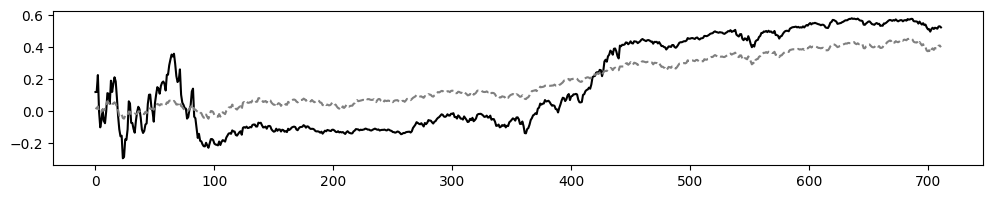

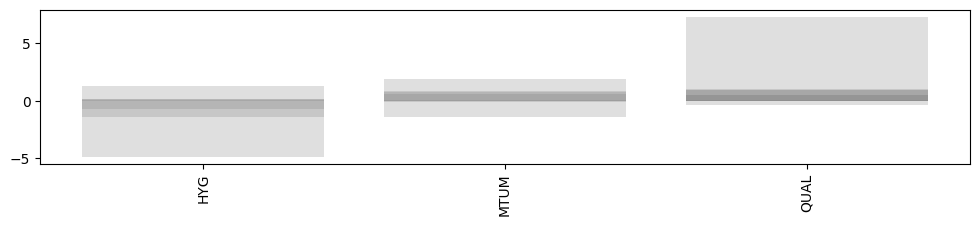

Episode 1/40 epsilon 1


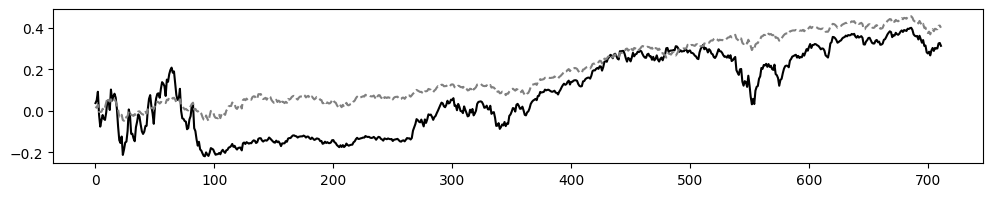

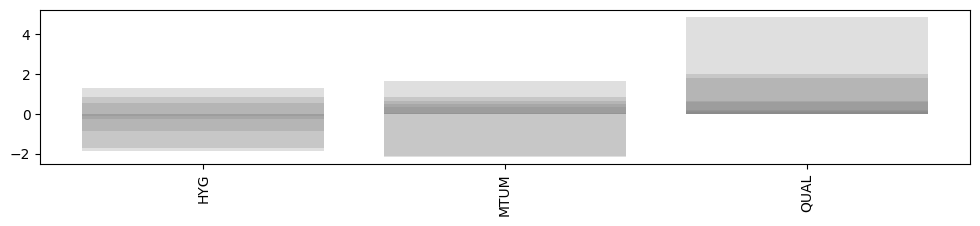

Episode 2/40 epsilon 1


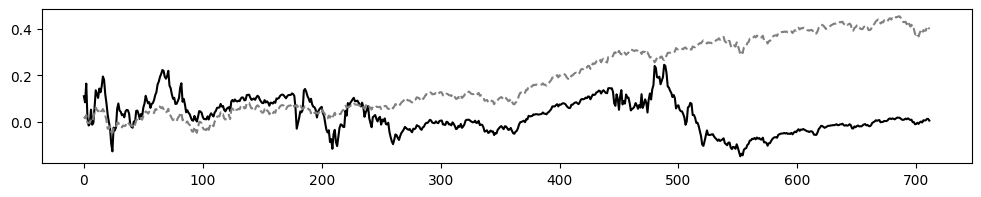

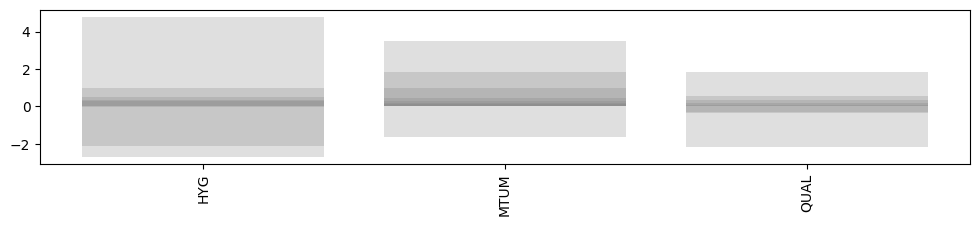

Episode 3/40 epsilon 1


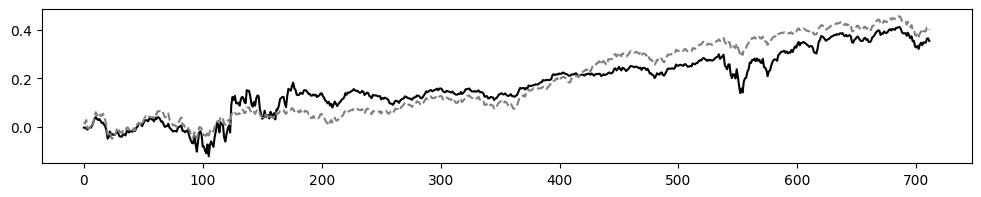

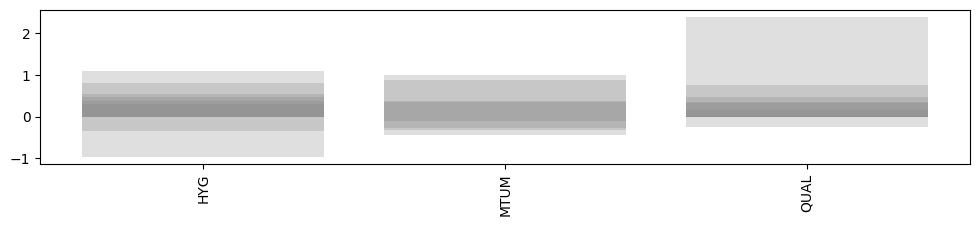

Episode 4/40 epsilon 0.99


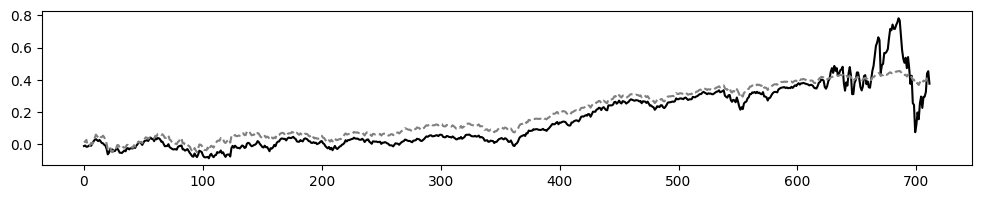

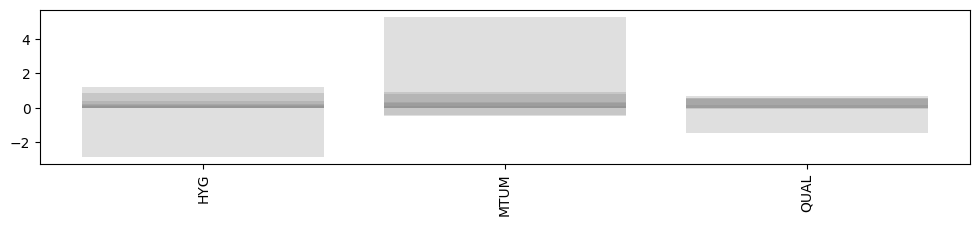

Episode 5/40 epsilon 0.99


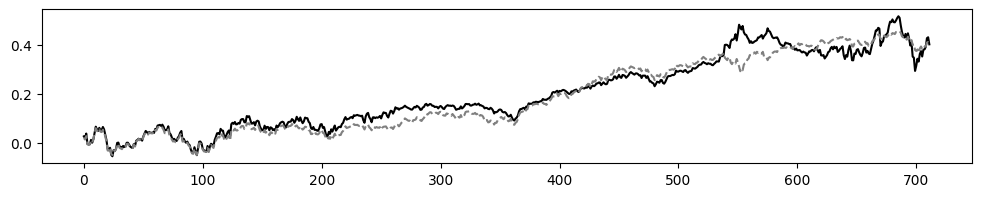

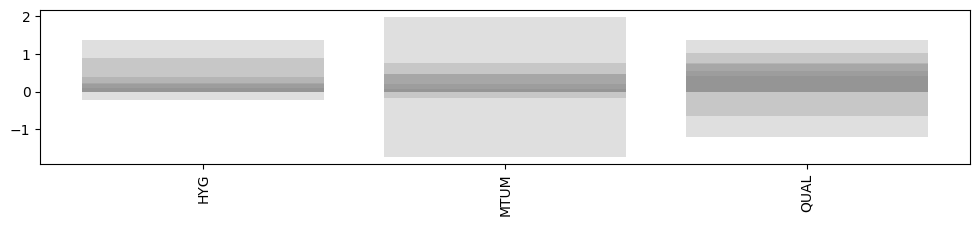

Episode 6/40 epsilon 0.99


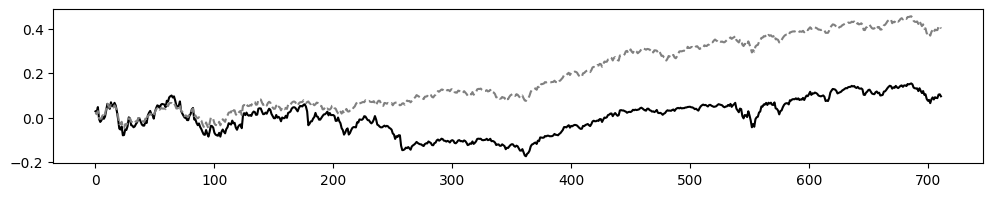

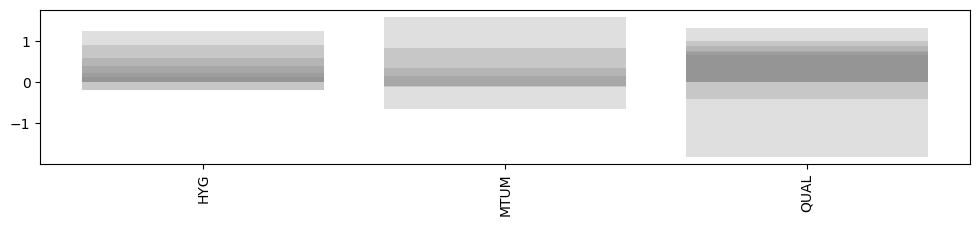

Episode 7/40 epsilon 0.99


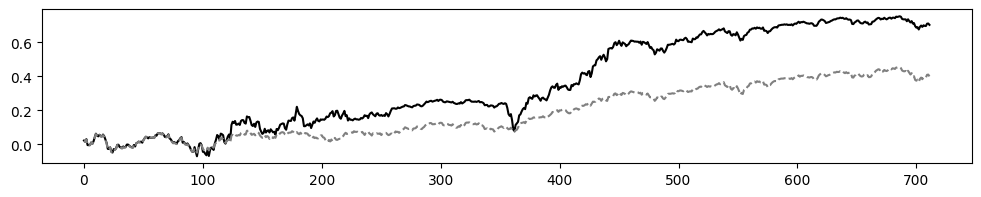

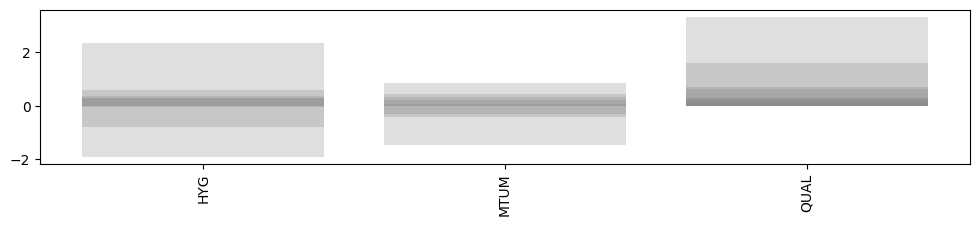

Episode 8/40 epsilon 0.9801


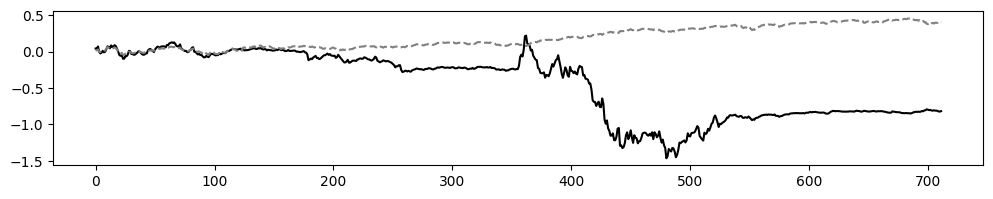

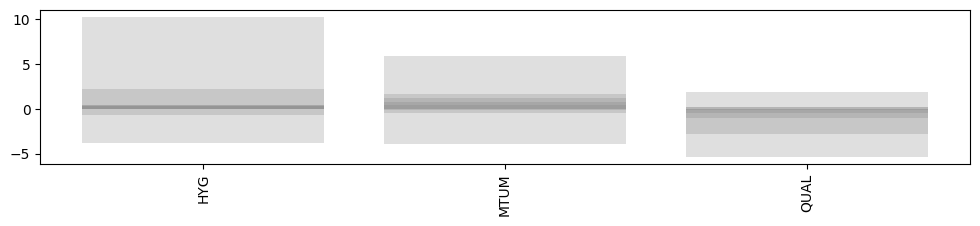

Episode 9/40 epsilon 0.9801


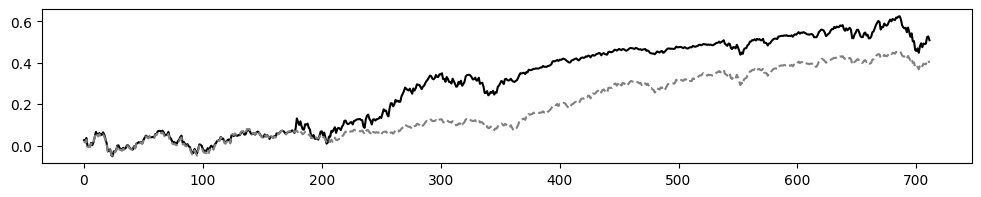

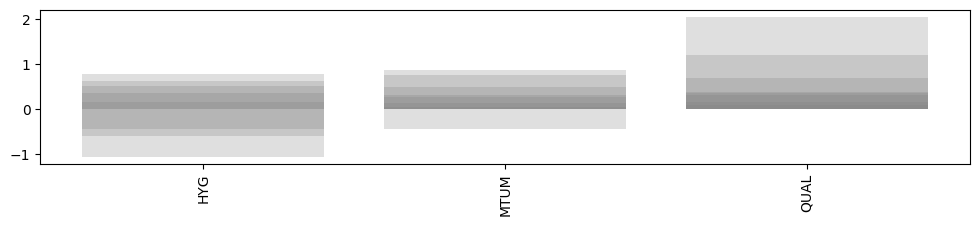

Episode 10/40 epsilon 0.9801


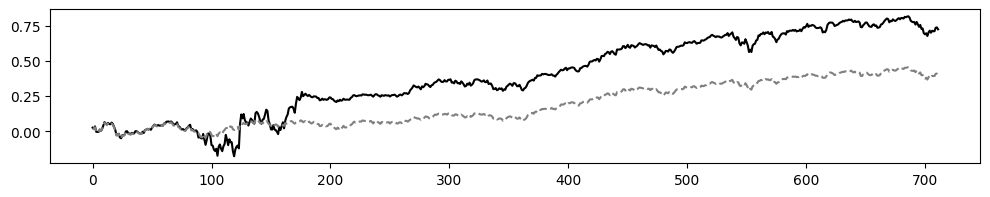

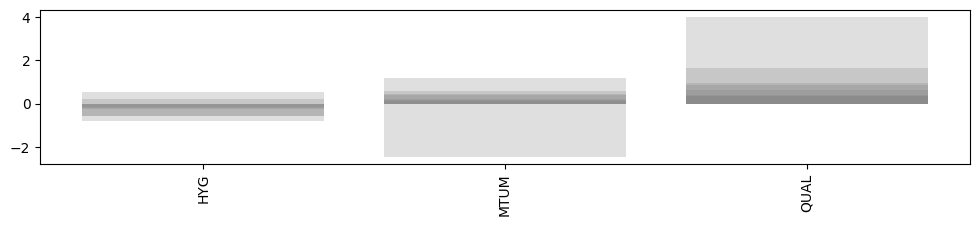

Episode 11/40 epsilon 0.9801


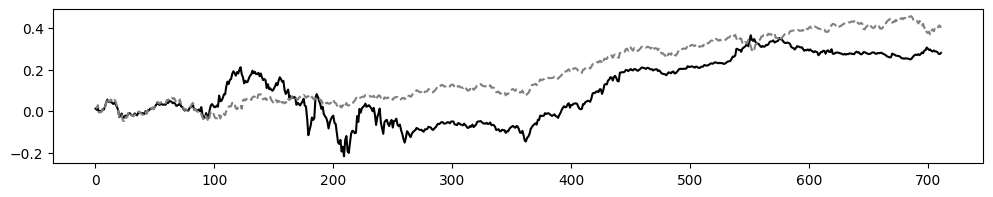

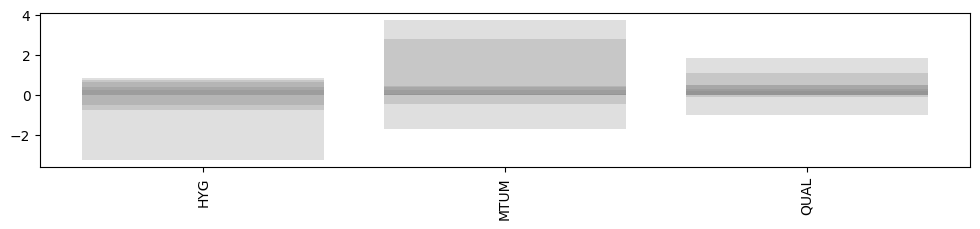

Episode 12/40 epsilon 0.9702989999999999


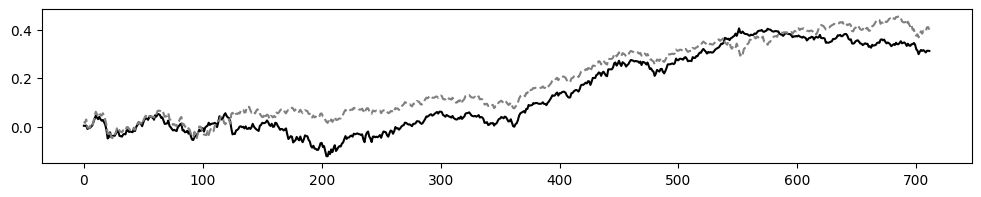

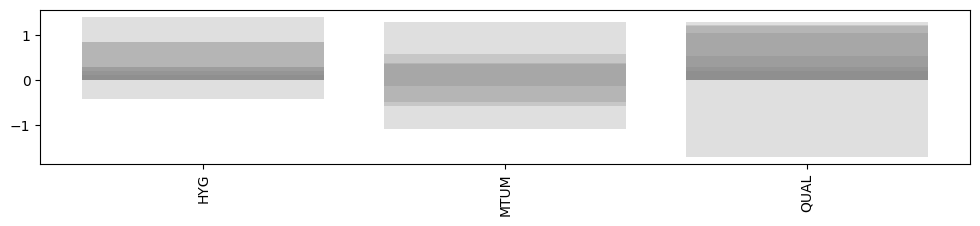

Episode 13/40 epsilon 0.9702989999999999


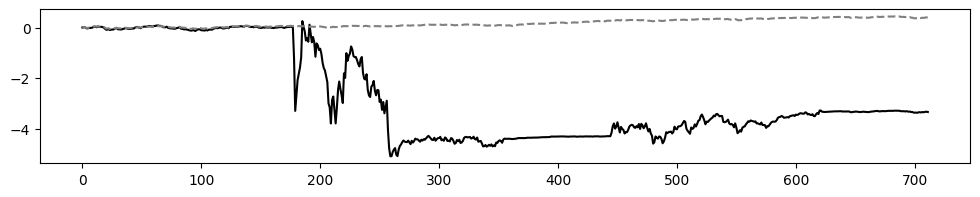

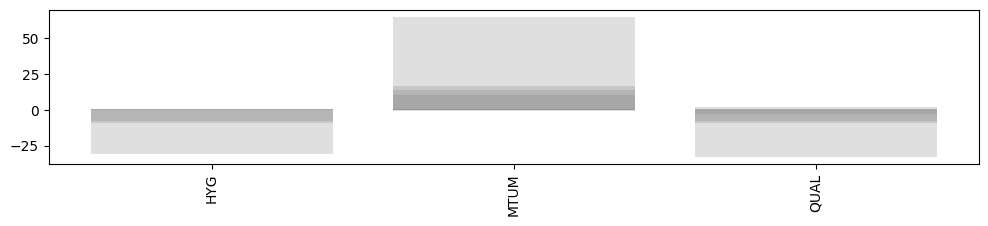

Episode 14/40 epsilon 0.9702989999999999


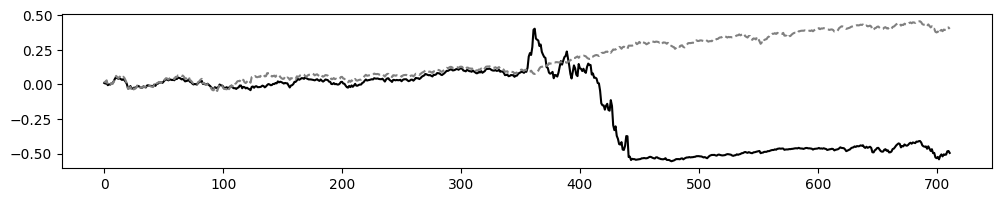

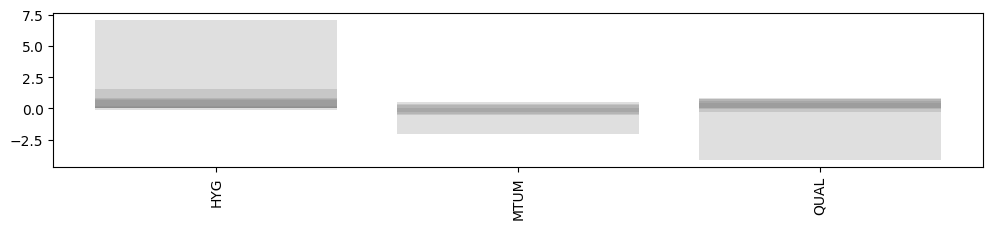

Episode 15/40 epsilon 0.9702989999999999


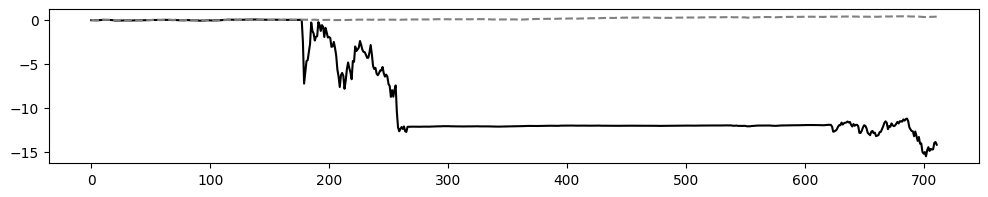

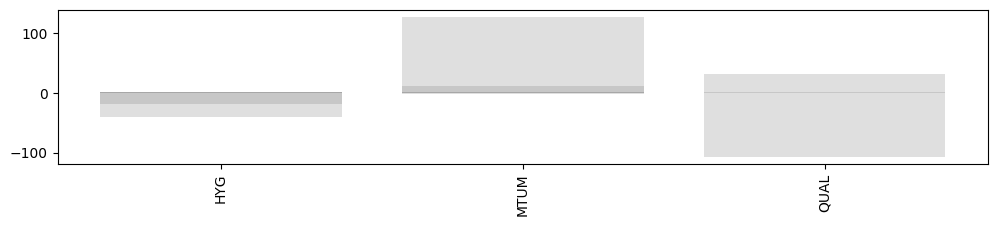

Episode 16/40 epsilon 0.96059601


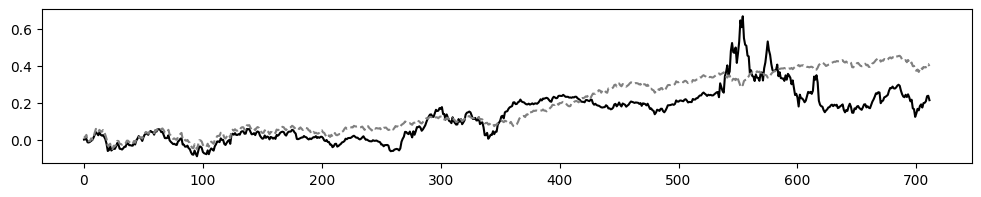

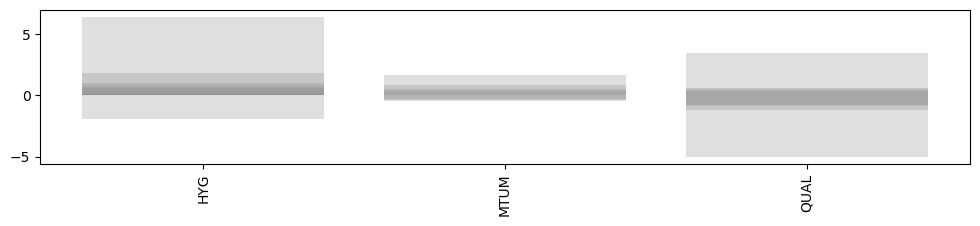

Episode 17/40 epsilon 0.96059601


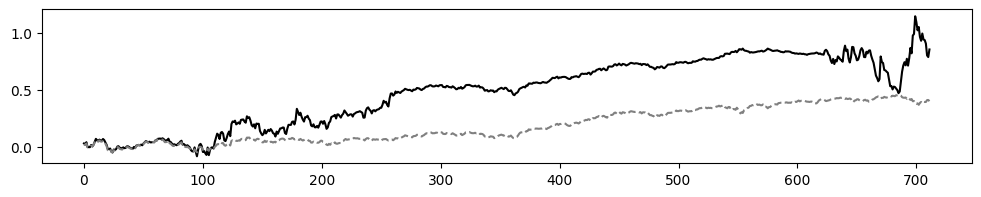

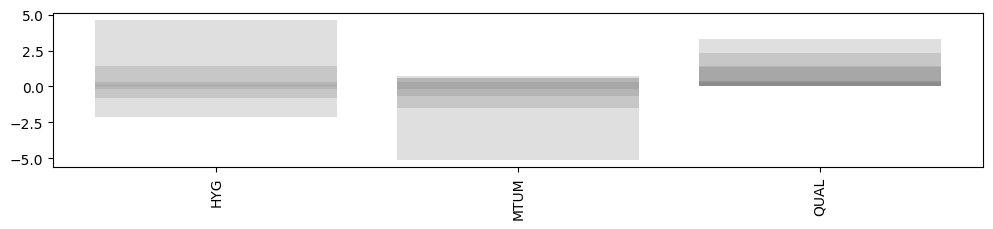

Episode 18/40 epsilon 0.96059601


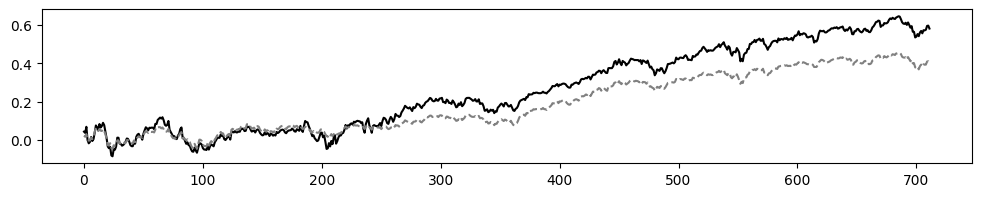

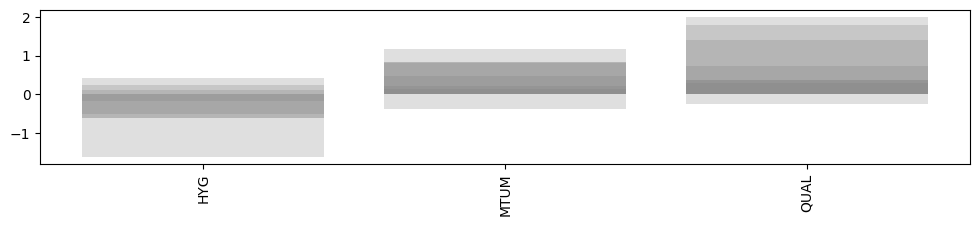

Episode 19/40 epsilon 0.96059601


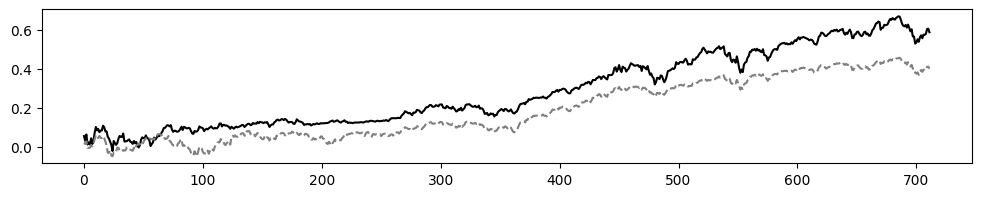

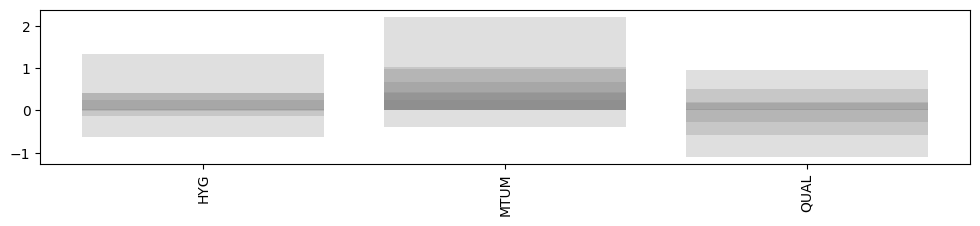

Episode 20/40 epsilon 0.9509900498999999


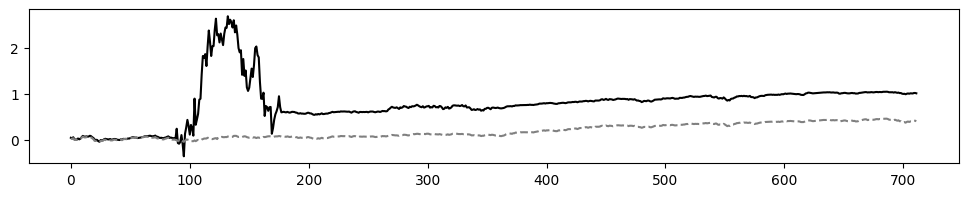

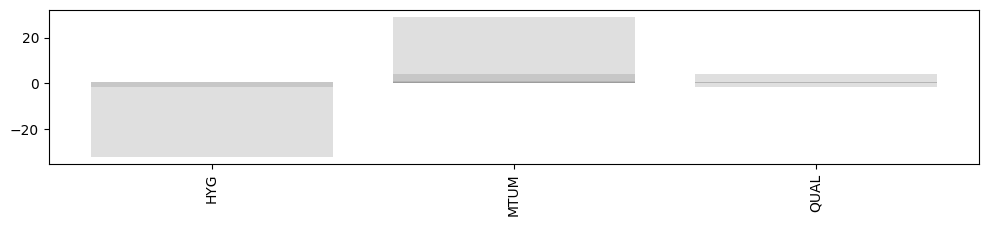

Episode 21/40 epsilon 0.9509900498999999


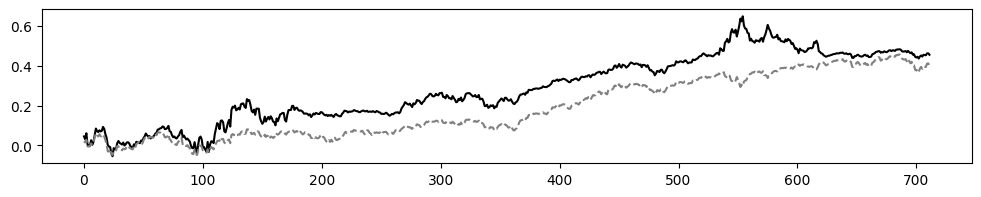

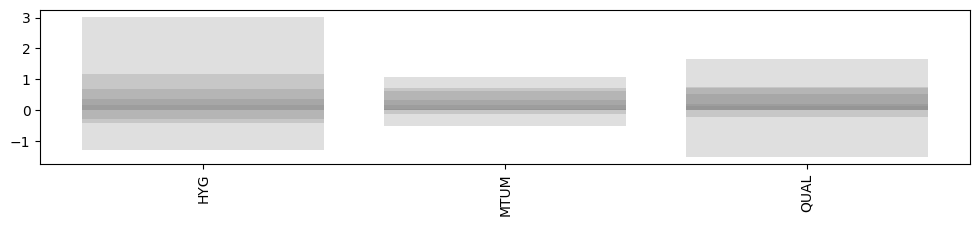

Episode 22/40 epsilon 0.9509900498999999


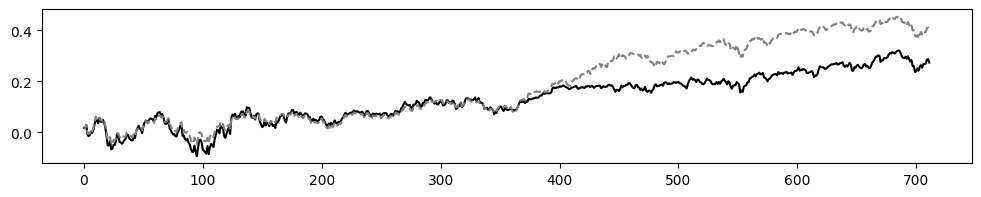

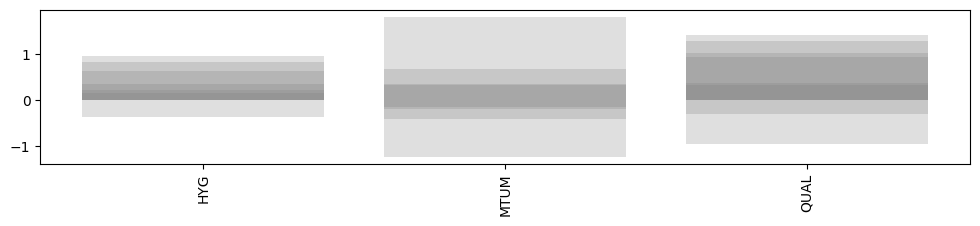

Episode 23/40 epsilon 0.9509900498999999


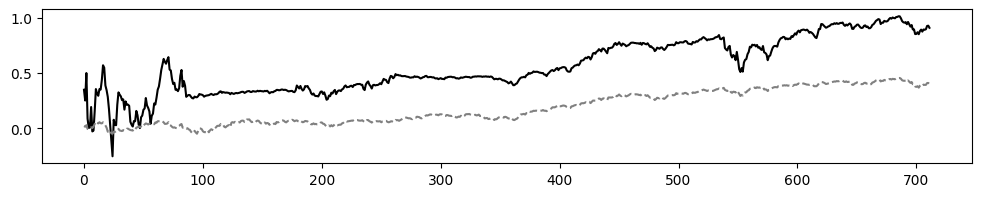

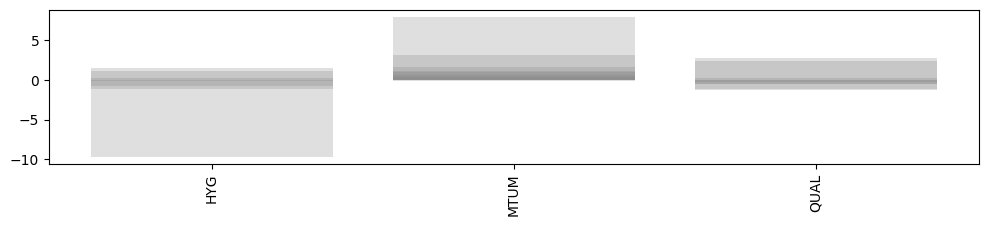

Episode 24/40 epsilon 0.9414801494009999


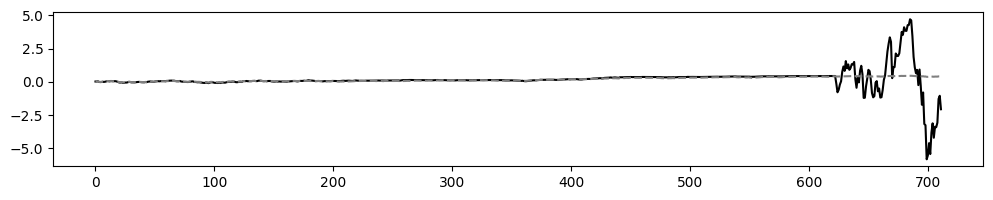

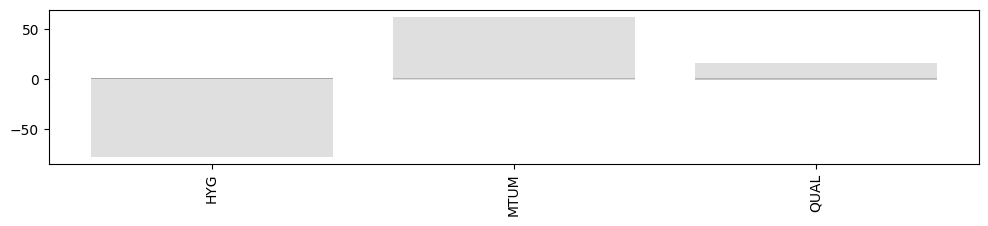

Episode 25/40 epsilon 0.9414801494009999


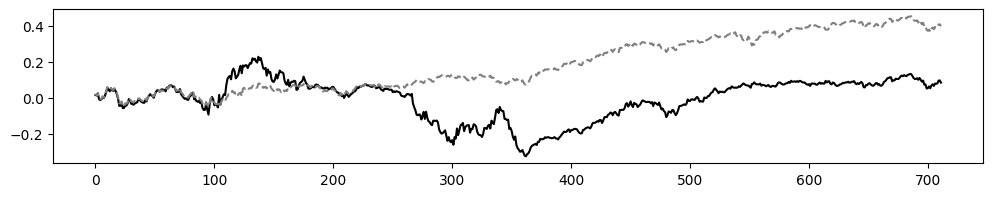

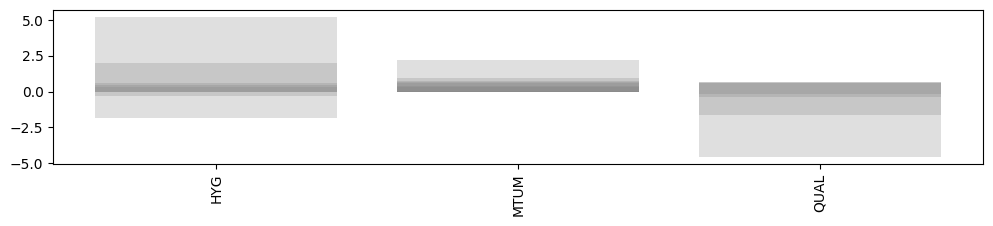

Episode 26/40 epsilon 0.9414801494009999


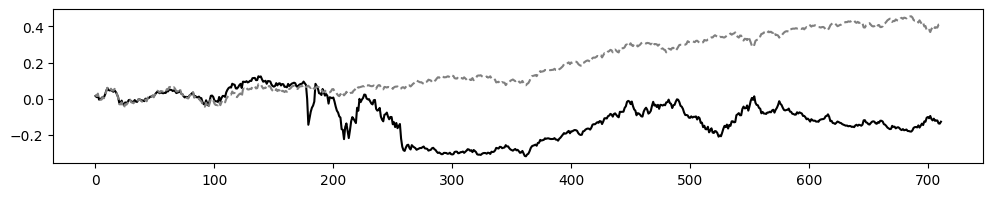

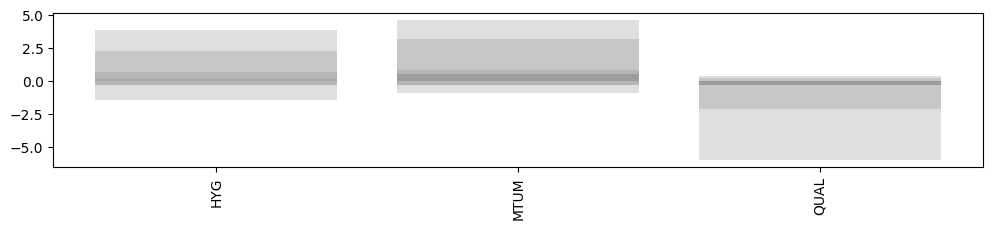

Episode 27/40 epsilon 0.9414801494009999


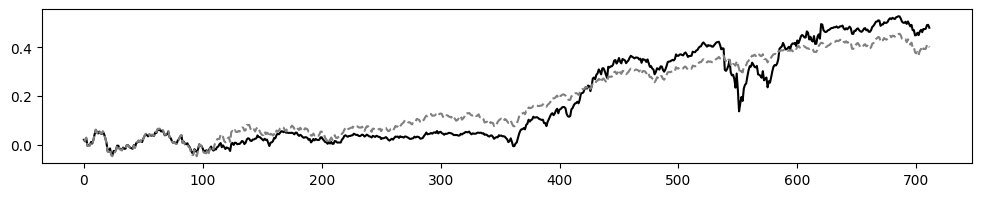

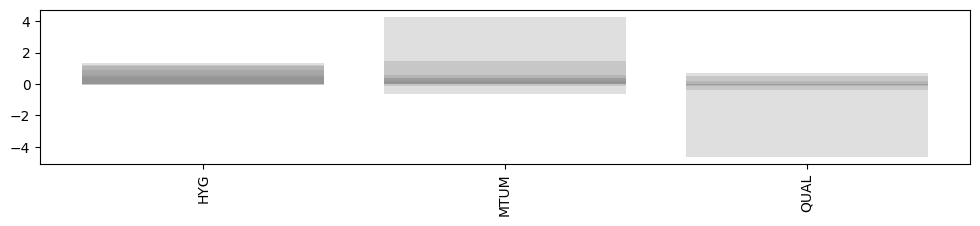

Episode 28/40 epsilon 0.9320653479069899


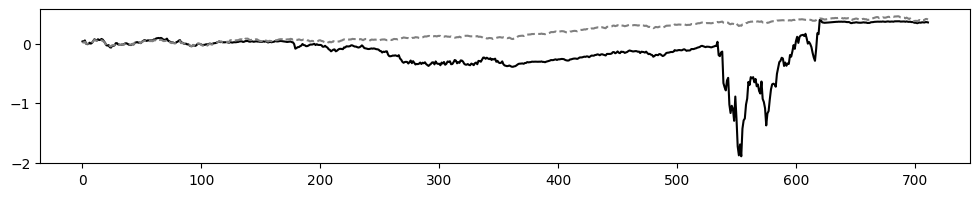

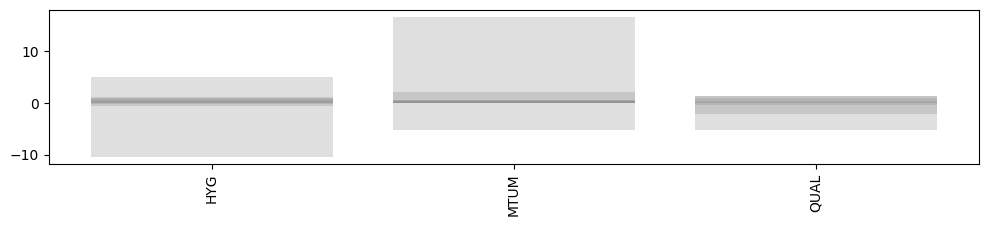

Episode 29/40 epsilon 0.9320653479069899


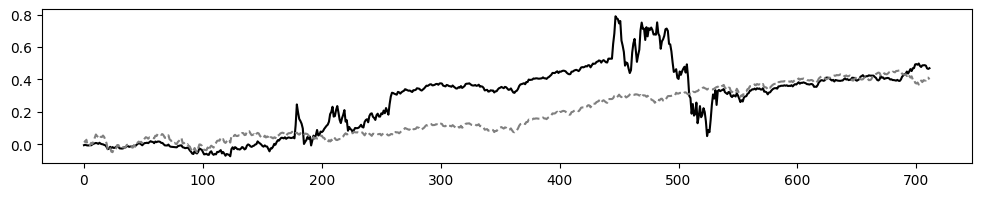

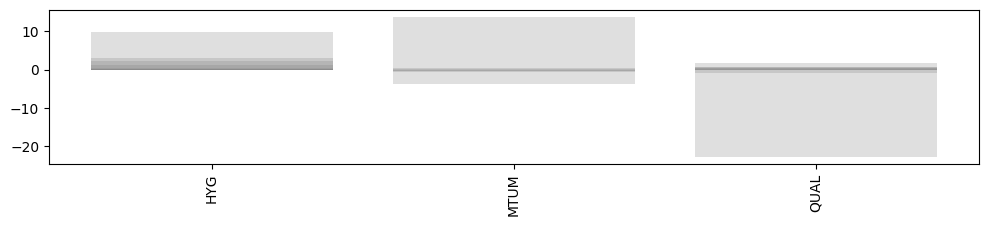

Episode 30/40 epsilon 0.9320653479069899


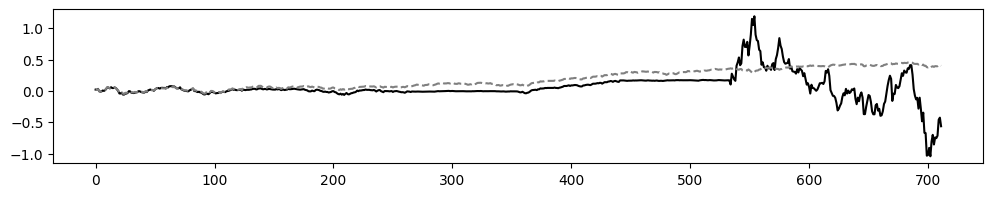

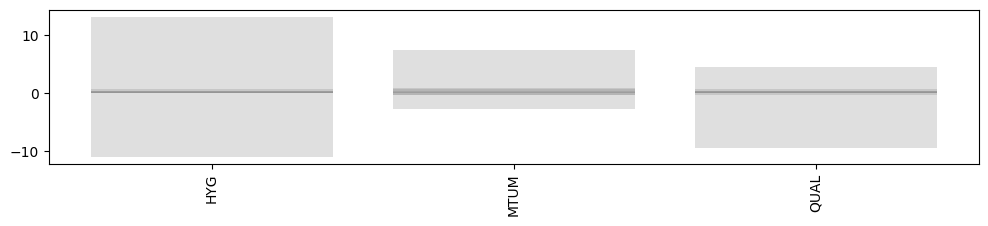

Episode 31/40 epsilon 0.9320653479069899


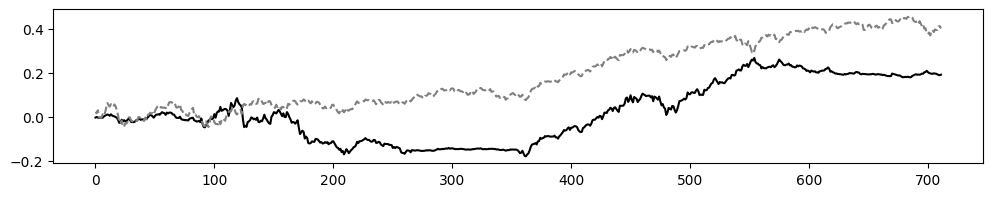

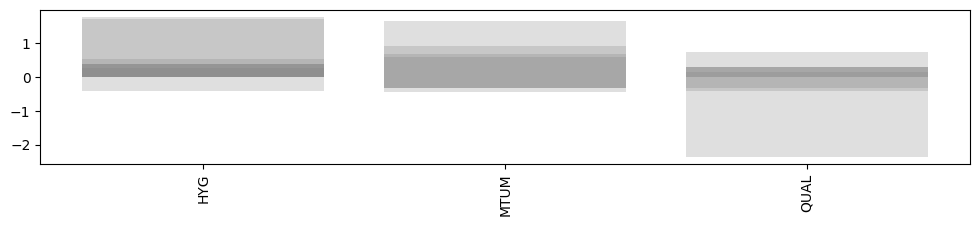

Episode 32/40 epsilon 0.92274469442792


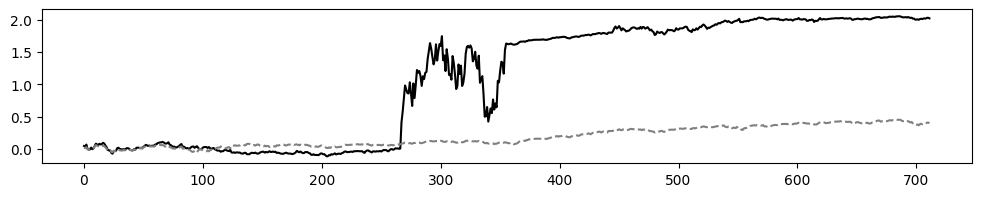

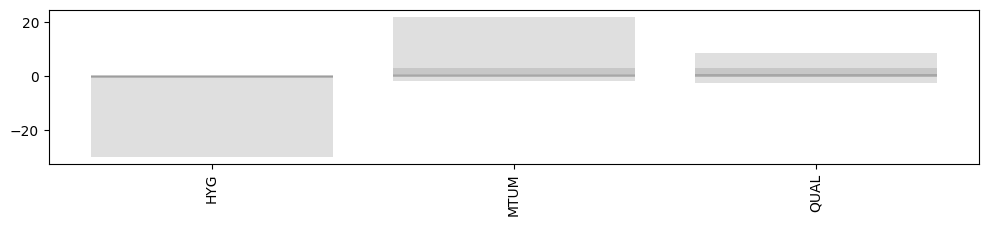

Episode 33/40 epsilon 0.92274469442792


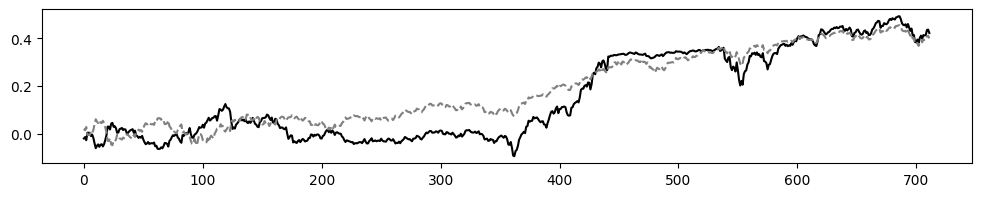

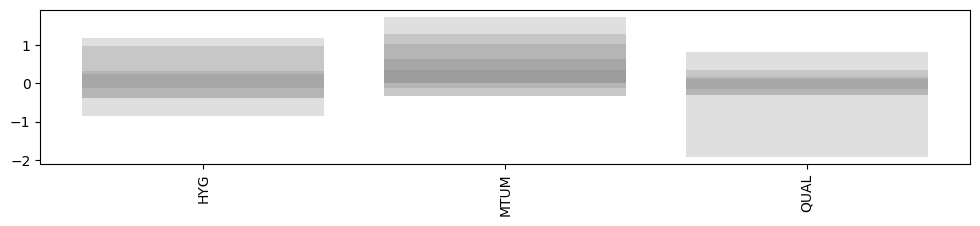

Episode 34/40 epsilon 0.92274469442792


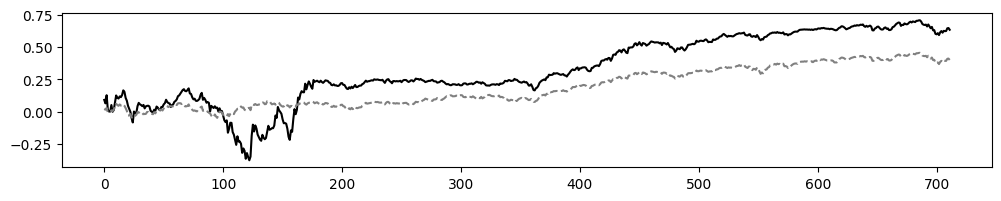

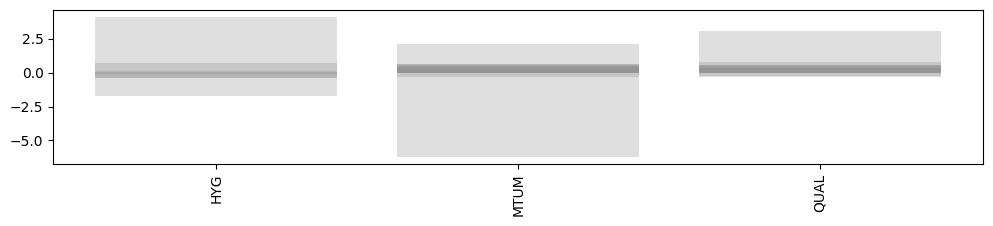

Episode 35/40 epsilon 0.92274469442792


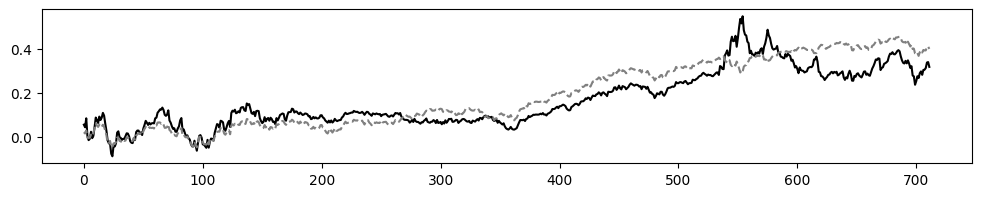

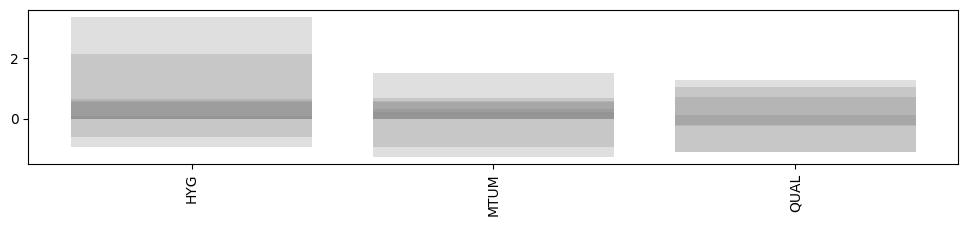

Episode 36/40 epsilon 0.9135172474836407


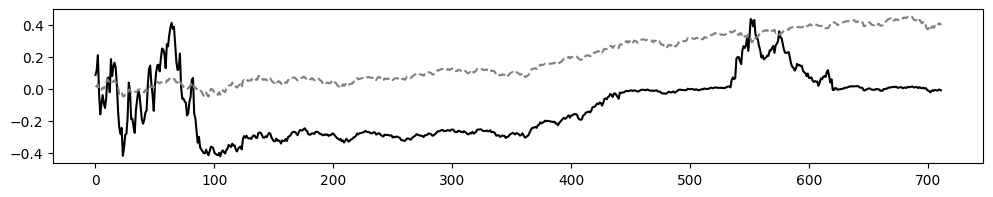

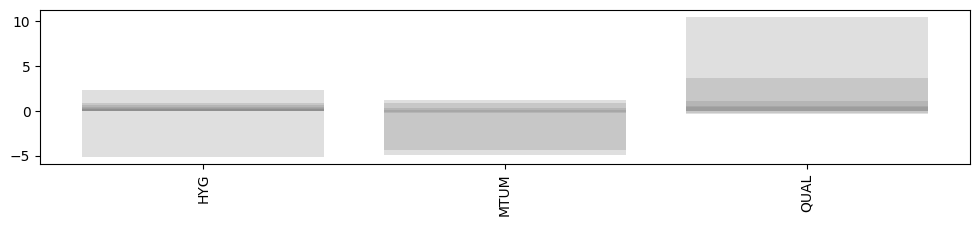

Episode 37/40 epsilon 0.9135172474836407


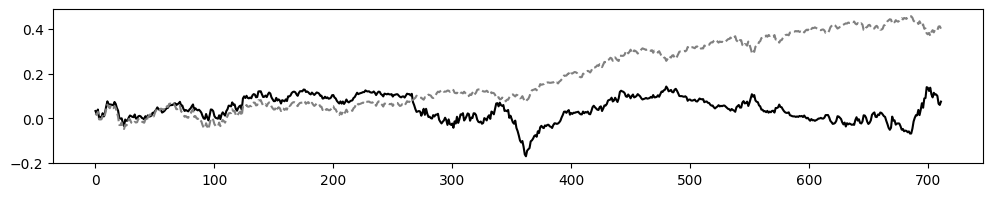

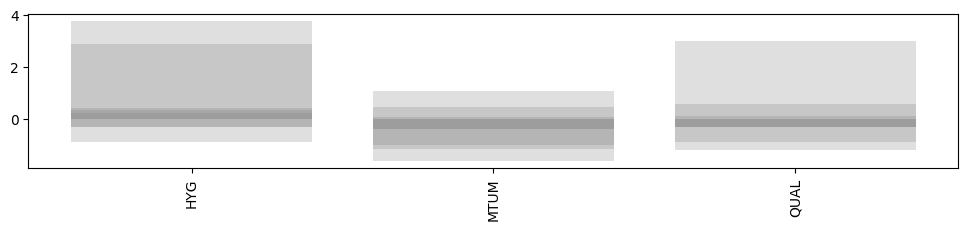

Episode 38/40 epsilon 0.9135172474836407


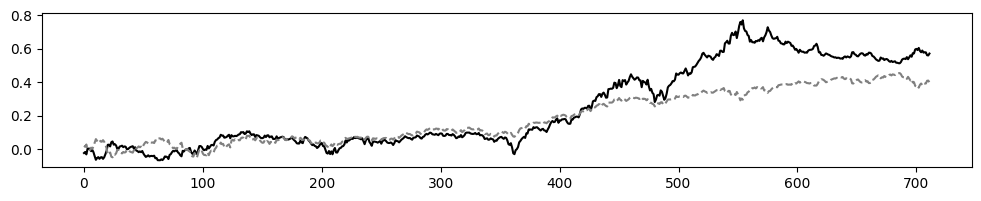

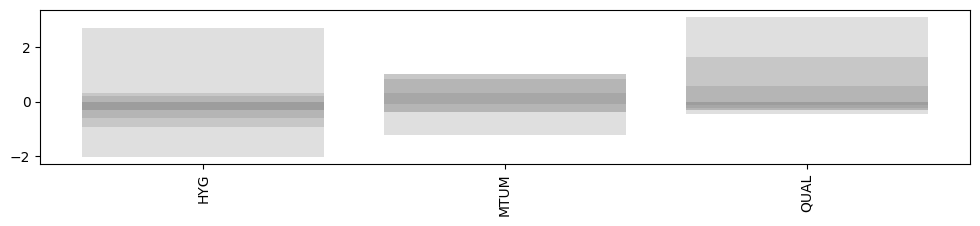

Episode 39/40 epsilon 0.9135172474836407


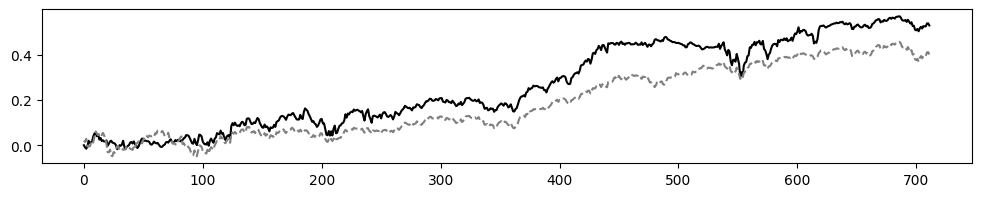

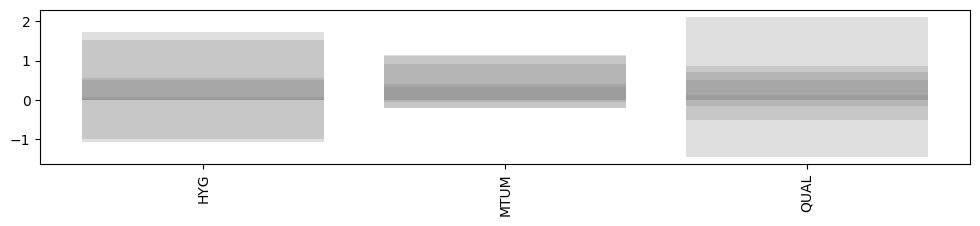

In [16]:
tf.keras.utils.disable_interactive_logging()
for e in range(episode_count):

    agent.is_eval = False
    data_length = len(env.data)

    returns_history = []
    returns_history_equal = []

    rewards_history = []
    equal_rewards = []

    actions_to_show = []

    print("Episode " + str(e) + "/" + str(episode_count), 'epsilon', agent.epsilon)

    s = env.get_state(np.random.randint(window_size+1, data_length-window_size-1), window_size)
    total_profit = 0

    for t in range(window_size, data_length, rebalance_period):
        date1 = t-rebalance_period
        #correlation from 90-180 days
        s_ = env.get_state(t, window_size)
        action = agent.act(s_)

        actions_to_show.append(action[0])

        weighted_returns, reward = env.get_reward(action[0], date1, t)
        weighted_returns_equal, reward_equal = env.get_reward(
            np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

        rewards_history.append(reward)
        equal_rewards.append(reward_equal)
        returns_history.extend(weighted_returns)
        returns_history_equal.extend(weighted_returns_equal)

        done = True if t == data_length else False
        agent.memory4replay.append((s, s_, action, reward, done))

        if len(agent.memory4replay) >= batch_size:
            agent.expReplay(batch_size)
            agent.memory4replay = []

        s = s_

    rl_result = np.array(returns_history).cumsum()
    equal_result = np.array(returns_history_equal).cumsum()

    plt.figure(figsize = (12, 2))
    plt.plot(rl_result, color = 'black', ls = '-')
    plt.plot(equal_result, color = 'grey', ls = '--')
    plt.show()

    plt.figure(figsize = (12, 2))
    for a in actions_to_show:
        plt.bar(np.arange(N_ASSETS), a, color = 'grey', alpha = 0.25)
        plt.xticks(np.arange(N_ASSETS), env.data.columns, rotation='vertical')
    plt.show()

In [15]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=edd72620808ff143293035c848238c1450e399e21ef4764355365427b8a649d2
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [17]:
agent.is_eval = True

actions_equal, actions_rl = [], []
result_equal, result_rl = [], []

for t in range(window_size, len(env.data), rebalance_period):

    date1 = t-rebalance_period
    s_ = env.get_state(t, window_size)
    action = agent.act(s_)

    weighted_returns, reward = env.get_reward(action[0], date1, t)
    weighted_returns_equal, reward_equal = env.get_reward(
        np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

    result_equal.append(weighted_returns_equal.tolist())
    actions_equal.append(np.ones(agent.portfolio_size) / agent.portfolio_size)

    result_rl.append(weighted_returns.tolist())
    actions_rl.append(action[0])

In [18]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_rl_vis = [item for sublist in result_rl for item in sublist]

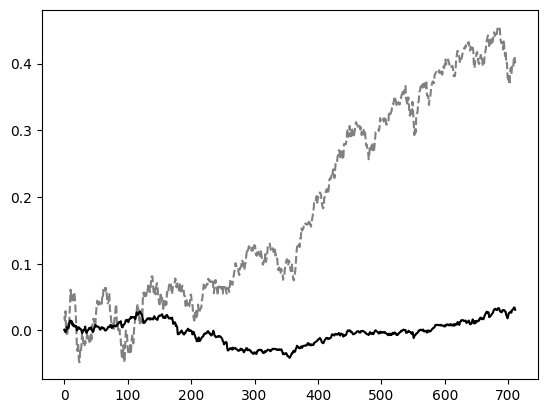

In [23]:
plt.figure()
plt.plot(np.array(result_equal_vis).cumsum(), label = 'Benchmark', color = 'grey',ls = '--')
plt.plot(np.array(result_rl_vis).cumsum(), label = 'Deep RL portfolio', color = 'black',ls = '-')
plt.show()

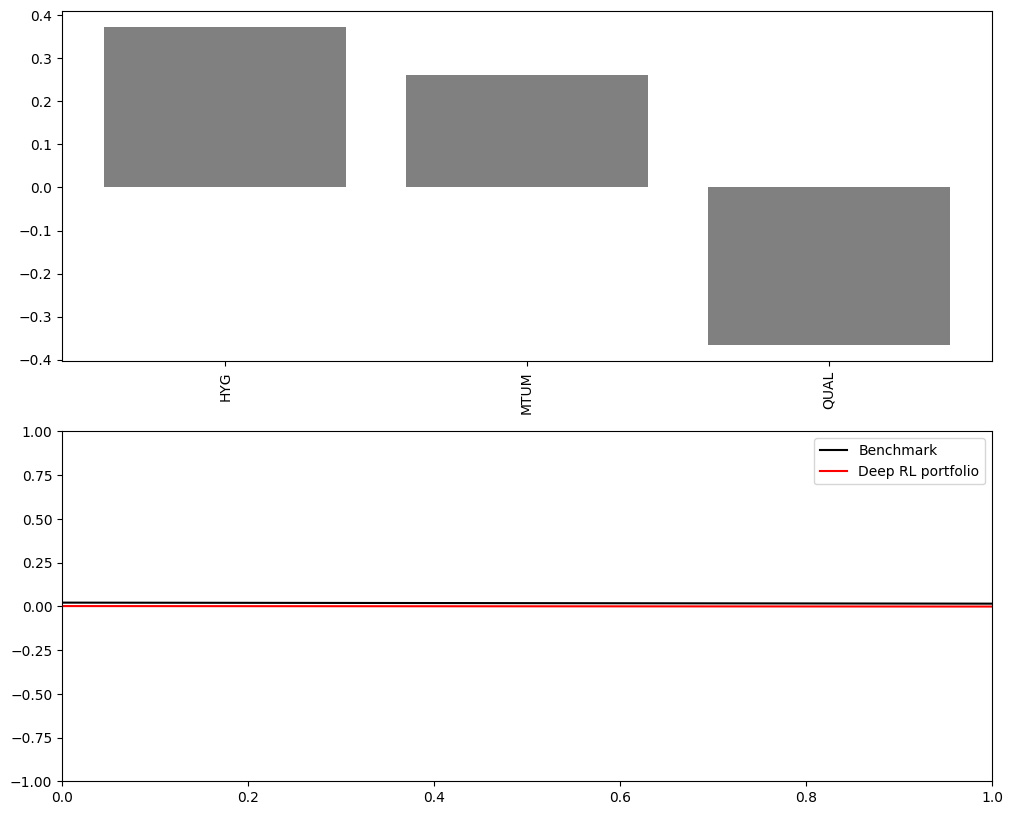

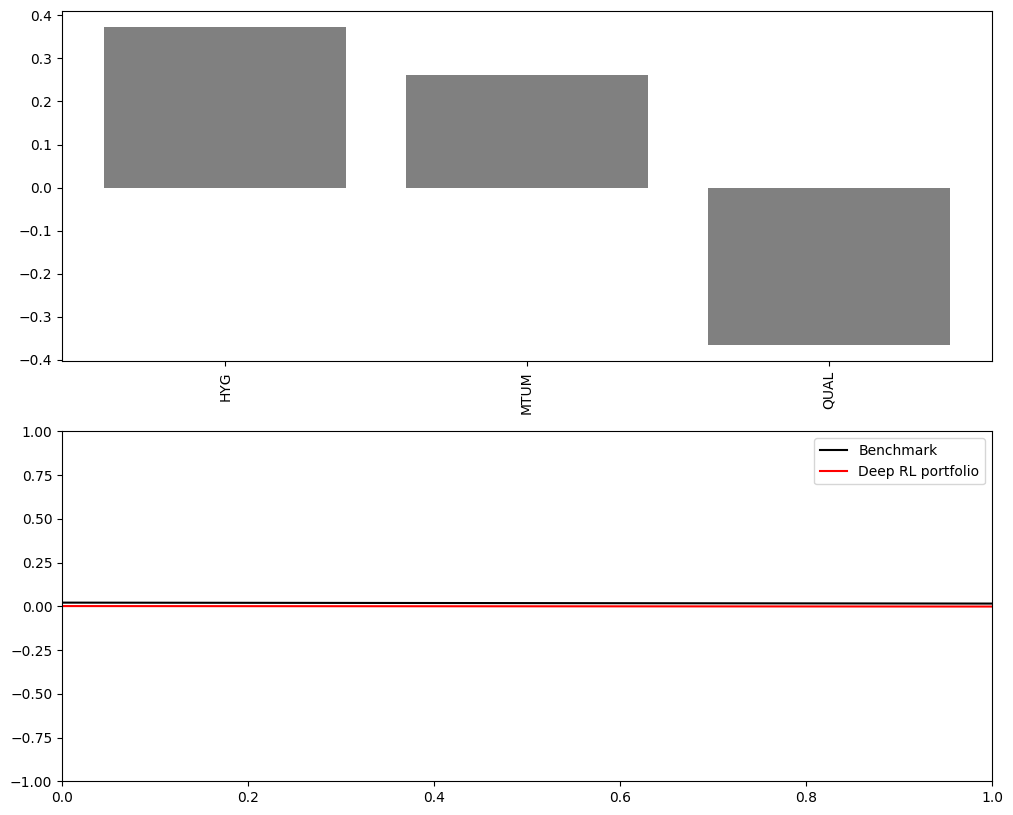

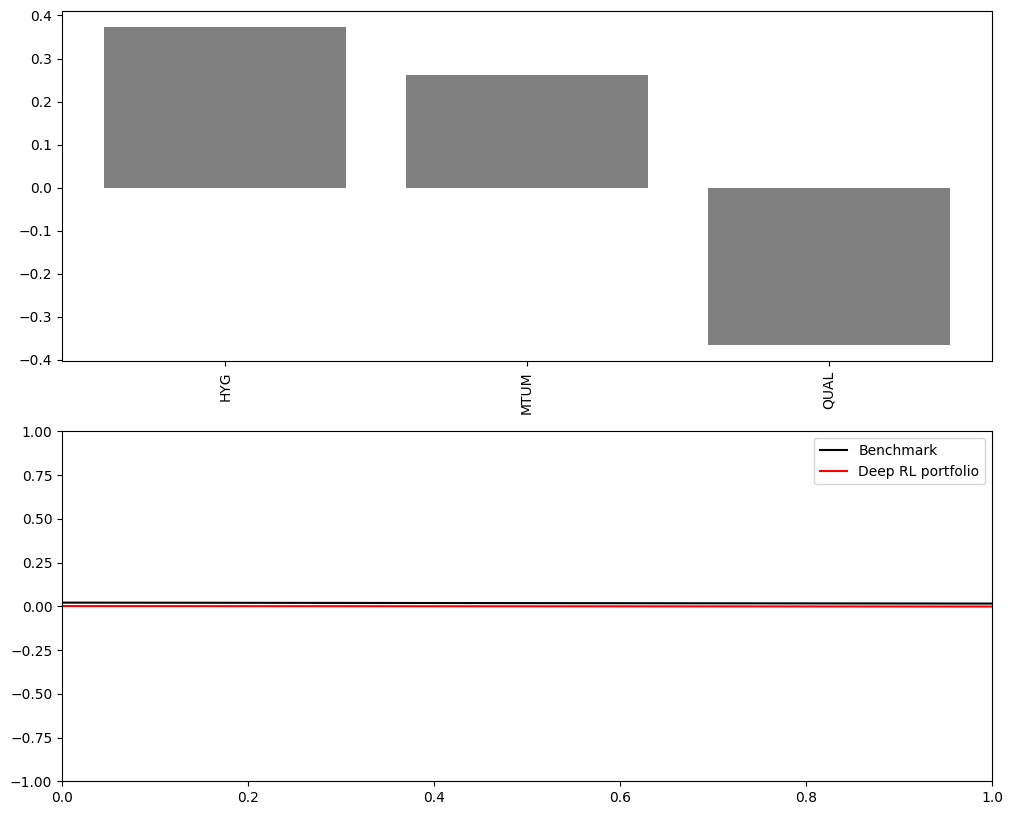

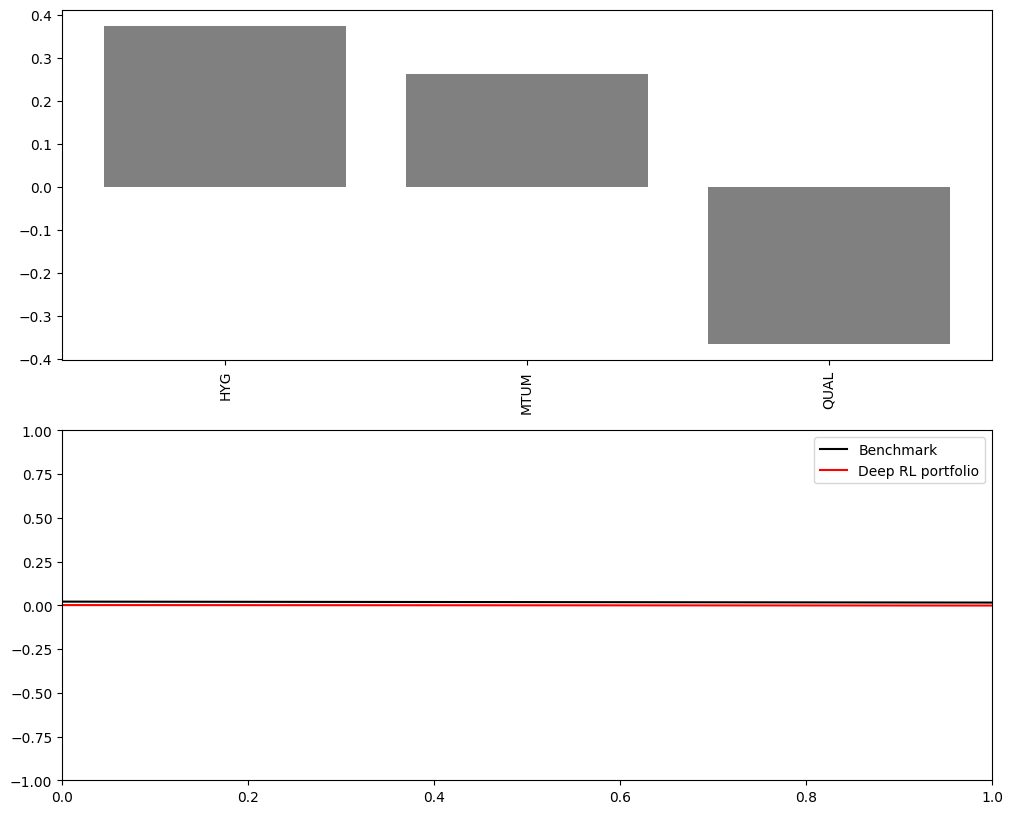

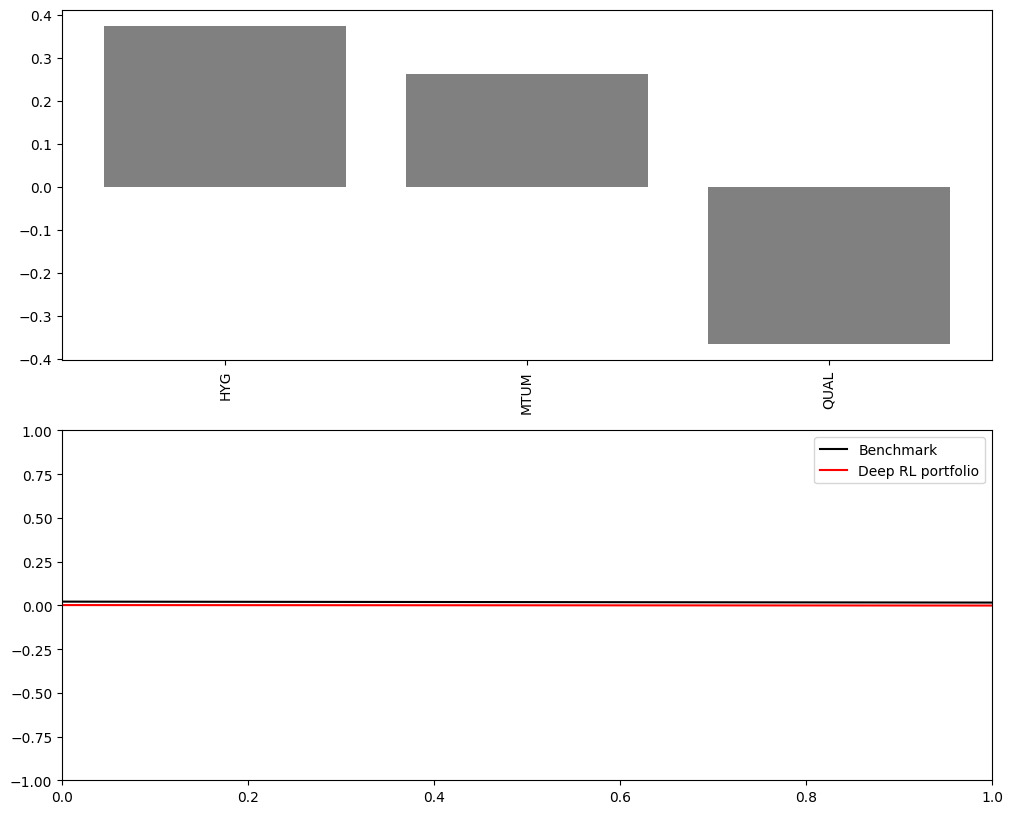

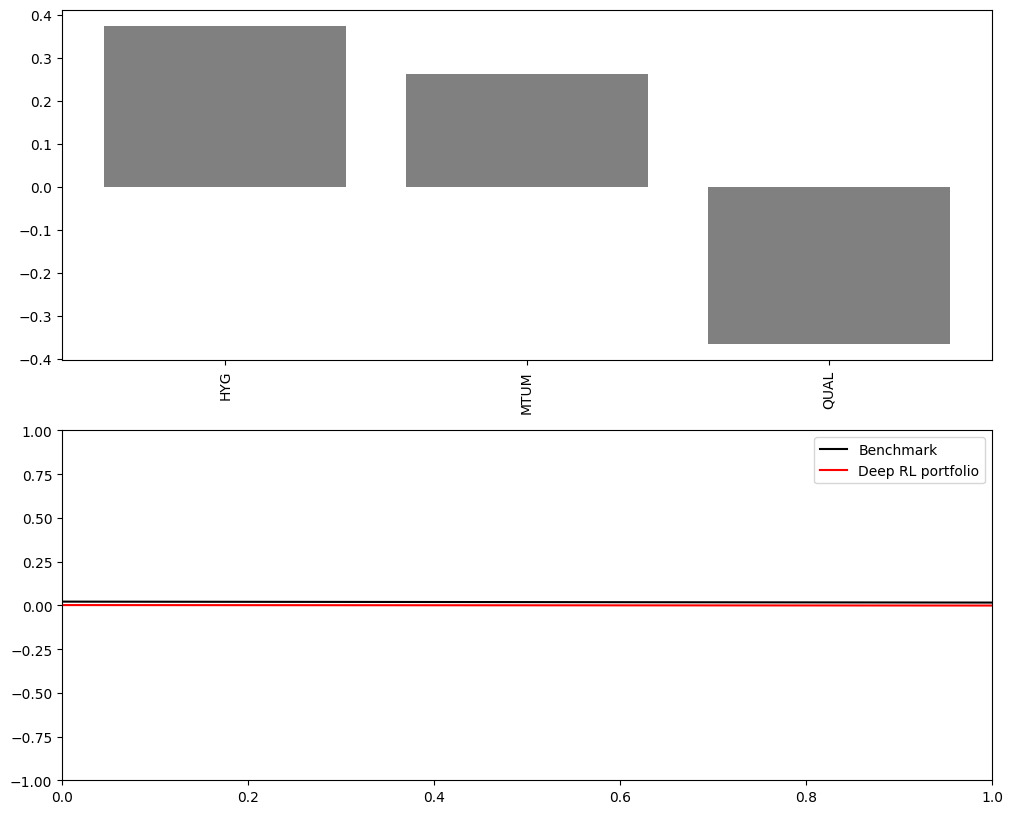

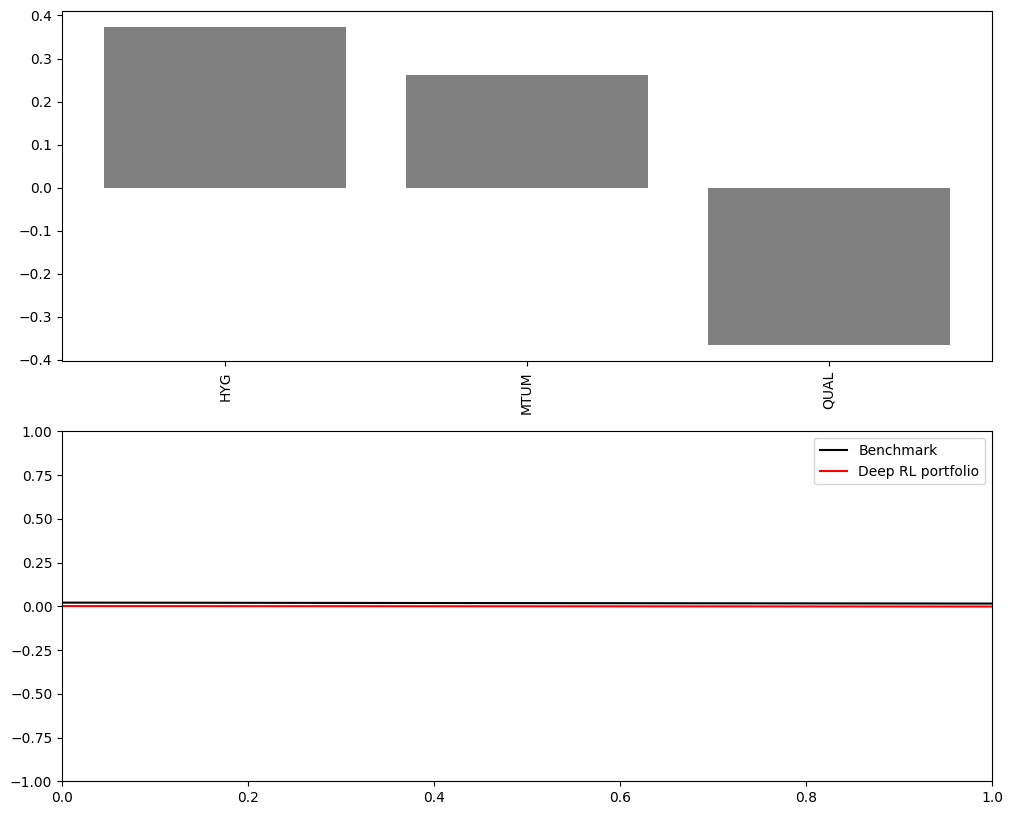

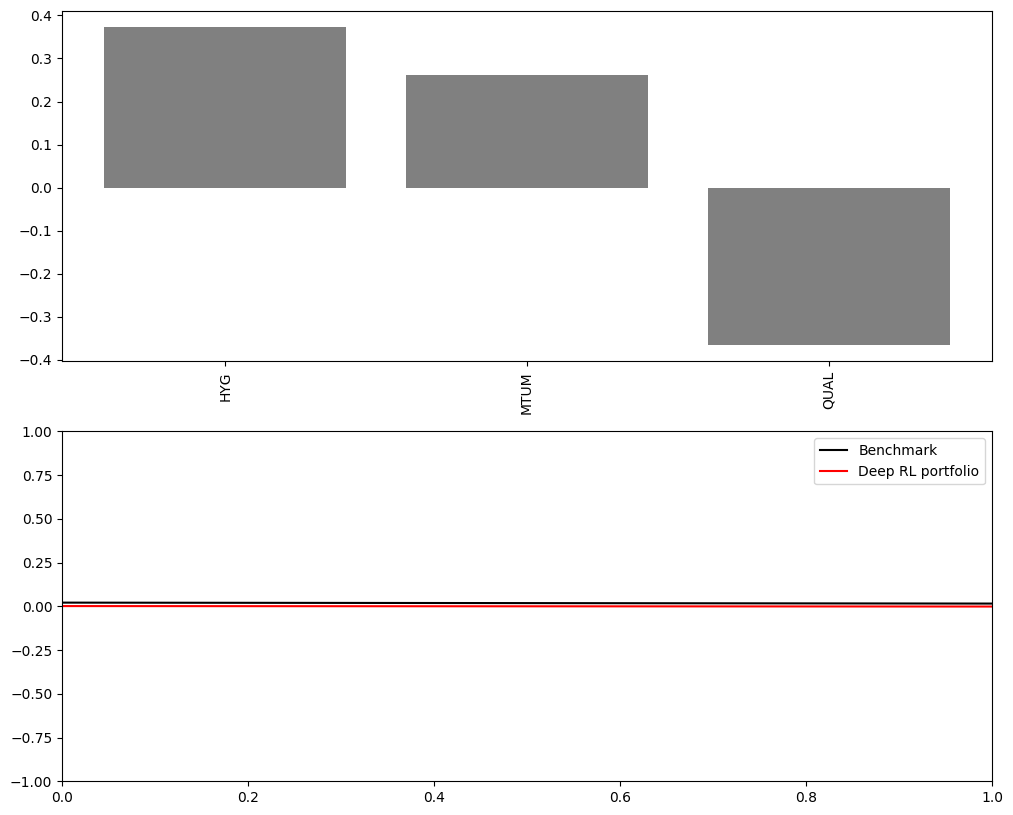

In [20]:
#Plotting the data
import matplotlib
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='red')

N = len(np.array([item for sublist in result_equal for item in sublist]).cumsum())

for i in range(0, len(actions_rl)):
    current_range = np.arange(0, N)
    current_ts = np.zeros(N)
    current_ts2 = np.zeros(N)

    ts_benchmark = np.array([item for sublist in result_equal[:i+1] for item in sublist]).cumsum()
    ts_target = np.array([item for sublist in result_rl[:i+1] for item in sublist]).cumsum()

    t = len(ts_benchmark)
    current_ts[:t] = ts_benchmark
    current_ts2[:t] = ts_target

    current_ts[current_ts == 0] = ts_benchmark[-1]
    current_ts2[current_ts2 == 0] = ts_target[-1]

    plt.figure(figsize = (12, 10))

    plt.subplot(2, 1, 1)
    plt.bar(np.arange(N_ASSETS), actions_rl[i], color = 'grey')
    plt.xticks(np.arange(N_ASSETS), env.data.columns, rotation='vertical')

    plt.subplot(2, 1, 2)
    plt.colormaps = current_cmap
    plt.plot(current_range[:t], current_ts[:t], color = 'black', label = 'Benchmark')
    plt.plot(current_range[:t], current_ts2[:t], color = 'red', label = 'Deep RL portfolio')
    plt.plot(current_range[t:], current_ts[t:], ls = '--', lw = .1, color = 'black')
    plt.autoscale(False)
    plt.ylim([-1, 1])
    plt.legend()

In [21]:
import statsmodels.api as sm
from statsmodels import regression
def sharpe(R):
    r = np.diff(R)
    sr = r.mean()/r.std() * np.sqrt(252)
    return sr

def print_stats(result, benchmark):

    sharpe_ratio = sharpe(np.array(result).cumsum())
    returns = np.mean(np.array(result))
    volatility = np.std(np.array(result))

    X = benchmark
    y = result
    x = sm.add_constant(X)
    model = regression.linear_model.OLS(y, x).fit()
    alpha = model.params[0]
    beta = model.params[1]

    return np.round(np.array([returns, volatility, sharpe_ratio, alpha, beta]), 4).tolist()

In [22]:
print('benchmark', print_stats(result_equal_vis, result_equal_vis))
print('RL AGENT', print_stats(result_rl_vis, result_equal_vis))

benchmark [0.0006, 0.0084, 1.0134, -0.0, 1.0]
RL AGENT [0.0, 0.0019, 0.3417, 0.0, 0.0585]


Portfolio size: 3
Data shape: (871, 3)
TensorFlow available: True
Data splits - Train: 0-609, Val: 609-740, Test: 740-871
Episode 1/100, epsilon: 1.0000


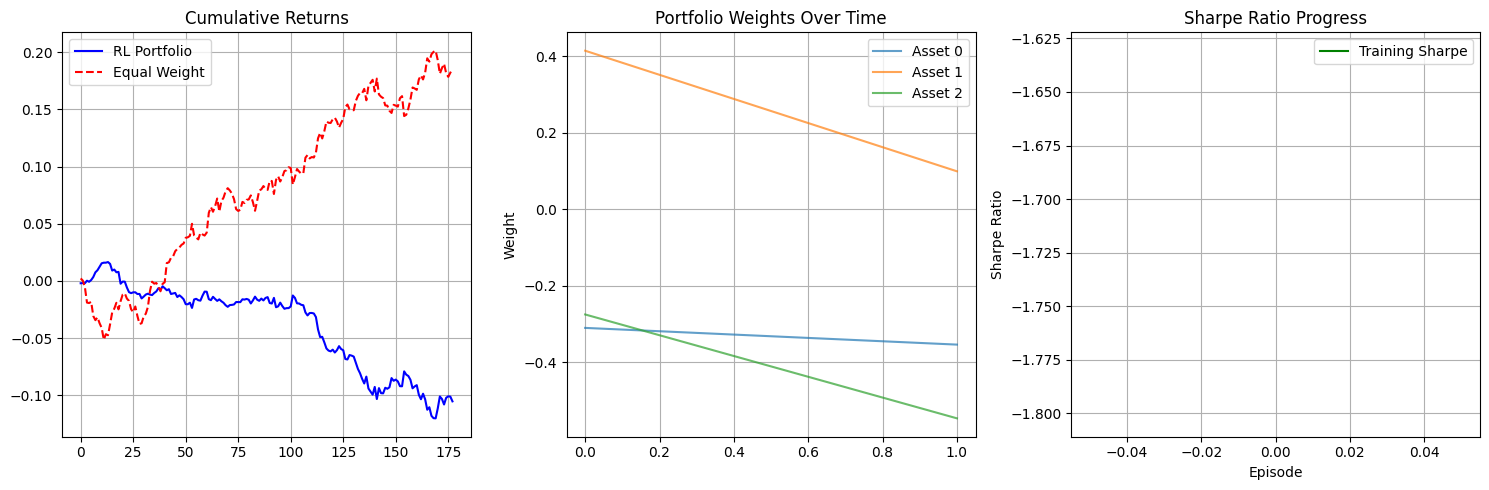

Episode 2/100, epsilon: 1.0000
Episode 3/100, epsilon: 1.0000
Episode 4/100, epsilon: 1.0000
Episode 5/100, epsilon: 1.0000
Episode 6/100, epsilon: 1.0000
Episode 7/100, epsilon: 1.0000
Episode 8/100, epsilon: 1.0000
Episode 9/100, epsilon: 1.0000
Episode 10/100, epsilon: 1.0000
Episode 11/100, epsilon: 1.0000


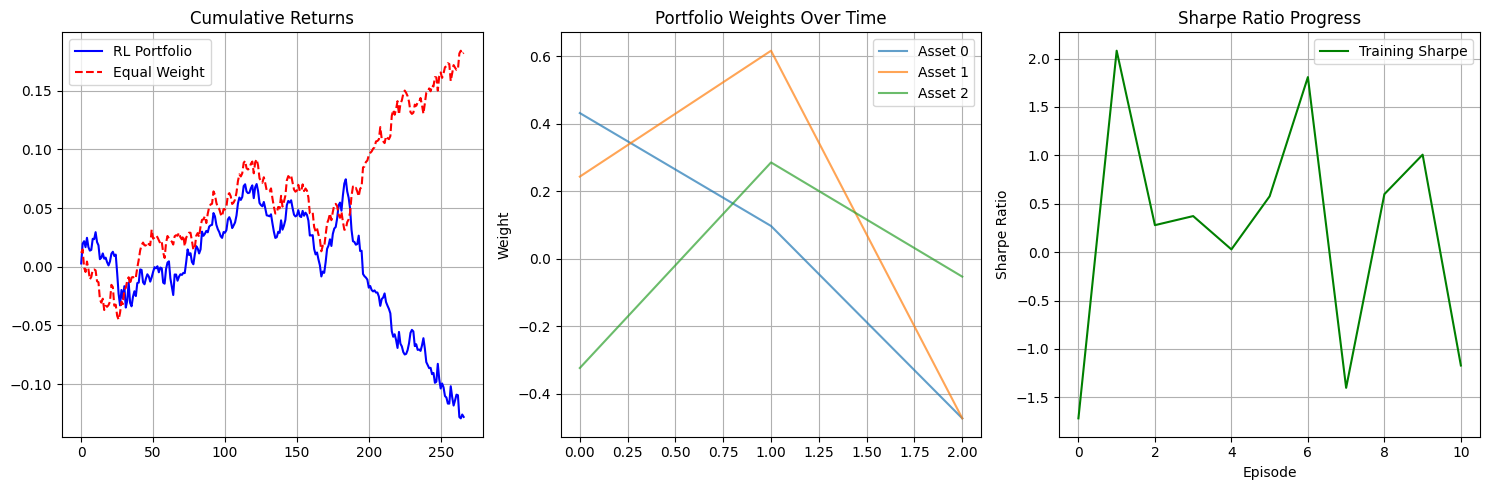

Episode 12/100, epsilon: 1.0000
Episode 13/100, epsilon: 0.9851
Episode 14/100, epsilon: 0.9655
Episode 15/100, epsilon: 0.9464
Episode 16/100, epsilon: 0.9276
Episode 17/100, epsilon: 0.9183
Episode 18/100, epsilon: 0.9001
Episode 19/100, epsilon: 0.8867
Episode 20/100, epsilon: 0.8734
Episode 21/100, epsilon: 0.8604


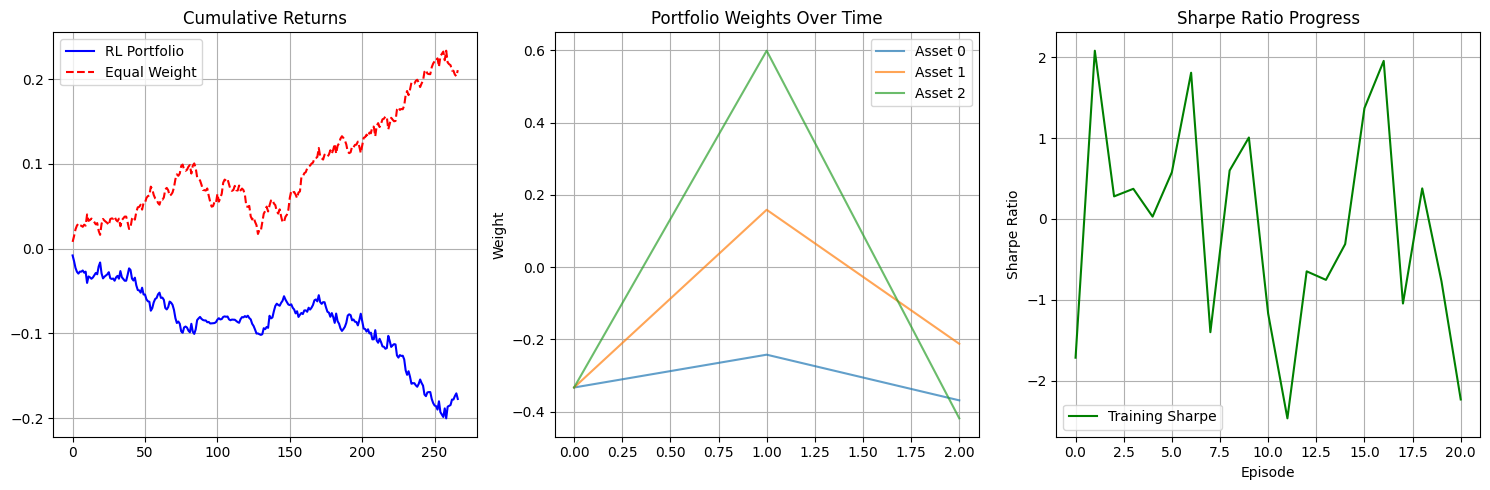

Episode 22/100, epsilon: 0.8475
Episode 23/100, epsilon: 0.8349
Episode 24/100, epsilon: 0.8183
Episode 25/100, epsilon: 0.8061
Episode 26/100, epsilon: 0.7981
Episode 27/100, epsilon: 0.7822
Episode 28/100, epsilon: 0.7705
Episode 29/100, epsilon: 0.7629
Episode 30/100, epsilon: 0.7515
Episode 31/100, epsilon: 0.7403


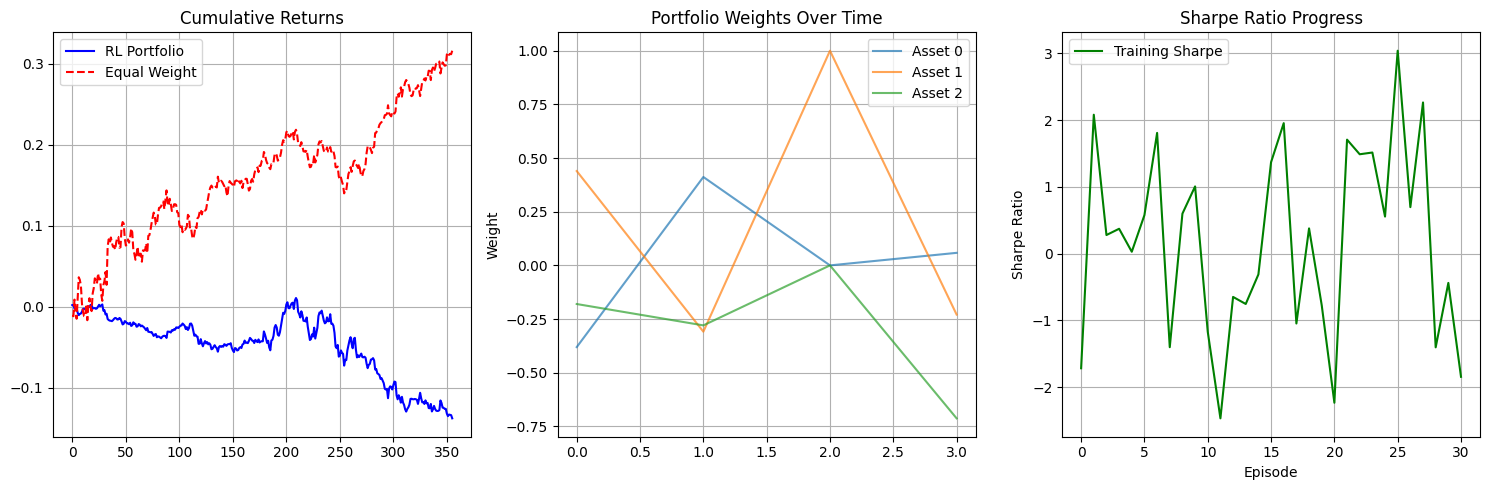

Episode 32/100, epsilon: 0.7256
Episode 33/100, epsilon: 0.7147
Episode 34/100, epsilon: 0.7076
Episode 35/100, epsilon: 0.6936
Episode 36/100, epsilon: 0.6866
Episode 37/100, epsilon: 0.6764
Episode 38/100, epsilon: 0.6696
Episode 39/100, epsilon: 0.6564
Episode 40/100, epsilon: 0.6433
Episode 41/100, epsilon: 0.6369


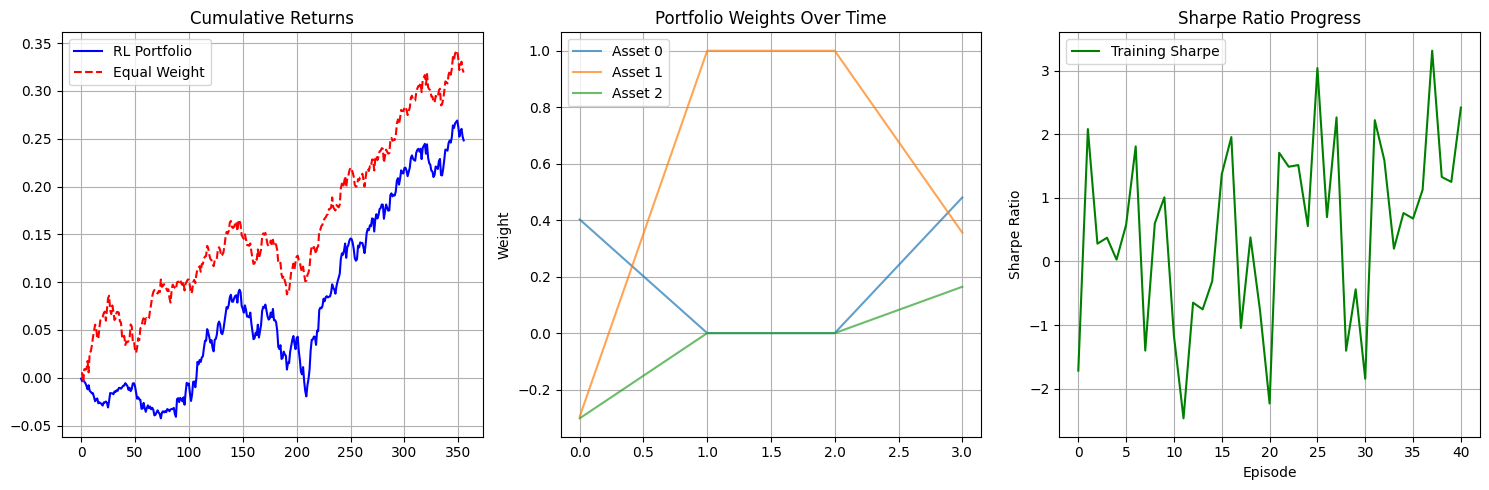

Episode 42/100, epsilon: 0.6243
Episode 43/100, epsilon: 0.6149
Episode 44/100, epsilon: 0.6088
Episode 45/100, epsilon: 0.5997
Episode 46/100, epsilon: 0.5937
Episode 47/100, epsilon: 0.5820
Episode 48/100, epsilon: 0.5762
Episode 49/100, epsilon: 0.5676
Episode 50/100, epsilon: 0.5619
Episode 51/100, epsilon: 0.5535


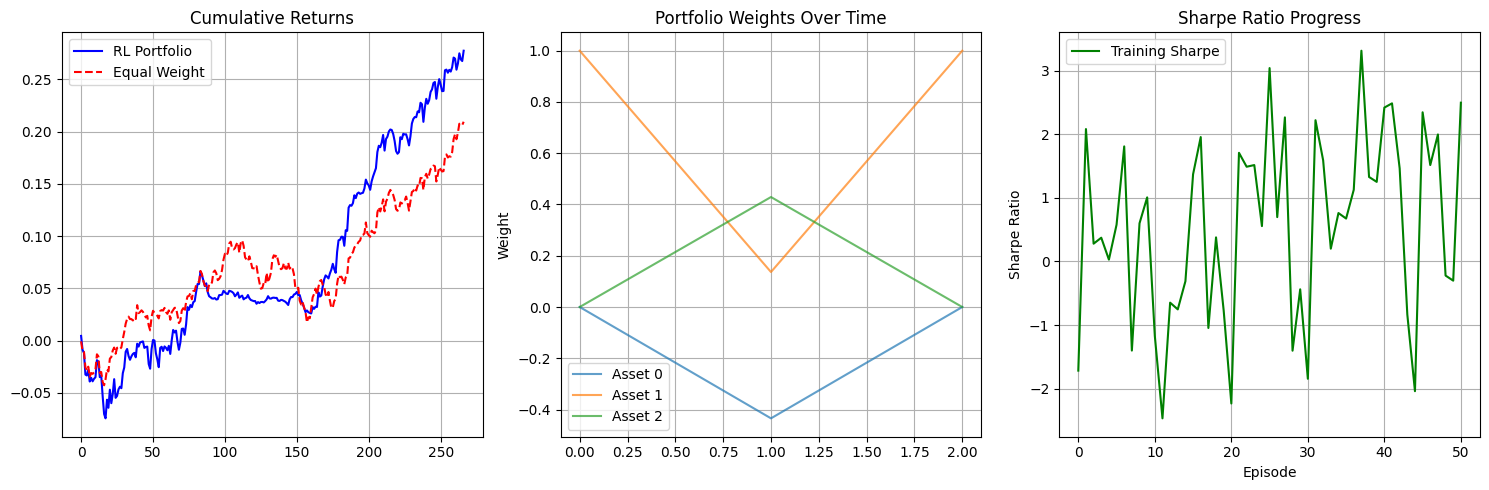

Episode 52/100, epsilon: 0.5452
Episode 53/100, epsilon: 0.5371
Episode 54/100, epsilon: 0.5264
Episode 55/100, epsilon: 0.5212
Episode 56/100, epsilon: 0.5160
Episode 57/100, epsilon: 0.5108
Episode 58/100, epsilon: 0.5058
Episode 59/100, epsilon: 0.5007
Episode 60/100, epsilon: 0.4957
Episode 61/100, epsilon: 0.4908


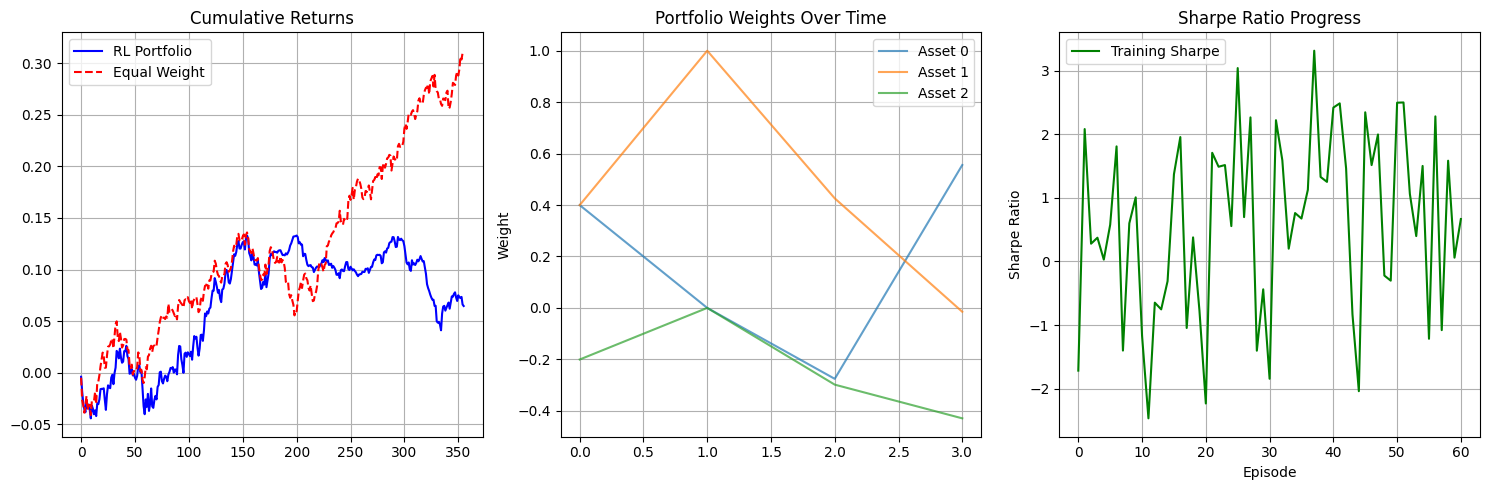

Episode 62/100, epsilon: 0.4810
Episode 63/100, epsilon: 0.4715
Episode 64/100, epsilon: 0.4668
Episode 65/100, epsilon: 0.4575
Episode 66/100, epsilon: 0.4507
Episode 67/100, epsilon: 0.4462
Episode 68/100, epsilon: 0.4417
Episode 69/100, epsilon: 0.4373
Episode 70/100, epsilon: 0.4308
Episode 71/100, epsilon: 0.4244


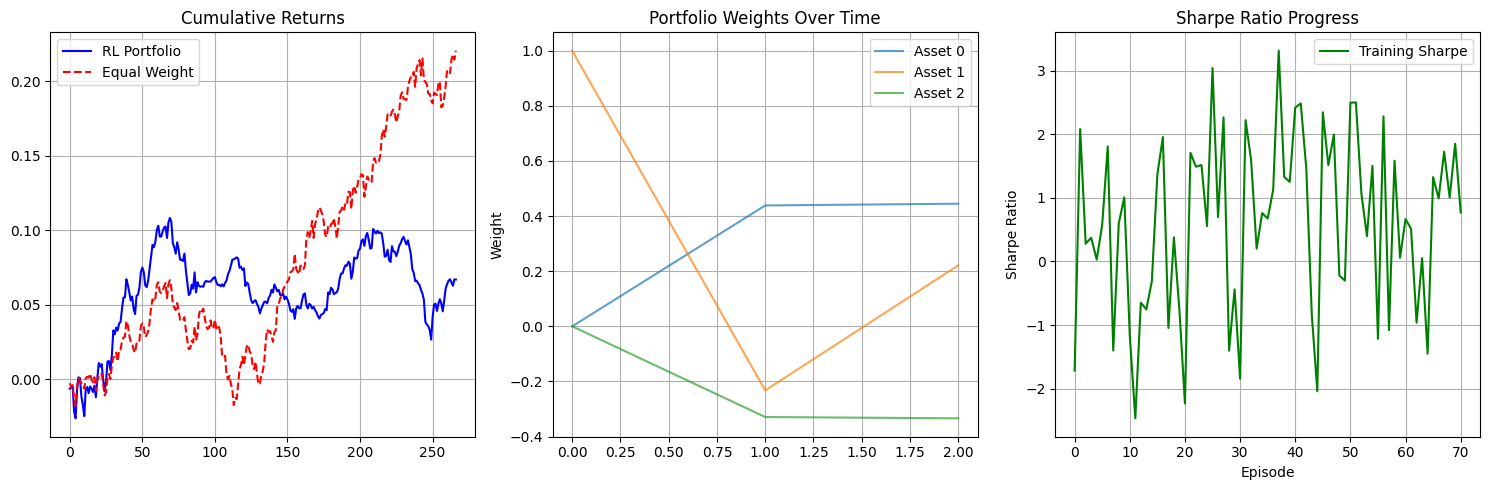

Episode 72/100, epsilon: 0.4180
Episode 73/100, epsilon: 0.4097
Episode 74/100, epsilon: 0.4016
Episode 75/100, epsilon: 0.3976
Episode 76/100, epsilon: 0.3917
Episode 77/100, epsilon: 0.3858
Episode 78/100, epsilon: 0.3820
Episode 79/100, epsilon: 0.3744
Episode 80/100, epsilon: 0.3688
Episode 81/100, epsilon: 0.3615


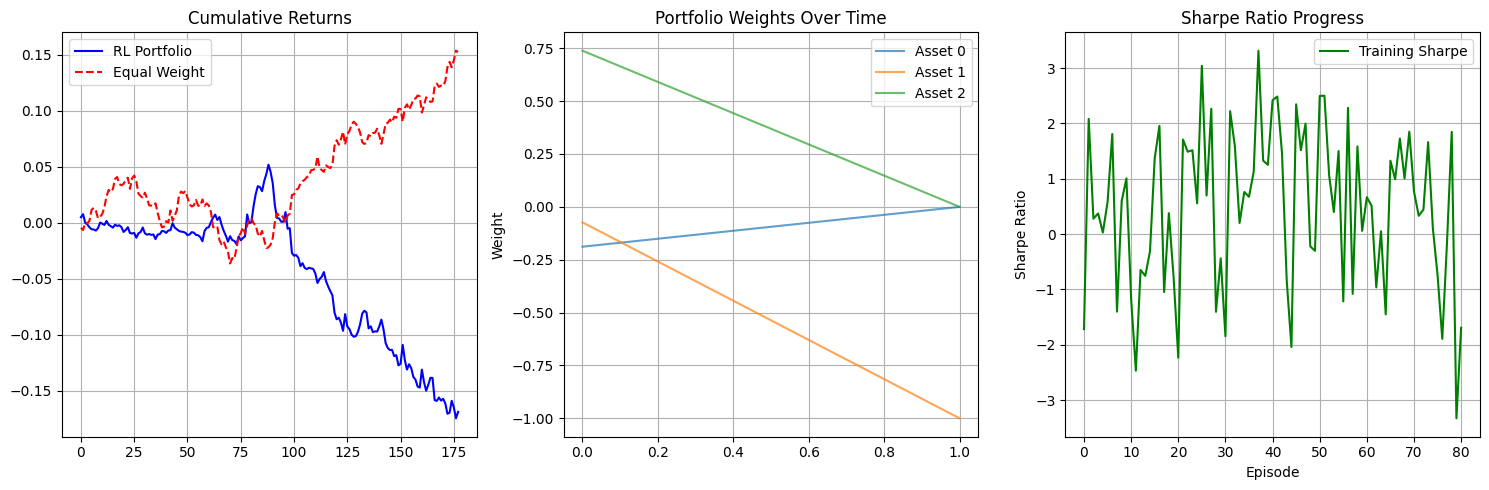

Episode 82/100, epsilon: 0.3579
Episode 83/100, epsilon: 0.3508
Episode 84/100, epsilon: 0.3455
Episode 85/100, epsilon: 0.3387
Episode 86/100, epsilon: 0.3336
Episode 87/100, epsilon: 0.3286
Episode 88/100, epsilon: 0.3254
Episode 89/100, epsilon: 0.3205
Episode 90/100, epsilon: 0.3141
Episode 91/100, epsilon: 0.3110


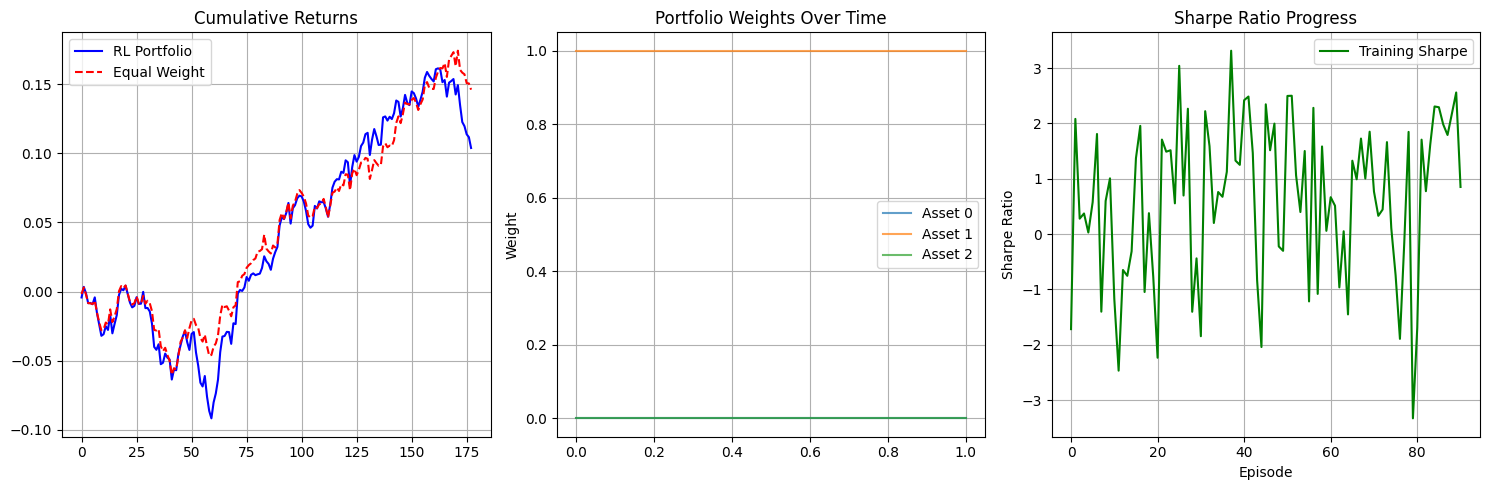

Episode 92/100, epsilon: 0.3079
Episode 93/100, epsilon: 0.3018
Episode 94/100, epsilon: 0.2973
Episode 95/100, epsilon: 0.2929
Episode 96/100, epsilon: 0.2899
Episode 97/100, epsilon: 0.2842
Episode 98/100, epsilon: 0.2785
Episode 99/100, epsilon: 0.2758
Episode 100/100, epsilon: 0.2730
Testing model on test data...

=== Training Complete ===


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
import warnings
warnings.filterwarnings('ignore')

try:
    import tensorflow as tf
    from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LSTM, Flatten
    from tensorflow.keras.models import Model
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from tensorflow.keras.regularizers import l1_l2
except ImportError:
    print("TensorFlow not available, using simplified version")
    tf = None

import random
from IPython.core.debugger import set_trace

# Portfolio utility functions
def portfolio(returns, weights):
    """Calculate portfolio metrics"""
    weights = np.array(weights)
    rets = returns.mean() * 252
    covs = returns.cov() * 252
    P_ret = np.sum(rets * weights)
    P_vol = np.sqrt(np.dot(weights.T, np.dot(covs, weights)))
    P_sharpe = P_ret / P_vol if P_vol != 0 else 0
    return np.array([P_ret, P_vol, P_sharpe])

def calculate_var(returns, confidence_level=0.05):
    """Calculate Value at Risk"""
    return np.percentile(returns, confidence_level * 100)

def calculate_max_drawdown(returns):
    """Calculate Maximum Drawdown"""
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.expanding().max()
    drawdown = (cumulative - rolling_max) / rolling_max
    return drawdown.min()

class EnhancedCryptoEnvironment:
    def __init__(self, prices, capital, transaction_cost=0.001, max_position=0.3):
        self.prices = prices
        self.capital = capital
        self.transaction_cost = transaction_cost  # 거래 비용
        self.max_position = max_position  # 최대 포지션 비중
        self.data = self.load_data()
        self.scaler = RobustScaler()  # 이상치에 강한 스케일러
        self.features_scaled = False

    def load_data(self):
        data = pd.read_csv(self.prices, index_col=0)
        return data

    def split_data(self, train_ratio=0.7, val_ratio=0.15):
        """시계열 데이터 분할 (Train/Validation/Test)"""
        n = len(self.data)
        train_end = int(n * train_ratio)
        val_end = int(n * (train_ratio + val_ratio))

        return {
            'train': (0, train_end),
            'val': (train_end, val_end),
            'test': (val_end, n)
        }

    def preprocess_state(self, state):
        """상태 전처리 with robust scaling"""
        if not self.features_scaled:
            scaled_state = self.scaler.fit_transform(state)
            self.features_scaled = True
        else:
            scaled_state = self.scaler.transform(state)

        # NaN 처리
        scaled_state = np.nan_to_num(scaled_state, nan=0.0, posinf=1.0, neginf=-1.0)
        return scaled_state

    def get_enhanced_state(self, t, lookback, include_technical=True):
        """향상된 상태 정보 (기술적 지표 포함)"""
        assert lookback <= t

        decision_making_state = self.data.iloc[t-lookback:t]
        returns = decision_making_state.pct_change().dropna()

        # 기본 공분산 행렬
        cov_matrix = returns.cov().values

        if include_technical:
            # 기술적 지표 추가
            # 1. 이동평균 비율
            ma_short = decision_making_state.rolling(window=min(10, len(decision_making_state))).mean()
            ma_long = decision_making_state.rolling(window=min(30, len(decision_making_state))).mean()
            ma_ratio = (ma_short / ma_long).iloc[-1].values if len(ma_long.dropna()) > 0 else np.ones(len(self.data.columns))

            # 2. RSI (Relative Strength Index)
            delta = decision_making_state.diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=min(14, len(delta))).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=min(14, len(delta))).mean()
            rs = gain / loss
            rsi = (100 - (100 / (1 + rs))).iloc[-1].values if len(gain.dropna()) > 0 else np.full(len(self.data.columns), 50)

            # 3. 변동성 (Volatility)
            volatility = returns.rolling(window=min(20, len(returns))).std().iloc[-1].values if len(returns) > 0 else np.zeros(len(self.data.columns))

            # NaN 처리
            ma_ratio = np.nan_to_num(ma_ratio, nan=1.0)
            rsi = np.nan_to_num(rsi, nan=50.0)
            volatility = np.nan_to_num(volatility, nan=0.1)

            # 특성 결합 - 모든 특성을 1차원으로 flatten하여 concatenate
            enhanced_features = np.concatenate([
                cov_matrix.flatten(),  # 공분산 행렬 flatten
                ma_ratio,              # 이동평균 비율
                rsi / 100.0,          # 정규화된 RSI
                volatility            # 변동성
            ])

            # 2차원으로 reshape (preprocess_state에서 기대하는 형태)
            enhanced_features = enhanced_features.reshape(1, -1)

            return self.preprocess_state(enhanced_features).flatten()

        return cov_matrix

    def get_reward_with_risk_adjustment(self, action, action_t, reward_t, alpha=0.01, risk_penalty=0.1):
        """위험 조정 보상 함수"""
        def local_portfolio_enhanced(returns, weights):
            weights = np.array(weights)
            if len(returns) == 0:
                return np.array([0, 0, 0, 0, 0])  # ret, vol, sharpe, var, max_dd

            rets = returns.mean()
            covs = returns.cov()
            P_ret = np.sum(rets * weights)
            P_vol = np.sqrt(np.dot(weights.T, np.dot(covs, weights))) if len(covs) > 0 else 0
            P_sharpe = P_ret / P_vol if P_vol != 0 else 0

            # 위험 지표 계산
            portfolio_returns = np.dot(returns.values, weights)
            var_95 = calculate_var(portfolio_returns, 0.05)
            max_dd = calculate_max_drawdown(pd.Series(portfolio_returns))

            return np.array([P_ret, P_vol, P_sharpe, var_95, max_dd])

        data_period = self.data[action_t:reward_t]
        weights = np.array(action)

        # 포지션 제한 적용
        weights = np.clip(weights, -self.max_position, self.max_position)
        weights = weights / np.sum(np.abs(weights)) if np.sum(np.abs(weights)) != 0 else weights

        returns = data_period.pct_change().dropna()

        if len(returns) == 0:
            return np.zeros(len(weights)), np.zeros(len(self.data.columns))

        portfolio_metrics = local_portfolio_enhanced(returns, weights)
        sharpe, var_95, max_dd = portfolio_metrics[2], portfolio_metrics[3], portfolio_metrics[4]

        # 거래 비용 계산 (이전 포지션과의 차이에 비례)
        transaction_cost = self.transaction_cost * np.sum(np.abs(weights))

        # 위험 조정 보상: Sharpe ratio - 거래비용 - 위험 페널티
        risk_adjusted_reward = sharpe - transaction_cost - risk_penalty * (abs(var_95) + abs(max_dd))

        reward_vector = np.full(len(self.data.columns), risk_adjusted_reward)

        # 포트폴리오 수익률
        portfolio_return = np.dot(returns.values, weights) if len(returns) > 0 else np.zeros(len(weights))

        return portfolio_return, reward_vector

class EnhancedAgent:
    def __init__(self, portfolio_size, is_eval=False, allow_short=True, use_lstm=False):
        self.portfolio_size = portfolio_size
        self.allow_short = allow_short
        self.use_lstm = use_lstm

        # Enhanced input shape for technical indicators
        # 공분산 행렬(portfolio_size^2) + 기술적 지표들(portfolio_size * 3)
        if use_lstm:
            self.input_shape = (10, portfolio_size * portfolio_size + portfolio_size * 3)  # sequence length, features
        else:
            self.input_shape = (portfolio_size * portfolio_size + portfolio_size * 3,)  # flatten된 전체 특성

        self.action_size = 3  # sit, buy, sell
        self.memory4replay = []
        self.is_eval = is_eval

        # Enhanced hyperparameters
        self.alpha = 0.3  # 학습률 감소
        self.gamma = 0.99  # 할인율 증가
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995

        # Risk management parameters
        self.max_portfolio_weight = 0.4
        self.min_portfolio_weight = -0.3 if allow_short else 0

        # TensorFlow 사용 가능한 경우에만 모델 생성
        if tf is not None:
            self.model = self._enhanced_model()
            self.target_model = self._enhanced_model()  # Target network for stability
        else:
            self.model = None
            self.target_model = None
            print("Warning: TensorFlow not available, using random policy")

        self.update_target_freq = 100
        self.step_count = 0

        # Validation tracking
        self.val_losses = []
        self.best_val_loss = float('inf')
        self.patience = 20
        self.wait = 0

    def _enhanced_model(self):
        """Enhanced model with regularization and batch normalization"""
        inputs = Input(shape=self.input_shape)

        if self.use_lstm:
            # LSTM for sequence modeling
            x = LSTM(64, return_sequences=True,
                    kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(inputs)
            x = Dropout(0.3)(x)
            x = LSTM(32, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
            x = Dropout(0.3)(x)
        else:
            # Flatten input first
            x = Flatten()(inputs) if len(self.input_shape) > 1 else inputs

            # Dense layers with batch normalization
            x = Dense(128, activation='elu',
                     kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
            x = BatchNormalization()(x)
            x = Dropout(0.4)(x)

            x = Dense(64, activation='elu',
                     kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
            x = BatchNormalization()(x)
            x = Dropout(0.3)(x)

            x = Dense(32, activation='elu',
                     kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
            x = Dropout(0.2)(x)

        # 단일 출력으로 변경 (각 자산의 액션 확률을 하나의 벡터로)
        # 출력 크기: portfolio_size * action_size
        output_size = self.portfolio_size * self.action_size
        output = Dense(output_size, activation='linear',
                      kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)

        model = Model(inputs=inputs, outputs=output)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
            loss='huber',  # Robust to outliers
            metrics=['mae']
        )
        return model

    def nn_pred_to_weights(self, pred, allow_short=False):
        """Convert neural network predictions to portfolio weights with constraints"""
        # 단일 출력에서 각 자산별 액션 추출
        pred = pred.reshape(self.portfolio_size, self.action_size)

        weights = np.zeros(self.portfolio_size)
        raw_weights = np.argmax(pred, axis=1)

        for e, r in enumerate(raw_weights):
            if r == 0:  # sit
                weights[e] = 0
            elif r == 1:  # buy
                weights[e] = np.abs(pred[e][r])
            else:  # sell
                weights[e] = -np.abs(pred[e][r])

        # Apply position limits
        weights = np.clip(weights, self.min_portfolio_weight, self.max_portfolio_weight)

        # Normalize weights
        if not allow_short:
            weights = weights - np.min(weights)

        total_weight = np.sum(np.abs(weights))
        if total_weight == 0:
            weights = np.ones(self.portfolio_size) / self.portfolio_size
        else:
            weights = weights / total_weight

        return weights, np.min(weights), total_weight

    def act(self, state):
        """Enhanced action selection with improved exploration"""
        if state is None or (hasattr(state, 'size') and state.size == 0):
            return np.ones(self.portfolio_size) / self.portfolio_size, None, 1.0

        # Epsilon-greedy with decay
        if not self.is_eval and np.random.random() <= self.epsilon:
            # Improved random exploration
            w = np.random.normal(0, 0.5, size=(self.portfolio_size,))
            w = np.clip(w, self.min_portfolio_weight, self.max_portfolio_weight)

            if not self.allow_short:
                w = w - np.min(w)

            total_weight = np.sum(np.abs(w))
            if total_weight == 0:
                w = np.ones(self.portfolio_size) / self.portfolio_size
            else:
                w = w / total_weight

            return w, np.min(w), total_weight

        # TensorFlow 모델이 없는 경우 균등 배분
        if self.model is None:
            w = np.ones(self.portfolio_size) / self.portfolio_size
            return w, None, 1.0

        try:
            # 상태 배열 처리
            if hasattr(state, 'values'):
                state_array = state.values
            elif isinstance(state, pd.DataFrame) or isinstance(state, pd.Series):
                state_array = state.values
            else:
                state_array = np.array(state)

            # 1차원으로 flatten
            if len(state_array.shape) > 1:
                state_array = state_array.flatten()

            # 예상되는 입력 크기와 맞는지 확인
            expected_size = self.input_shape[0] if not self.use_lstm else self.input_shape[1]

            if len(state_array) != expected_size:
                print(f"Warning: State size mismatch. Expected: {expected_size}, Got: {len(state_array)}")
                # 크기 조정
                if len(state_array) < expected_size:
                    # 패딩
                    padding = np.zeros(expected_size - len(state_array))
                    state_array = np.concatenate([state_array, padding])
                else:
                    # 잘라내기
                    state_array = state_array[:expected_size]

            # LSTM용 reshape
            if self.use_lstm:
                # LSTM은 3D 입력이 필요: (batch_size, timesteps, features)
                state_array = state_array.reshape(1, 1, -1)  # 단일 timestep으로 처리
            else:
                # Dense layer용 reshape
                state_array = state_array.reshape(1, -1)

            # NaN 처리
            state_array = np.nan_to_num(state_array, nan=0.0, posinf=1.0, neginf=-1.0)

            # 예측 실행
            pred = self.model.predict(state_array, verbose=0)

            # 단일 출력을 (portfolio_size, action_size) 형태로 변환
            pred = pred.reshape(1, self.portfolio_size, self.action_size)

            return self.nn_pred_to_weights(pred[0], self.allow_short)

        except Exception as e:
            print(f"Error in act(): {e}")
            # 에러 발생 시 균등 포트폴리오 반환
            w = np.ones(self.portfolio_size) / self.portfolio_size
            return w, None, 1.0

    def update_target_model(self):
        """Update target network"""
        if self.target_model is not None and self.model is not None:
            self.target_model.set_weights(self.model.get_weights())

    def expReplay(self, batch_size, validation_data=None):
        """Enhanced experience replay with single output model"""
        # TensorFlow 모델이 없는 경우 스킵
        if self.model is None:
            return

        if len(self.memory4replay) < batch_size:
            return

        # Sample batch
        batch_samples = random.sample(self.memory4replay, min(batch_size, len(self.memory4replay)))

        # 배치 데이터 준비
        batch_states = []
        batch_targets = []

        for (s, s_, action, reward, done) in batch_samples:
            try:
                # 상태 배열 처리
                if hasattr(s, 'values'):
                    s_array = s.values
                elif isinstance(s, pd.DataFrame) or isinstance(s, pd.Series):
                    s_array = s.values
                else:
                    s_array = np.array(s)

                if hasattr(s_, 'values'):
                    s_next_array = s_.values
                elif isinstance(s_, pd.DataFrame) or isinstance(s_, pd.Series):
                    s_next_array = s_.values
                else:
                    s_next_array = np.array(s_)

                # 1차원으로 flatten
                if len(s_array.shape) > 1:
                    s_array = s_array.flatten()
                if len(s_next_array.shape) > 1:
                    s_next_array = s_next_array.flatten()

                # 예상 크기와 맞는지 확인
                expected_size = self.input_shape[0] if not self.use_lstm else self.input_shape[1]

                if len(s_array) != expected_size or len(s_next_array) != expected_size:
                    continue

                # NaN 값 처리
                s_array = np.nan_to_num(s_array, nan=0.0)
                s_next_array = np.nan_to_num(s_next_array, nan=0.0)

                # 현재 Q 값 예측
                current_q = self.model.predict(s_array.reshape(1, -1), verbose=0)
                current_q = current_q.reshape(self.portfolio_size, self.action_size)

                # 다음 상태의 Q 값 예측 (target network 사용)
                if not done:
                    next_q = self.target_model.predict(s_next_array.reshape(1, -1), verbose=0)
                    next_q = next_q.reshape(self.portfolio_size, self.action_size)
                    max_next_q = np.max(next_q, axis=1)
                else:
                    max_next_q = np.zeros(self.portfolio_size)

                # Target Q 값 계산
                target_q = current_q.copy()
                action_weights = action[0] if len(action) > 0 else np.zeros(self.portfolio_size)

                for i in range(self.portfolio_size):
                    if i < len(action_weights) and i < len(reward):
                        if action_weights[i] == 0:
                            target_q[i][0] = reward[i] + self.gamma * max_next_q[i]
                        elif action_weights[i] > 0:
                            target_q[i][1] = reward[i] + self.gamma * max_next_q[i]
                        else:
                            target_q[i][2] = reward[i] + self.gamma * max_next_q[i]

                # 배치에 추가
                batch_states.append(s_array)
                batch_targets.append(target_q.flatten())

            except Exception as e:
                print(f"Error in experience replay iteration: {e}")
                continue

        # 배치 훈련
        if len(batch_states) > 0:
            try:
                batch_states = np.array(batch_states)
                batch_targets = np.array(batch_targets)

                # 모델 훈련
                history = self.model.fit(
                    batch_states,
                    batch_targets,
                    epochs=1,
                    verbose=0,
                    batch_size=min(32, len(batch_states))
                )

                # Validation loss tracking
                if validation_data is not None and 'val_loss' in history.history:
                    val_loss = history.history['val_loss'][0]
                    self.val_losses.append(val_loss)

                    if val_loss < self.best_val_loss:
                        self.best_val_loss = val_loss
                        self.wait = 0
                    else:
                        self.wait += 1

                    if self.wait >= self.patience:
                        print("Early stopping triggered")

            except Exception as e:
                print(f"Error in batch training: {e}")

        # Update target network periodically
        self.step_count += 1
        if self.step_count % self.update_target_freq == 0:
            self.update_target_model()

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def train_with_validation(agent, env, window_size=180, episode_count=50, batch_size=32, rebalance_period=90):
    """Enhanced training with validation split"""

    data_splits = env.split_data()
    train_start, train_end = data_splits['train']
    val_start, val_end = data_splits['val']
    test_start, test_end = data_splits['test']

    print(f"Data splits - Train: {train_start}-{train_end}, Val: {val_start}-{val_end}, Test: {test_start}-{test_end}")

    # Training metrics tracking
    training_metrics = {
        'episode_returns': [],
        'episode_sharpe': [],
        'episode_max_dd': [],
        'val_returns': [],
        'val_sharpe': []
    }

    best_val_sharpe = -np.inf
    patience_counter = 0
    max_patience = 10

    # TensorFlow 로깅 비활성화 (사용 가능한 경우에만)
    if tf is not None:
        tf.keras.utils.disable_interactive_logging()

    for e in range(episode_count):
        print(f"Episode {e+1}/{episode_count}, epsilon: {agent.epsilon:.4f}")

        # Training phase
        agent.is_eval = False
        episode_returns = []
        episode_equal_returns = []
        actions_history = []

        # Random start within training data
        start_t = np.random.randint(train_start + window_size + 1, train_end - window_size - 1)
        s = env.get_enhanced_state(start_t, window_size)

        # Training loop within episode
        for t in range(start_t, min(start_t + 1000, train_end), rebalance_period):
            if t + rebalance_period >= train_end:
                break

            date1 = t
            date2 = min(t + rebalance_period, train_end)

            s_ = env.get_enhanced_state(date2, window_size)
            action = agent.act(s_)
            actions_history.append(action[0])

            # Get rewards
            weighted_returns, reward = env.get_reward_with_risk_adjustment(action[0], date1, date2)
            equal_returns, _ = env.get_reward_with_risk_adjustment(
                np.ones(agent.portfolio_size) / agent.portfolio_size, date1, date2)

            episode_returns.extend(weighted_returns)
            episode_equal_returns.extend(equal_returns)

            # Store experience
            done = (date2 >= train_end)
            agent.memory4replay.append((s, s_, action, reward, done))

            # Experience replay
            if len(agent.memory4replay) >= batch_size:
                agent.expReplay(batch_size)

            s = s_

        # Calculate training metrics
        if len(episode_returns) > 0:
            episode_return = np.array(episode_returns).sum()
            episode_vol = np.array(episode_returns).std() * np.sqrt(252)
            episode_sharpe = episode_return / episode_vol if episode_vol != 0 else 0
            episode_max_dd = calculate_max_drawdown(pd.Series(episode_returns))

            training_metrics['episode_returns'].append(episode_return)
            training_metrics['episode_sharpe'].append(episode_sharpe)
            training_metrics['episode_max_dd'].append(episode_max_dd)

        # Validation phase
        if e % 5 == 0:  # Validate every 5 episodes
            agent.is_eval = True
            val_returns = []

            for t in range(val_start + window_size, val_end, rebalance_period):
                if t + rebalance_period >= val_end:
                    break

                s_val = env.get_enhanced_state(t, window_size)
                action_val = agent.act(s_val)

                weighted_returns_val, _ = env.get_reward_with_risk_adjustment(
                    action_val[0], t, min(t + rebalance_period, val_end))
                val_returns.extend(weighted_returns_val)

            if len(val_returns) > 0:
                val_return = np.array(val_returns).sum()
                val_vol = np.array(val_returns).std() * np.sqrt(252)
                val_sharpe = val_return / val_vol if val_vol != 0 else 0

                training_metrics['val_returns'].append(val_return)
                training_metrics['val_sharpe'].append(val_sharpe)

                print(f"Validation - Return: {val_return:.4f}, Sharpe: {val_sharpe:.4f}")

                # Early stopping based on validation Sharpe ratio
                if val_sharpe > best_val_sharpe:
                    best_val_sharpe = val_sharpe
                    patience_counter = 0
                    # Save best model
                    agent.model.save_weights('best_model_weights.h5')
                else:
                    patience_counter += 1

                if patience_counter >= max_patience:
                    print(f"Early stopping at episode {e+1}")
                    break

        # Plot progress every 10 episodes
        if e % 10 == 0 and len(episode_returns) > 0:
            plt.figure(figsize=(15, 5))

            # Returns comparison
            plt.subplot(1, 3, 1)
            rl_cumret = np.array(episode_returns).cumsum()
            equal_cumret = np.array(episode_equal_returns).cumsum()
            plt.plot(rl_cumret, label='RL Portfolio', color='blue')
            plt.plot(equal_cumret, label='Equal Weight', color='red', linestyle='--')
            plt.title('Cumulative Returns')
            plt.legend()
            plt.grid(True)

            # Portfolio weights
            plt.subplot(1, 3, 2)
            actions_array = np.array(actions_history)
            for i in range(agent.portfolio_size):
                plt.plot(actions_array[:, i], alpha=0.7, label=f'Asset {i}')
            plt.title('Portfolio Weights Over Time')
            plt.ylabel('Weight')
            plt.legend()
            plt.grid(True)

            # Training metrics
            plt.subplot(1, 3, 3)
            if len(training_metrics['episode_sharpe']) > 0:
                plt.plot(training_metrics['episode_sharpe'], label='Training Sharpe', color='green')
            if len(training_metrics['val_sharpe']) > 0:
                val_episodes = np.arange(0, len(training_metrics['val_sharpe'])) * 5
                plt.plot(val_episodes, training_metrics['val_sharpe'],
                        label='Validation Sharpe', color='orange', marker='o')
            plt.title('Sharpe Ratio Progress')
            plt.xlabel('Episode')
            plt.ylabel('Sharpe Ratio')
            plt.legend()
            plt.grid(True)

            plt.tight_layout()
            plt.show()

        # Memory management
        if len(agent.memory4replay) > 10000:
            agent.memory4replay = agent.memory4replay[-5000:]

    return training_metrics

def test_model(agent, env, window_size=180, rebalance_period=90):
    """Test the trained model on test data"""
    data_splits = env.split_data()
    test_start, test_end = data_splits['test']

    agent.is_eval = True  # Set to evaluation mode

    test_returns = []
    equal_returns = []
    actions_history = []

    print("Testing model on test data...")

    for t in range(test_start + window_size, test_end, rebalance_period):
        if t + rebalance_period >= test_end:
            break

        s_test = env.get_enhanced_state(t, window_size)
        action_test = agent.act(s_test)
        actions_history.append(action_test[0])

        # Get returns
        weighted_returns_test, _ = env.get_reward_with_risk_adjustment(
            action_test[0], t, min(t + rebalance_period, test_end))
        equal_returns_test, _ = env.get_reward_with_risk_adjustment(
            np.ones(agent.portfolio_size) / agent.portfolio_size, t, min(t + rebalance_period, test_end))

        test_returns.extend(weighted_returns_test)
        equal_returns.extend(equal_returns_test)

    # Calculate test metrics
    if len(test_returns) > 0:
        test_metrics = {
            'total_return': np.array(test_returns).sum(),
            'volatility': np.array(test_returns).std() * np.sqrt(252),
            'sharpe_ratio': np.array(test_returns).sum() / (np.array(test_returns).std() * np.sqrt(252)) if np.array(test_returns).std() != 0 else 0,
            'max_drawdown': calculate_max_drawdown(pd.Series(test_returns)),
            'var_95': calculate_var(test_returns, 0.05)
        }

        equal_metrics = {
            'total_return': np.array(equal_returns).sum(),
            'volatility': np.array(equal_returns).std() * np.sqrt(252),
            'sharpe_ratio': np.array(equal_returns).sum() / (np.array(equal_returns).std() * np.sqrt(252)) if np.array(equal_returns).std() != 0 else 0,
            'max_drawdown': calculate_max_drawdown(pd.Series(equal_returns)),
            'var_95': calculate_var(equal_returns, 0.05)
        }

        print("\n=== Test Results ===")
        print("RL Portfolio:")
        for key, value in test_metrics.items():
            print(f"  {key}: {value:.4f}")

        print("\nEqual Weight Portfolio:")
        for key, value in equal_metrics.items():
            print(f"  {key}: {value:.4f}")

        # Plot test results
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        rl_cumret = np.array(test_returns).cumsum()
        equal_cumret = np.array(equal_returns).cumsum()
        plt.plot(rl_cumret, label='RL Portfolio', color='blue', linewidth=2)
        plt.plot(equal_cumret, label='Equal Weight', color='red', linestyle='--', linewidth=2)
        plt.title('Test Period: Cumulative Returns')
        plt.xlabel('Time')
        plt.ylabel('Cumulative Return')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        actions_array = np.array(actions_history)
        for i in range(agent.portfolio_size):
            plt.plot(actions_array[:, i], alpha=0.8, label=f'Asset {i}')
        plt.title('Test Period: Portfolio Weights')
        plt.xlabel('Rebalancing Period')
        plt.ylabel('Weight')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        return test_metrics, equal_metrics

    return None, None

# Main execution
if __name__ == "__main__":
    # Initialize environment and agent
    N_ASSETS = asset_col
    agent = EnhancedAgent(N_ASSETS, use_lstm=False)  # Set to True for LSTM
    price = csv_name
    capital = 1e6
    env = EnhancedCryptoEnvironment(price, capital)

    print(f"Portfolio size: {N_ASSETS}")
    print(f"Data shape: {env.data.shape}")
    print(f"TensorFlow available: {tf is not None}")

    # Train with validation
    training_metrics = train_with_validation(
        agent, env,
        window_size=180,
        episode_count=20 if tf is None else 100,  # 축소된 에피소드 수 (TF 없는 경우)
        batch_size=32,
        rebalance_period=90
    )

    # Test the model
    test_metrics, equal_metrics = test_model(agent, env)

    print("\n=== Training Complete ===")
    if test_metrics:
        print(f"Final Test Sharpe Ratio: {test_metrics['sharpe_ratio']:.4f}")
        print(f"Improvement over Equal Weight: {test_metrics['sharpe_ratio'] - equal_metrics['sharpe_ratio']:.4f}")